## Carga de paquetes

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_squared_error
import math
from statistics import mean
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
from keras import Input
import tensorflow as tf
import optuna
from tensorflow.keras.callbacks import EarlyStopping

c:\Users\josek\Desktop\Maestria\series\series_de_tiempo\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Funciones

In [2]:
def crear_dataset_supervisado(array, input_length, output_length, col_index=1):
    '''Permite crear un dataset con las entradas (X) y salidas (Y)
    requeridas por la Red LSTM.

    Parámetros:
    - array: arreglo numpy de tamaño N x features (N: cantidad de datos,
      f: cantidad de features)
    - input_length: instantes de tiempo consecutivos de la(s) serie(s) de tiempo
      usados para alimentar el modelo
    - output_length: instantes de tiempo a pronosticar (salida del modelo)
    '''

    # Inicialización (y verificación de dimensiones)
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado) #Si el array tiene solo una dimensión, se transforma en un arreglo de 2 dimensiones con una sola columna.
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado <-- <--- ¡esta parte de la función se ejecuta en este caso!
        fils, cols = array.shape

    # Generar los arreglos (Construcción de los conjuntos de entrada (X) y salida (Y))
    for i in range(fils-input_length-output_length+1):
        X.append(array[i:i+INPUT_LENGTH,0:cols])
        #Salida (el índice col_index corresponde a la columna con la variable a predecir)
        Y.append(array[i+input_length:i+input_length+output_length,col_index].reshape(output_length,1)) #<--Importante! se utiliza la columna indicada por col_index del array como variable objetivo

    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)

    return X, Y

In [3]:
def escalar_dataset(data_input, col_ref, df):
    '''Escala el dataset en el rango de -1 a 1.

    Entradas:
    - data_input: diccionario con los dataset de entrada y salida del modelo
    (data_input = {'x_tr':x_tr, 'y_tr':y_tr, 'x_vl':x_vl, 'y_vl':y_vl,
                    'y_ts':y_ts})
    - col_ref: parámetro adicional para especificar la columna que contiene
      la variable a predecir


    Retorna:
    - data_scaled: diccionario con los datasets de entrada y salida escalados
      (tiene la misma estructura del diccionario de entrada)
    - scaler: el escalador usado (requerido para las predicciones)
    '''

    # *** Implementación adicional: determinar el índice de la columna
    # que contiene la variable a predecir
    col_ref = df.columns.get_loc(col_ref) #nuestra columna de referencia, para el escalamiento inverso que se hace después

    # Número de instantes de tiempo de entrada y de covariables
    NSAMPLES = data_input['x_tr'].shape[1]
    NFEATS = data_input['x_tr'].shape[2] #20

    # Generar listado con "scalers" (1 por cada covariable de entrada)
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)] #20 escaladores

    # Arreglos que contendrán los datasets escalados (Estos arreglos inicializan matrices vacías para almacenar los valores escalados.)
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs (ENTRADAS)
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])

    # Escalamiento Ys (teniendo en cuenta "col_ind"), solo el de la variable temperatura (salidas)
    y_tr_s[:,:,0] = scalers[col_ref].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[col_ref].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[col_ref].transform(y_ts[:,:,0])

    # Conformar diccionario de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[col_ref]

In [4]:
def escalar_dataset_no_val(data_input, col_ref, df):
    '''Escala el dataset en el rango de -1 a 1.

    Entradas:
    - data_input: diccionario con los dataset de entrada y salida del modelo
    (data_input = {'x_tr':x_tr, 'y_tr':y_tr, 'x_vl':x_vl, 'y_vl':y_vl,
                    'y_ts':y_ts})
    - col_ref: parámetro adicional para especificar la columna que contiene
      la variable a predecir


    Retorna:
    - data_scaled: diccionario con los datasets de entrada y salida escalados
      (tiene la misma estructura del diccionario de entrada)
    - scaler: el escalador usado (requerido para las predicciones)
    '''

    # *** Implementación adicional: determinar el índice de la columna
    # que contiene la variable a predecir
    col_ref = df.columns.get_loc(col_ref) #nuestra columna de referencia, para el escalamiento inverso que se hace después

    # Número de instantes de tiempo de entrada y de covariables
    NSAMPLES = data_input['x_tr'].shape[1]
    NFEATS = data_input['x_tr'].shape[2] #20

    # Generar listado con "scalers" (1 por cada covariable de entrada)
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)] #20 escaladores

    # Arreglos que contendrán los datasets escalados (Estos arreglos inicializan matrices vacías para almacenar los valores escalados.)
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs (ENTRADAS)
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])

    # Escalamiento Ys (teniendo en cuenta "col_ind"), solo el de la variable temperatura (salidas)
    y_tr_s[:,:,0] = scalers[col_ref].fit_transform(y_tr[:,:,0])
    y_ts_s[:,:,0] = scalers[col_ref].transform(y_ts[:,:,0])

    # Conformar diccionario de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[col_ref]

In [5]:
def escalar_dataset_uni(data_input):
    NFEATS = data_input['x_tr'].shape[2]

    # Generar listado con "scalers"
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados (Se crean arreglos vacíos con las mismas dimensiones que los conjuntos de datos originales para almacenar los datos escalados)
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs (aca es una sola feature, pero en un multivariado ya nos quedará a estructura)
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i]) #ajustamos a los datos de entrenamiento
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i]) #transformamos con el ajuste a val y a test tomando el rango del set de entrenamiento
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])

    # Escalamiento Ys (Se asume que las etiquetas se encuentran en la última columna de los conjuntos de datos...ademas, en este caso es una sola columna)
    y_tr_s[:,:,0] = scalers[-1].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[-1].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[-1].transform(y_ts[:,:,0])

    # Conformar ` de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[0] #útil para realizar la inversión de escalamiento

In [6]:
def escalar_dataset_uni(data_input):
    NFEATS = data_input['x_tr'].shape[2]

    # Generar listado con "scalers"
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados (Se crean arreglos vacíos con las mismas dimensiones que los conjuntos de datos originales para almacenar los datos escalados)
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs (aca es una sola feature, pero en un multivariado ya nos quedará a estructura)
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i]) #ajustamos a los datos de entrenamiento
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i]) #transformamos con el ajuste a val y a test tomando el rango del set de entrenamiento
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])

    # Escalamiento Ys (Se asume que las etiquetas se encuentran en la última columna de los conjuntos de datos...ademas, en este caso es una sola columna)
    y_tr_s[:,:,0] = scalers[-1].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[-1].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[-1].transform(y_ts[:,:,0])

    # Conformar ` de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[0] #útil para realizar la inversión de escalamiento

In [7]:
# Función para generar las particiones preservando las características
# de la serie de tiempo

def train_val_test_split(dataframe, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):
    # Definir número de datos en cada subserie
    N = dataframe.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = dataframe[0:Ntrain]
    val = dataframe[Ntrain:Ntrain+Nval]
    test = dataframe[Ntrain+Nval:]

    return train, val, test

In [8]:
def predecir(x, model, scaler):
    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x,verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

In [9]:
def objective(trial):
    # limpiar sesión para no acumular grafos de TF/Keras
    tf.keras.backend.clear_session()

    # sugerencias de hiperparámetros
    n_units = trial.suggest_int('n_units', 16, 256, step=16)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    batch_size_trial = trial.suggest_categorical('batch_size', [256])
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    num = trial.suggest_int('num', 1, 4, step=1)
    epochs_trial = trial.suggest_int('epochs', 50, 400, step=10)

    # construir modelo según las sugerencias
    # Ajustar parámetros para reproducibilidad del entrenamiento
    tf.random.set_seed(42)
    tf.config.experimental.enable_op_determinism()

    model_trial = Sequential()
    model_trial.add(Input(shape=INPUT_SHAPE))
    [model_trial.add(LSTM(n_units, activation=activation, return_sequences=True)) for _ in range(num-1)]
    model_trial.add(LSTM(n_units, activation=activation))
    model_trial.add(Dense(OUTPUT_LENGTH, activation='linear'))
    optimizer_trial = RMSprop(learning_rate=lr)
    model_trial.compile(optimizer=optimizer_trial, loss=root_mean_squared_error)

    # callback de parada temprana
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=10,
                                   restore_best_weights=True,
                                   verbose=0)

    # entrenamiento
    history = model_trial.fit(x_tr_s, y_tr_s,
                              epochs=epochs_trial,
                              batch_size=batch_size_trial,
                              validation_data=(x_vl_s, y_vl_s),
                              callbacks=[early_stopping],
                              verbose=0)

    # devolver la mejor pérdida de validación del trial
    return min(history.history['val_loss'])

In [10]:
def objective_no_val(trial):
    # limpiar sesión para no acumular grafos de TF/Keras
    tf.keras.backend.clear_session()

    # sugerencias de hiperparámetros
    n_units = trial.suggest_int('n_units', 16, 256, step=16)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    batch_size_trial = trial.suggest_categorical('batch_size', [256])
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    num = trial.suggest_int('num', 1, 4, step=1)
    epochs_trial = trial.suggest_int('epochs', 50, 400, step=10)

    # construir modelo según las sugerencias
    # Ajustar parámetros para reproducibilidad del entrenamiento
    tf.random.set_seed(42)
    tf.config.experimental.enable_op_determinism()

    model_trial = Sequential()
    model_trial.add(Input(shape=INPUT_SHAPE))
    [model_trial.add(LSTM(n_units, activation=activation, return_sequences=True)) for _ in range(num-1)]
    model_trial.add(LSTM(n_units, activation=activation))
    model_trial.add(Dense(OUTPUT_LENGTH, activation='linear'))
    optimizer_trial = RMSprop(learning_rate=lr)
    model_trial.compile(optimizer=optimizer_trial, loss=root_mean_squared_error)

    # callback de parada temprana
    early_stopping = EarlyStopping(monitor='loss',
                                   patience=10,
                                   restore_best_weights=True,
                                   verbose=0)

    # entrenamiento
    history = model_trial.fit(x_tr_s, y_tr_s,
                              epochs=epochs_trial,
                              batch_size=batch_size_trial,
                              callbacks=[early_stopping],
                              verbose=0)

    # devolver la mejor pérdida de validación del trial
    return min(history.history['loss'])

In [11]:
# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la temperatura
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

    

In [ ]:
# -------------------------------------------------------------------------
# FUNCIÓN REESCRITA: PREDICCIÓN POR BLOQUES (JUMPING)
# -------------------------------------------------------------------------
def predecir_recursivo_bloques(x_ts_s, final_model, scaler, INPUT_LENGTH, OUTPUT_LENGTH):
    """
    Predicción recursiva por bloques:
    1. Predice 'OUTPUT_LENGTH' pasos.
    2. Usa esas predicciones como input 'firme' para el siguiente bloque.
    3. Salta en el tiempo OUTPUT_LENGTH pasos para tomar las features exógenas reales correspondientes.
    """
    n_features = x_ts_s.shape[2]
    n_windows = x_ts_s.shape[0]
    
    all_predictions_original = []
    
    # Historial inicial (Variable objetivo escalada): Tomamos la ventana inicial
    # shape: (INPUT_LENGTH, )
    history_target_scaled = x_ts_s[0, :, 0].copy().tolist()
    
    # Iteramos saltando de bloque en bloque (step = 0, 4, 8...)
    # Usamos range con step = OUTPUT_LENGTH
    for step in range(0, n_windows, OUTPUT_LENGTH):
        
        # --- 1. CONSTRUIR INPUT WINDOW ---
        
        # A. Obtener la parte Target (Recuperada de nuestro historial recursivo)
        # Tomamos los últimos INPUT_LENGTH valores acumulados
        input_target = np.array(history_target_scaled[-INPUT_LENGTH:]).reshape(INPUT_LENGTH, 1)
        
        # B. Obtener las Features Exógenas (Datos reales futuros conocidos)
        # Tomamos del dataset original en la posición 'step'.
        # x_ts_s[step] ya tiene las variables exógenas alineadas correctamente para predecir el bloque siguiente.
        input_exog = x_ts_s[step, :, 1:]
        
        # C. Combinar Target Predicho + Exógenas Reales
        current_data = np.hstack([input_target, input_exog]) # Shape: (INPUT_LENGTH, n_features)
        current_data = current_data.reshape(1, INPUT_LENGTH, n_features)
        
        # --- 2. PREDECIR ---
        pred_scaled = final_model.predict(current_data, verbose=0)
        
        # Manejo de dimensiones (asegurar flat)
        if len(pred_scaled.shape) > 2: pred_scaled = pred_scaled.squeeze()
        pred_scaled_flat = pred_scaled.flatten() # Shape: (OUTPUT_LENGTH, )
        
        # --- 3. GUARDAR Y ACTUALIZAR ---
        
        # A. Invertir escala para guardar el resultado final
        pred_scaled_biv = pred_scaled_flat.reshape(1, -1)
        pred_original = scaler.inverse_transform(pred_scaled_biv).flatten()
        all_predictions_original.extend(pred_original)
        
        # B. Agregar la predicción ESCALADA al historial para la siguiente vuelta
        # Esto es clave: el siguiente input se basará en lo que acabamos de predecir
        history_target_scaled.extend(pred_scaled_flat.tolist())

    return np.array(all_predictions_original)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# -------------------------------------------------------------------------
# FUNCIÓN REESCRITA: ROLLING FORECAST (Actualiza con datos reales)
# -------------------------------------------------------------------------
def predecir_con_actualizacion_real(x_ts_s, final_model, scaler, INPUT_LENGTH, OUTPUT_LENGTH):
    """
    Rolling Forecast:
    1. Predice 'OUTPUT_LENGTH' pasos.
    2. Para el siguiente paso, OLVIDA la predicción anterior y carga los datos 
       REALES desde x_ts_s para usarlos como input.
    """
    n_windows = x_ts_s.shape[0]
    
    all_predictions_original = []
    
    # Iteramos saltando de bloque en bloque (step = 0, 4, 8...)
    for step in range(0, n_windows, OUTPUT_LENGTH):
        
        # --- 1. OBTENER INPUT WINDOW (DATOS REALES) ---
        # En lugar de construir una ventana con predicciones pasadas,
        # tomamos directamente la ventana 'step' de x_ts_s.
        # x_ts_s[step] contiene la historia REAL hasta ese momento.
        
        current_data = x_ts_s[step:step+1] # Shape: (1, INPUT_LENGTH, n_features)
        
        # --- 2. PREDECIR ---
        pred_scaled = final_model.predict(current_data, verbose=0)
        
        # Manejo de dimensiones
        if len(pred_scaled.shape) > 2: pred_scaled = pred_scaled.squeeze()
        pred_scaled_flat = pred_scaled.flatten() # Shape: (OUTPUT_LENGTH, )
        
        # --- 3. GUARDAR RESULTADO ---
        # Solo invertimos y guardamos. NO extendemos ninguna historia.
        pred_scaled_biv = pred_scaled_flat.reshape(1, -1)
        pred_original = scaler.inverse_transform(pred_scaled_biv).flatten()
        
        all_predictions_original.extend(pred_original)

    return np.array(all_predictions_original)



## AG Barometer

### Preprocesamiento

In [12]:
df_agbarometer = pd.read_csv('../data/clean_data/agbarometer_cleaned.csv')
print(df_agbarometer.head(10))

     Bimestre  CondicIones presentes  Expectativas futuras  Ag Barometer
0  2018-11-01                     43                   130            95
1  2019-01-01                     59                   137           106
2  2019-03-01                     69                   126           103
3  2019-05-01                     82                   141           117
4  2019-07-01                    105                   158           137
5  2019-09-01                     64                    80            74
6  2019-11-01                     64                    64            64
7  2020-01-01                     46                    56            52
8  2020-04-01                     50                    54            53
9  2020-07-01                     52                    45            48


In [13]:
df_agbarometer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Bimestre               41 non-null     object
 1   CondicIones presentes  41 non-null     int64 
 2   Expectativas futuras   41 non-null     int64 
 3   Ag Barometer           41 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 1.4+ KB


In [14]:
df_agbarometer['Bimestre'] = pd.to_datetime(df_agbarometer['Bimestre'], format='%Y-%m-%d')
df_agbarometer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Bimestre               41 non-null     datetime64[ns]
 1   CondicIones presentes  41 non-null     int64         
 2   Expectativas futuras   41 non-null     int64         
 3   Ag Barometer           41 non-null     int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.4 KB


In [15]:
df_agbarometer.set_index('Bimestre', inplace=True)
df_agbarometer.head()

,CondicIones presentes,Expectativas futuras,Ag Barometer
Bimestre,,,
2018-11-01,43,130,95
2019-01-01,59,137,106
2019-03-01,69,126,103
2019-05-01,82,141,117
2019-07-01,105,158,137


In [16]:
df_agbarometer.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41 entries, 2018-11-01 to 2025-09-01
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   CondicIones presentes  41 non-null     int64
 1   Expectativas futuras   41 non-null     int64
 2   Ag Barometer           41 non-null     int64
dtypes: int64(3)
memory usage: 1.3 KB


In [17]:
# Checkeamos que los datos esten en intervalos regulares. Como con datetime no tenemos una frecuencia definida debería tener entre 29 y 62 dias

df_time_diffs = df_agbarometer.index.to_series().diff()
print(df_time_diffs.value_counts())

Bimestre
61 days    25
62 days     7
59 days     5
91 days     2
60 days     1
Name: count, dtype: int64


In [18]:
# Filtrar los bimestres con diferencia de 91 días
filtered_91 = df_time_diffs[df_time_diffs == pd.Timedelta(days=91)]
print(filtered_91)

Bimestre
2020-04-01   91 days
2020-07-01   91 days
Name: Bimestre, dtype: timedelta64[ns]


In [19]:
# Buscamos los indices de esos bimestres
indices_91 = filtered_91.index

for idx in indices_91:
    if idx not in df_agbarometer.index:
        print(f"\n{idx} no se encuentra en df_agbarometer")
        continue
    pos = df_agbarometer.index.get_loc(idx)
    start = max(0, pos - 2)
    end = min(len(df_agbarometer) - 2, pos + 2)
    print(f"\n--- Contexto alrededor de {idx.date()} (posición {pos}) ---")
    print(df_agbarometer.iloc[start:end+2])


--- Contexto alrededor de 2020-04-01 (posición 8) ---
            CondicIones presentes  Expectativas futuras  Ag Barometer
Bimestre                                                             
2019-11-01                     64                    64            64
2020-01-01                     46                    56            52
2020-04-01                     50                    54            53
2020-07-01                     52                    45            48
2020-09-01                     74                    65            69
2020-11-01                     76                    80            78

--- Contexto alrededor de 2020-07-01 (posición 9) ---
            CondicIones presentes  Expectativas futuras  Ag Barometer
Bimestre                                                             
2020-01-01                     46                    56            52
2020-04-01                     50                    54            53
2020-07-01                     52                 

In [20]:
# Interpolamos linealmente, pero en este caso el df entero ya que vamos a usar las demas variables

valor_2020_01_01 = df_agbarometer.loc['2020-01-01'] 
valor_2020_04_01 = df_agbarometer.loc['2020-04-01'] 
valor_2020_07_01 = df_agbarometer.loc['2020-07-01'] 

valor_promedio_2020_03_01 = (valor_2020_01_01 + valor_2020_04_01) / 2
valor_promedio_2020_05_01 = (valor_2020_04_01 + valor_2020_07_01) / 2 

# Agregar los datos
fecha_a_insertar_1 = pd.to_datetime('2020-03-01')
fecha_a_insertar_2 = pd.to_datetime('2020-05-01')

df_agbarometer.loc[fecha_a_insertar_1] = valor_promedio_2020_03_01
df_agbarometer.loc[fecha_a_insertar_2] = valor_promedio_2020_05_01

fecha_a_eliminar = pd.to_datetime('2020-04-01')
df_agbarometer = df_agbarometer.drop(fecha_a_eliminar)

df_agbarometer = df_agbarometer.sort_index()

print(df_agbarometer.loc['2019-11-01':'2020-11-01'])

            CondicIones presentes  Expectativas futuras  Ag Barometer
Bimestre                                                             
2019-11-01                   64.0                  64.0          64.0
2020-01-01                   46.0                  56.0          52.0
2020-03-01                   48.0                  55.0          52.5
2020-05-01                   51.0                  49.5          50.5
2020-07-01                   52.0                  45.0          48.0
2020-09-01                   74.0                  65.0          69.0
2020-11-01                   76.0                  80.0          78.0


In [21]:
# Asignamos frecuencia bimestral
df_agbarometer = df_agbarometer.asfreq('2MS')

# Corroboramos que la frecuencia sea bimestral
print(df_agbarometer.index)

DatetimeIndex(['2018-11-01', '2019-01-01', '2019-03-01', '2019-05-01',
               '2019-07-01', '2019-09-01', '2019-11-01', '2020-01-01',
               '2020-03-01', '2020-05-01', '2020-07-01', '2020-09-01',
               '2020-11-01', '2021-01-01', '2021-03-01', '2021-05-01',
               '2021-07-01', '2021-09-01', '2021-11-01', '2022-01-01',
               '2022-03-01', '2022-05-01', '2022-07-01', '2022-09-01',
               '2022-11-01', '2023-01-01', '2023-03-01', '2023-05-01',
               '2023-07-01', '2023-09-01', '2023-11-01', '2024-01-01',
               '2024-03-01', '2024-05-01', '2024-07-01', '2024-09-01',
               '2024-11-01', '2025-01-01', '2025-03-01', '2025-05-01',
               '2025-07-01', '2025-09-01'],
              dtype='datetime64[ns]', name='Bimestre', freq='2MS')


In [22]:
df_time_diffs = df_agbarometer.index.to_series().diff()
print(df_time_diffs.value_counts())

Bimestre
61 days    27
62 days     7
59 days     5
60 days     2
Name: count, dtype: int64


## AG Economy

### Preprocesamiento

In [23]:
#ageconomy

df_ageconomy = pd.read_csv('../data/clean_data/AgEconomyBarometer_cleaned.csv')
print(df_ageconomy.head())


      Month  Year  Purdue/CME Ag Economy Barometer  \
0   October  2015                              116   
1  November  2015                               97   
2  December  2015                              107   
3   January  2016                               98   
4  February  2016                               96   

   Index of Current Conditions  Index of Future Expectations  \
0                          118                           116   
1                           98                            97   
2                          125                            98   
3                           99                            98   
4                           82                           102   

   Farm Capital Investment Index  
0                             67  
1                             51  
2                             75  
3                             52  
4                             56  


In [24]:
df_ageconomy['Date'] = df_ageconomy['Year'].astype(str) + '-' + df_ageconomy['Month'].astype(str).str.zfill(2) + '-01'
df_ageconomy['Date'] = pd.to_datetime(df_ageconomy['Date'])


In [25]:
df_ageconomy.info()
df_ageconomy.set_index('Date', inplace=True)
df_ageconomy.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Month                            121 non-null    object        
 1   Year                             121 non-null    int64         
 2   Purdue/CME Ag Economy Barometer  121 non-null    int64         
 3   Index of Current Conditions      121 non-null    int64         
 4   Index of Future Expectations     121 non-null    int64         
 5   Farm Capital Investment Index    121 non-null    int64         
 6   Date                             121 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 6.7+ KB


,Month,Year,Purdue/CME Ag Economy Barometer,Index of Current Conditions,Index of Future Expectations,Farm Capital Investment Index
Date,,,,,,
2015-10-01,October,2015,116,118,116,67
2015-11-01,November,2015,97,98,97,51
2015-12-01,December,2015,107,125,98,75
2016-01-01,January,2016,98,99,98,52
2016-02-01,February,2016,96,82,102,56


In [26]:
df_time_diffs = df_ageconomy.index.to_series().diff()
print(df_time_diffs.value_counts())

Date
31 days    70
30 days    40
28 days     7
29 days     3
Name: count, dtype: int64


In [27]:
# Asignamos frecuencia mensual
df_ageconomy = df_ageconomy.asfreq('MS')

In [28]:
df_ageconomy = df_ageconomy.drop(columns=['Year', 'Month'])

In [29]:
df_ageconomy

,Purdue/CME Ag Economy Barometer,Index of Current Conditions,Index of Future Expectations,Farm Capital Investment Index
Date,,,,
2015-10-01,116,118,116,67
2015-11-01,97,98,97,51
2015-12-01,107,125,98,75
2016-01-01,98,99,98,52
2016-02-01,96,82,102,56
...,...,...,...,...
2025-06-01,146,144,146,60
2025-07-01,135,127,139,53
2025-08-01,125,129,123,61


In [30]:
# Chequeamos nulos
print(df_ageconomy.isnull().sum())

Purdue/CME Ag Economy Barometer    0
Index of Current Conditions        0
Index of Future Expectations       0
Farm Capital Investment Index      0
dtype: int64


## ICG

### Preprocesamiento

In [31]:
#ICG UTDT

df_ICG = pd.read_csv('../data/clean_data/ICG_cleaned.csv')
print(df_ICG.head())

  indicator        date  value
0       ICG  2001-11-01  1.036
1       ICG  2001-12-01  0.757
2       ICG  2002-01-01  1.357
3       ICG  2002-02-01  0.983
4       ICG  2002-03-01  0.862


In [32]:
df_ICG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   indicator  288 non-null    object 
 1   date       288 non-null    object 
 2   value      288 non-null    float64
dtypes: float64(1), object(2)
memory usage: 6.9+ KB


In [33]:
df_ICG['date'] = pd.to_datetime(df_ICG['date'], format='%Y-%m-%d')
df_ICG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   indicator  288 non-null    object        
 1   date       288 non-null    datetime64[ns]
 2   value      288 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 6.9+ KB


In [34]:
df_ICG.set_index('date', inplace=True)
print(df_ICG.head())

           indicator  value
date                       
2001-11-01       ICG  1.036
2001-12-01       ICG  0.757
2002-01-01       ICG  1.357
2002-02-01       ICG  0.983
2002-03-01       ICG  0.862


In [35]:
df_ICG = df_ICG.drop(columns=['indicator'])

In [36]:
df_ICG

,value
date,
2001-11-01,1.036000
2001-12-01,0.757000
2002-01-01,1.357000
2002-02-01,0.983000
2002-03-01,0.862000
...,...
2025-06-01,2.336000
2025-07-01,2.451000
2025-08-01,2.118000


In [37]:
# Checkeamos que los datos esten en intervalos regulares. Como con datetime no tenemos una frecuencia definida debería tener entre 28 y 31 dias

df_time_diffs = df_ICG.index.to_series().diff()
print(df_time_diffs.value_counts())

date
31 days    167
30 days     96
28 days     18
29 days      6
Name: count, dtype: int64


In [38]:
# Asignamos frecuencia mensual
df_ICG = df_ICG.asfreq('MS')

# Corroboramos que la frecuencia sea mensual
print(df_ICG.index)

DatetimeIndex(['2001-11-01', '2001-12-01', '2002-01-01', '2002-02-01',
               '2002-03-01', '2002-04-01', '2002-05-01', '2002-06-01',
               '2002-07-01', '2002-08-01',
               ...
               '2025-01-01', '2025-02-01', '2025-03-01', '2025-04-01',
               '2025-05-01', '2025-06-01', '2025-07-01', '2025-08-01',
               '2025-09-01', '2025-10-01'],
              dtype='datetime64[ns]', name='date', length=288, freq='MS')


### Agregamos más predictoras

In [39]:
df_dolar = pd.read_csv('../data/clean_data/dolar_full_cleaned.csv') 

df_dolar['Brecha %'] = df_dolar['brecha']/df_dolar['oficial']

df_dolar['fecha'] = pd.to_datetime(df_dolar['fecha'], format='%Y-%m-%d')

df_dolar = df_dolar[
    (df_dolar['fecha'] >= '2018-11-01') &
    (df_dolar['fecha'] <= '2025-09-01')
].copy()

df_dolar.set_index('fecha', inplace=True)

dolar = df_dolar['Brecha %']

# Asignamos frecuencia bimestral
dolar = dolar.asfreq('2MS')



In [40]:
df_soja = pd.read_csv('../data/clean_data/precio_soja_chicago_cleaned.csv') 

df_soja['date'] = pd.to_datetime(df_soja['date'], format='%Y-%m-%d')

df_soja.set_index('date', inplace=True)

soja = df_soja['Close']

# Asignamos frecuencia diaria
soja = soja.asfreq('D')

# Completamos los datos
soja = soja.ffill()

# Nos quedamos con los datos del inicio de cada bimestre
soja = soja[soja.index.isin(dolar.index)]

# Asignamos frecuencia bimestral
soja = soja.asfreq('2MS')

In [41]:
df_rem = pd.read_csv('../data/clean_data/rem_cleaned.csv') 

df_rem['Fecha'] = pd.to_datetime(df_rem['Fecha'], format='%Y-%m-%d')

df_rem['Fecha'] = df_rem['Fecha'] + pd.Timedelta(days=1)

df_rem.set_index('Fecha', inplace=True)

rem = df_rem['Valor']

# Nos quedamos con los datos del inicio de cada bimestre
rem = rem[rem.index.isin(dolar.index)]

# Asignamos frecuencia bimestral
rem = rem.asfreq('2MS')


In [42]:
ag_barometer_2ms = df_ageconomy['Purdue/CME Ag Economy Barometer'].copy()
ag_barometer_2ms = ag_barometer_2ms[ag_barometer_2ms.index.isin(df_agbarometer.index)]
ag_barometer_2ms = ag_barometer_2ms.asfreq('2MS')

In [43]:
ICG_2ms = df_ICG['value'].copy()
ICG_2ms = ICG_2ms[ICG_2ms.index.isin(df_agbarometer.index)]
ICG_2ms = ICG_2ms.asfreq('2MS')

In [44]:
data_completa_1 = pd.concat([df_agbarometer,ag_barometer_2ms,ICG_2ms, dolar, rem, soja], axis=1)

data_completa_1.rename(columns={'Brecha %': 'Brecha', 'Valor': 'REM', 'Close': 'Soja', 'Purdue/CME Ag Economy Barometer': 'AgBarometerUSA'},
                     inplace = True)

In [45]:
data_completa_1

,CondicIones presentes,Expectativas futuras,Ag Barometer,AgBarometerUSA,value,Brecha,REM,Soja
2018-11-01,43.0,130.0,95.0,134,1.767377,0.001467,30.6,869.00
2019-01-01,59.0,137.0,106.0,143,1.630000,0.002881,28.7,882.50
2019-03-01,69.0,126.0,103.0,133,1.600000,0.003480,29.0,899.25
2019-05-01,82.0,141.0,117.0,101,1.614402,-0.001728,31.4,839.50
2019-07-01,105.0,158.0,137.0,153,1.969688,-0.001109,30.0,885.50
2019-09-01,64.0,80.0,74.0,121,1.910000,0.118759,48.3,857.00
2019-11-01,64.0,64.0,64.0,153,1.976519,0.215209,48.2,924.25
2020-01-01,46.0,56.0,52.0,167,2.323353,0.316240,42.2,943.00
2020-03-01,48.0,55.0,52.5,121,2.218059,0.360243,39.9,883.50
2020-05-01,51.0,49.5,50.5,103,3.001746,0.670553,49.0,847.25


In [46]:
data_completa_1.columns

Index(['CondicIones presentes', 'Expectativas futuras', 'Ag Barometer',
       'AgBarometerUSA', 'value', 'Brecha', 'REM', 'Soja'],
      dtype='object')

In [47]:
data_completa_1 = data_completa_1[['Ag Barometer','CondicIones presentes', 'Expectativas futuras', 
       'AgBarometerUSA', 'value', 'Brecha', 'REM', 'Soja']]

## Analisis AG Barometer

El primer paso es separar los sets de train, validación y test

In [48]:
# Prueba de la función
tr, vl, ts = train_val_test_split(data_completa_1, tr_size= 0.6, vl_size= 0.2, ts_size=0.2)

print(f'Tamaño set de entrenamiento: {tr.shape}')
print(f'Tamaño set de validación: {vl.shape}')
print(f'Tamaño set de prueba: {ts.shape}')

Tamaño set de entrenamiento: (25, 8)
Tamaño set de validación: (8, 8)
Tamaño set de prueba: (9, 8)


Graficamos para ver los bloques separados

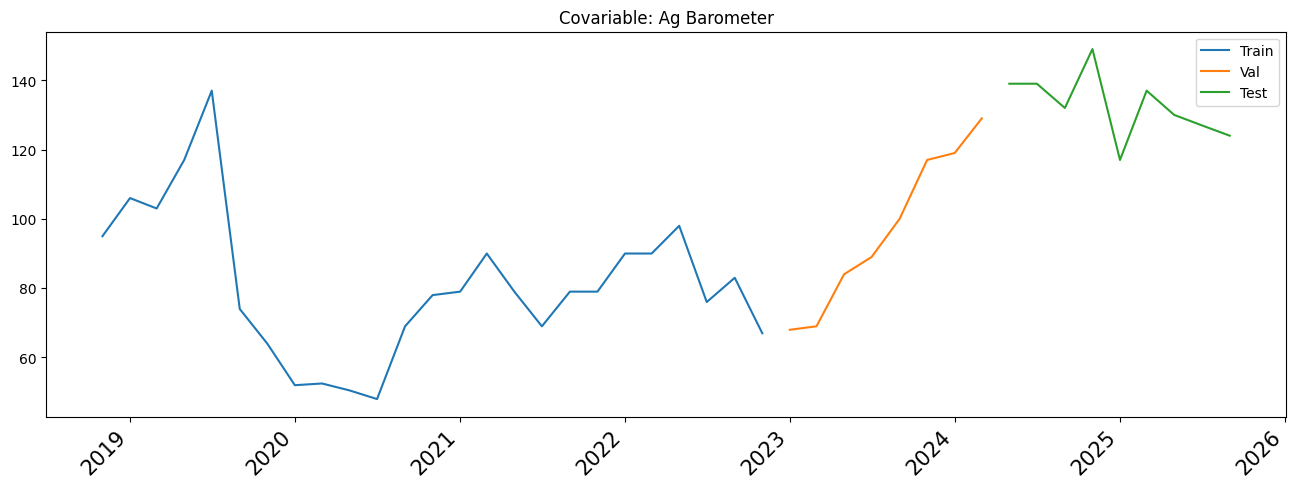

In [49]:
covar = 0 # Índice de la covariable (columna del dataset) a graficar
col = data_completa_1.columns[covar]

# Dibujar los sets de entrenamiento/validación/prueba para la covariable
fig, ax = plt.subplots(figsize = (16,5))
ax.plot(tr[col], label='Train')
ax.plot(vl[col], label='Val')
ax.plot(ts[col], label='Test')
ax.set_title(f'Covariable: {col}')
plt.xticks(rotation=45, ha='right')
plt.xticks(fontsize = 15)
plt.legend();

In [50]:
# Prueba de la función
tr, vl, ts = train_val_test_split(data_completa_1, tr_size= 0.6, vl_size= 0.2, ts_size=0.2)

print(f'Tamaño set de entrenamiento: {tr.shape}')
print(f'Tamaño set de validación: {vl.shape}')
print(f'Tamaño set de prueba: {ts.shape}')

Tamaño set de entrenamiento: (25, 8)
Tamaño set de validación: (8, 8)
Tamaño set de prueba: (9, 8)


Creamos los datasets de entrenamiento. Para este caso, debido a la baja cantidad de datos, trabajaremos con un input length de 3 y un output de 1. Si quisieramos pronosticar a periodos más alejados, podríamos hacer un multistep, pero ese caso nos restringiría aún más la cantidad de datos.

In [51]:
# Crear los datasets de entrenamiento, prueba y validación y verificar sus tamaños
INPUT_LENGTH = 3    # Hiperparámetro
OUTPUT_LENGTH = 1    # Modelo multi-step

x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH, col_index=0)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH, col_index=0)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH, col_index=0)

# Imprimir información en pantalla
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

# Escalamiento del dataset con la función anterior

# Crear diccionario de entrada
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

# Y escalar (especificando la columna con la variable a predecir)
data_s, scaler = escalar_dataset(data_in, col_ref = 'Ag Barometer', df = data_completa_1 )

# Extraer subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (22, 3, 8), y_tr: (22, 1, 1)
Set de validación - x_vl: (5, 3, 8), y_vl: (5, 1, 1)
Set de prueba - x_ts: (6, 3, 8), y_ts: (6, 1, 1)


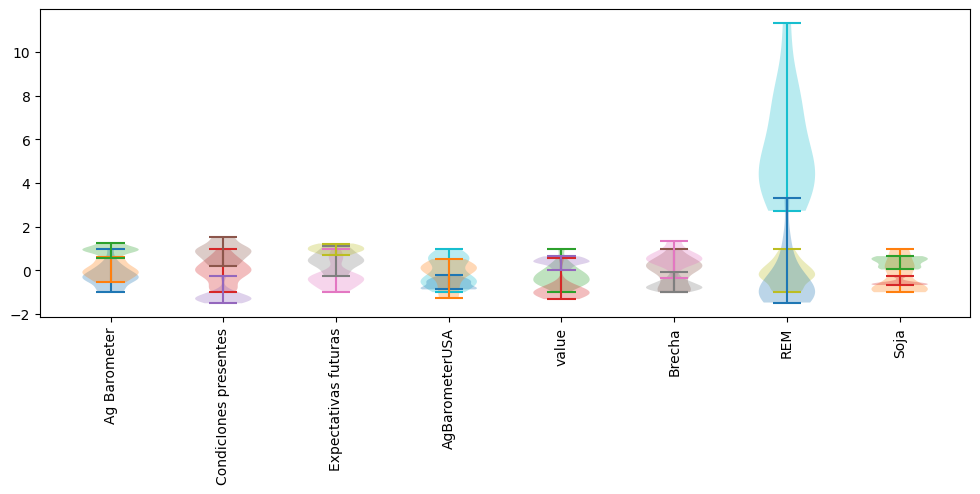

In [52]:
# Y generemos una gráfica tipo violín para ver la distribución
# de los valores en cada covariable (entrada) y en la variable a
# predecir (salida)

n = len(data_completa_1.columns)

fig, ax = plt.subplots(figsize=(12,4))
for i in range(n):
    ax.violinplot(dataset=x_tr_s[:,:,i].flatten(), positions=[i])
    ax.violinplot(dataset=x_vl_s[:,:,i].flatten(), positions=[i])
    ax.violinplot(dataset=x_ts_s[:,:,i].flatten(), positions=[i])

# Etiquetas eje horizontal
ax.set_xticks(list(range(n)))
ax.set_xticklabels(data_completa_1.keys(), rotation=90)
ax.autoscale();

La estandarización está basada en la función dada en clase, al estandarizar por datos de train, y dado que el REM se dispara en los datos de validación y test, nos produce los gráficos que sobresalen.

Definimos el INPUT SHAPE para poder trabajar.

In [53]:
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])

Y corremos una optimización utilizando optuna

In [54]:
# crear estudio y optimizar
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# resultados
print('Número de trials finalizados:', len(study.trials))
print('Mejor valor (val_loss):', study.best_value)
print('Mejores parámetros:')
for k, v in study.best_trial.params.items():
    print(f'  {k}: {v}')

# reentrenar con los datos de train+val usando los mejores hiperparámetros
best_params = study.best_trial.params
X_combined = np.vstack([x_tr_s, x_vl_s])
Y_combined = np.vstack([y_tr_s, y_vl_s])

final_model = Sequential()
final_model.add(Input(shape=INPUT_SHAPE))
[final_model.add(LSTM(best_params['n_units'], activation=best_params['activation'], return_sequences=True)) for _ in range(best_params['num']-1)]
final_model.add(LSTM(best_params['n_units'], activation=best_params['activation']))
final_model.add(Dense(OUTPUT_LENGTH, activation='linear'))
final_model.compile(optimizer=RMSprop(learning_rate=best_params['lr']),
                    loss=root_mean_squared_error,
                    metrics=['mape'])

final_model.fit(X_combined, Y_combined,
                epochs=50,
                batch_size=best_params['batch_size'],
                verbose=0)

rmse_test_opt = final_model.evaluate(x_ts_s, y_ts_s, verbose=0)
print(f'RMSE en test con modelo optimizado: {rmse_test_opt[0]:.3f}, MAPE en test con modelo optimizado: {rmse_test_opt[1]:.3f}')

[I 2026-02-21 10:47:32,201] A new study created in memory with name: no-name-3736dd3a-131a-4003-a137-1c10cfa85434


[I 2026-02-21 10:47:34,835] Trial 0 finished with value: 0.37224745750427246 and parameters: {'n_units': 192, 'lr': 0.00019608049331650422, 'batch_size': 256, 'activation': 'relu', 'num': 1, 'epochs': 340}. Best is trial 0 with value: 0.37224745750427246.
[I 2026-02-21 10:47:37,653] Trial 1 finished with value: 0.509147584438324 and parameters: {'n_units': 96, 'lr': 0.00016566703846765857, 'batch_size': 256, 'activation': 'tanh', 'num': 3, 'epochs': 150}. Best is trial 0 with value: 0.37224745750427246.
[I 2026-02-21 10:47:42,275] Trial 2 finished with value: 0.5302428603172302 and parameters: {'n_units': 32, 'lr': 0.0004845338013392551, 'batch_size': 256, 'activation': 'tanh', 'num': 4, 'epochs': 360}. Best is trial 0 with value: 0.37224745750427246.
[I 2026-02-21 10:47:44,643] Trial 3 finished with value: 0.4902285933494568 and parameters: {'n_units': 48, 'lr': 2.8988905665986014e-05, 'batch_size': 256, 'activation': 'relu', 'num': 1, 'epochs': 340}. Best is trial 0 with value: 0.372

Número de trials finalizados: 100
Mejor valor (val_loss): 0.15665218234062195
Mejores parámetros:
  n_units: 32
  lr: 0.0009116797574509663
  batch_size: 256
  activation: tanh
  num: 1
  epochs: 390
RMSE en test con modelo optimizado: 0.915, MAPE en test con modelo optimizado: 103.109



Resultados:
MAPE: 29.59%


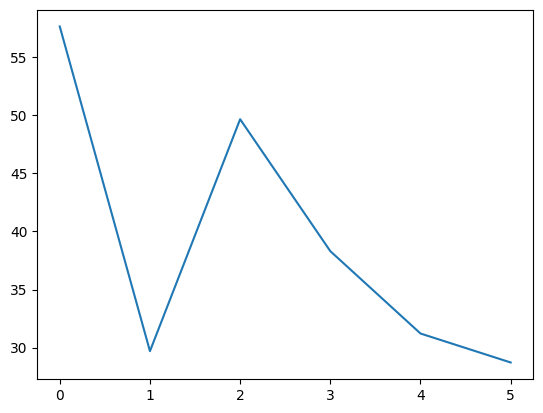

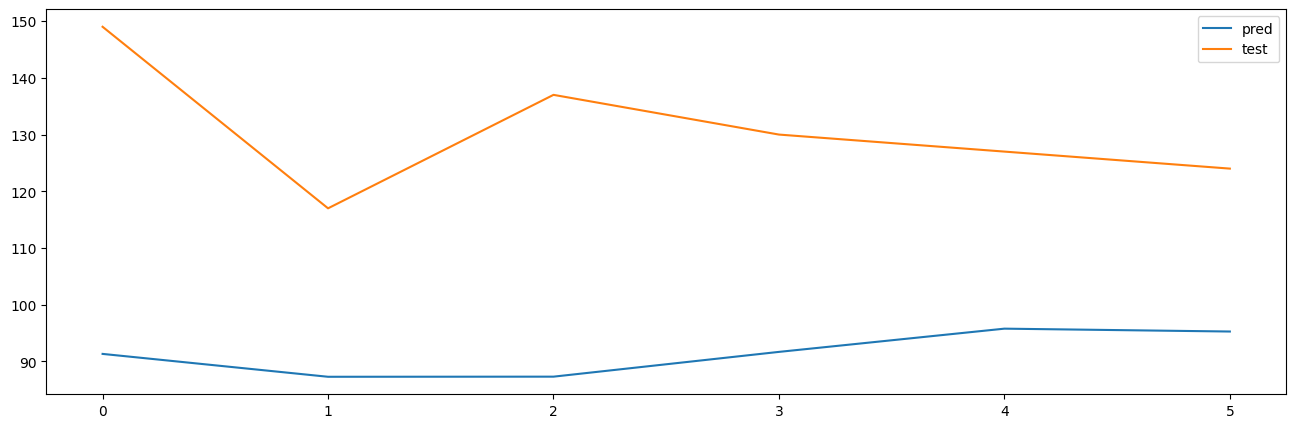

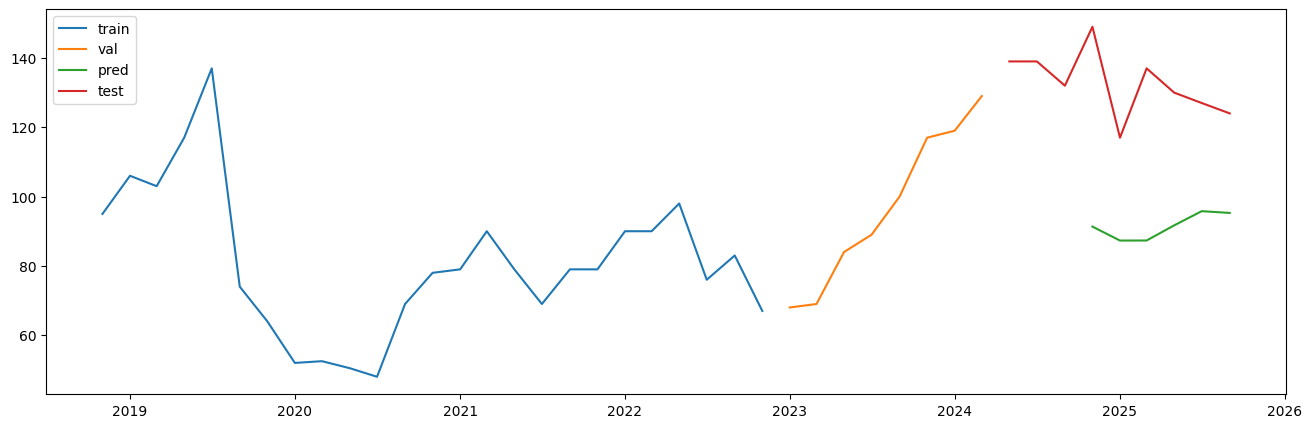

In [55]:
# concatenar las dos subseries
tr_vl = pd.concat([tr, vl])

y_ts_pred = predecir(x_ts_s, final_model, scaler)


# asignar los últimos 5 índices de `ts` a las predicciones
idx = ts.index[-len(y_ts_pred):]               # debería ser 5 índices
df_pred = pd.DataFrame({'y_ts_pred': y_ts_pred},
                       index=idx)


N = len(y_ts_pred)    # Número de predicciones (tamaño del set de prueba)
ndato = np.linspace(1,N,N)

mape = np.mean(np.abs((y_ts.flatten() - y_ts_pred) / y_ts.flatten())) * 100

print(f"\nResultados:")
print(f"MAPE: {mape:.2f}%")

# Cálculo de errores simples
errores = y_ts.flatten()-y_ts_pred
plt.plot(errores);
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(y_ts_pred,label="pred")
ax.plot(y_ts.flatten(),label="test")
plt.legend();
# si se quiere verificar gráficamente
plt.figure(figsize=(16,5))
plt.plot(tr['Ag Barometer'], label='train')
plt.plot(vl['Ag Barometer'], label='val')
plt.plot(df_pred,label="pred")
plt.plot(ts['Ag Barometer'],label="test")
plt.legend()

Como podíamos esperar, la faltante de datos y un patrón no muy claro, hace que aún buscando optimizar la red, tengamos una escasa generalización del modelo.

Para comparar con el trabajo número 1. Podemos realizar dos nuevos cambios. El primero es buscar predecir recursivamente usando las predicciones y las variables exógenas como conocidas y la otra opción, hacer multistep pero con el pasado conocido, sin reutilizar las predicciones como input, es decir, un rolling forecast similar al caso mostrado pero de un step >1

### Recursivo

#### Single step

In [58]:
# Prueba de la función
tr, vl, ts = train_val_test_split(data_completa_1, tr_size= 0.6, vl_size= 0.2, ts_size=0.2)

print(f'Tamaño set de entrenamiento: {tr.shape}')
print(f'Tamaño set de validación: {vl.shape}')
print(f'Tamaño set de prueba: {ts.shape}')

Tamaño set de entrenamiento: (25, 8)
Tamaño set de validación: (8, 8)
Tamaño set de prueba: (9, 8)


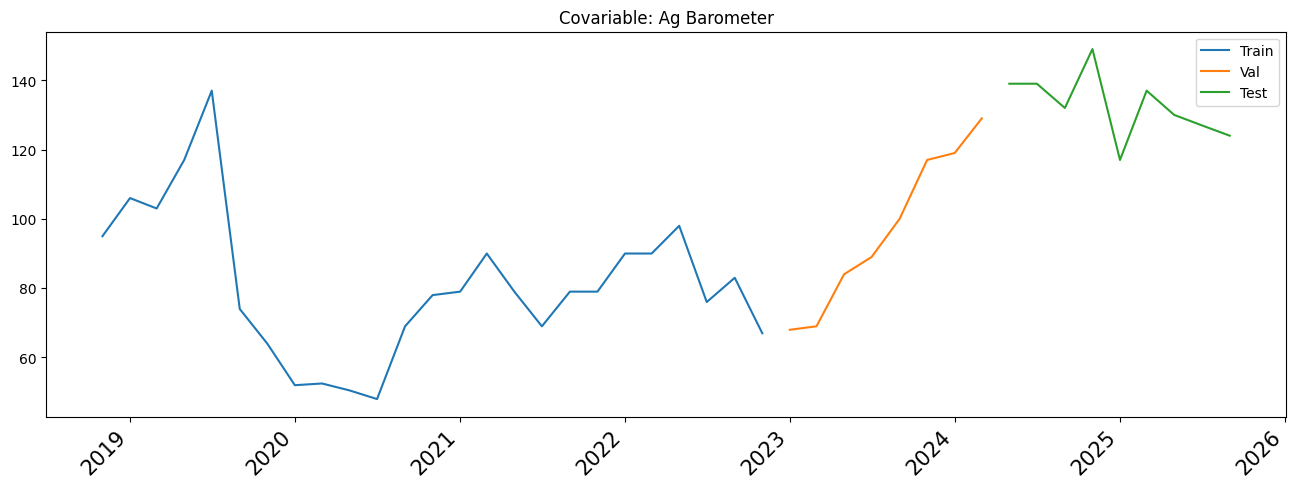

In [59]:
covar = 0 # Índice de la covariable (columna del dataset) a graficar
col = data_completa_1.columns[covar]

# Dibujar los sets de entrenamiento/validación/prueba para la covariable
fig, ax = plt.subplots(figsize = (16,5))
ax.plot(tr[col], label='Train')
ax.plot(vl[col], label='Val')
ax.plot(ts[col], label='Test')
ax.set_title(f'Covariable: {col}')
plt.xticks(rotation=45, ha='right')
plt.xticks(fontsize = 15)
plt.legend();

Iniciando predicción por bloques con IN=3, OUT=1...

Dimensiones finales:
Predicción continua: (6,)
Datos reales alineados: (6,)

Resultados de Predicción Recursiva (Bloques):
MAE:  47.3966
RMSE: 48.2209
MAPE: 36.00%


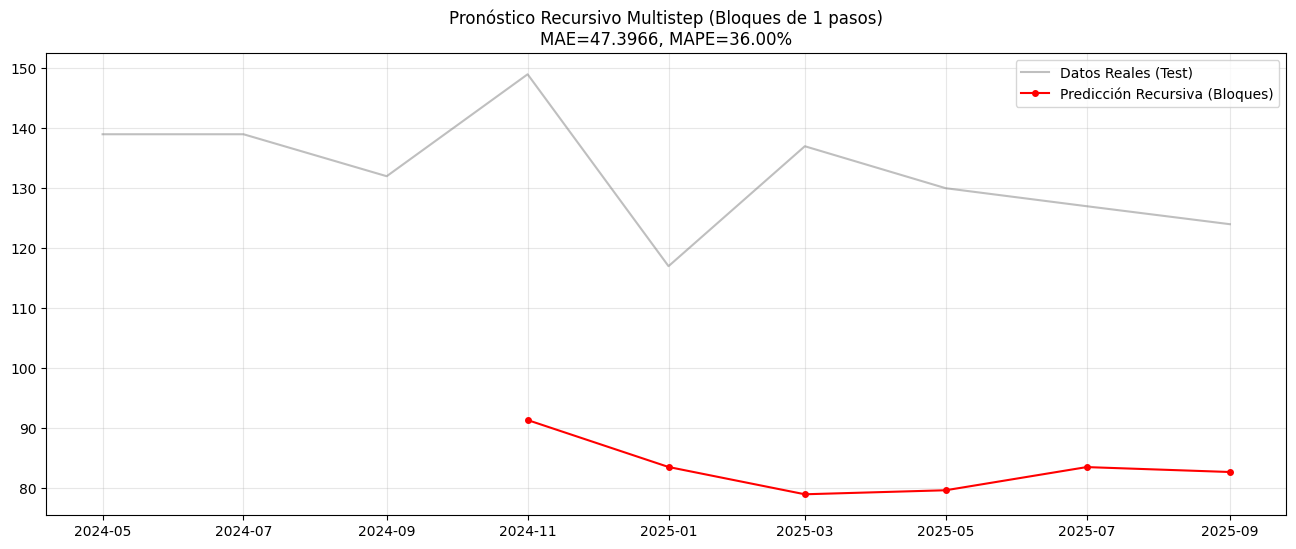

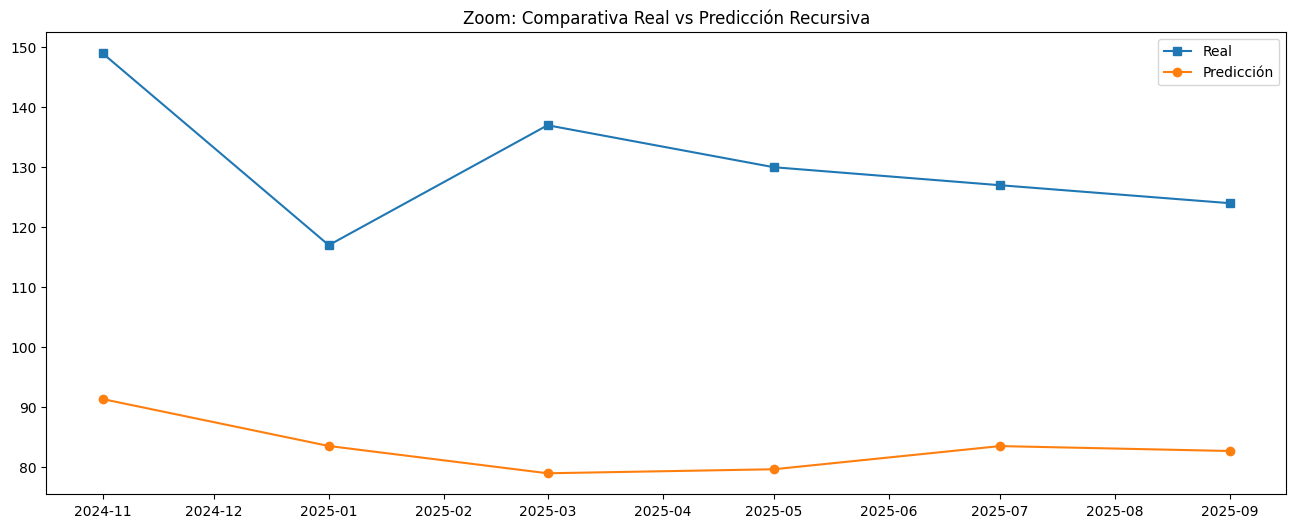

In [ ]:
# -------------------------------------------------------------------------
# EJECUCIÓN Y VISUALIZACIÓN
# -------------------------------------------------------------------------

print(f"Iniciando predicción por bloques con IN={INPUT_LENGTH}, OUT={OUTPUT_LENGTH}...")

# Ejecutar la nueva función
y_ts_pred_continuous = predecir_recursivo_bloques(x_ts_s, final_model, scaler, INPUT_LENGTH, OUTPUT_LENGTH)

# --- AJUSTE DE LONGITUDES ---
# Como predecimos en bloques, podemos pasarnos un poco del largo real de test.
# Recortamos para que coincida exactamente con el largo de y_ts (datos reales)
limit_len = len(y_ts) # Asumiendo que y_ts tiene forma (n_muestras, OUTPUT_LENGTH, 1) o similar
# Ojo: y_ts usualmente tiene overlap. Necesitamos el array plano de valores reales para comparar.
# Vamos a reconstruir el vector de tiempo real para comparar peras con peras.

# Asumiendo que 'ts' es tu dataframe de test original con los valores reales
y_real_vector = ts['Ag Barometer'].values[-len(y_ts_pred_continuous):] 

# Si la predicción es más larga que los datos reales disponibles (por el último bloque), recortamos la predicción
if len(y_ts_pred_continuous) > len(y_real_vector):
    y_ts_pred_continuous = y_ts_pred_continuous[:len(y_real_vector)]
# Si es al revés, recortamos el real
elif len(y_real_vector) > len(y_ts_pred_continuous):
    y_real_vector = y_real_vector[:len(y_ts_pred_continuous)]

# Obtener índices para graficar
idx_plot = ts.index[-len(y_ts_pred_continuous):]

print(f"\nDimensiones finales:")
print(f"Predicción continua: {y_ts_pred_continuous.shape}")
print(f"Datos reales alineados: {y_real_vector.shape}")

# --- MÉTRICAS ---
mae = mean_absolute_error(y_real_vector, y_ts_pred_continuous)
rmse = np.sqrt(mean_squared_error(y_real_vector, y_ts_pred_continuous))
mape = np.mean(np.abs((y_real_vector - y_ts_pred_continuous) / y_real_vector)) * 100

print(f"\nResultados de Predicción Recursiva (Bloques):")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

# --- VISUALIZACIÓN ---
plt.figure(figsize=(16, 6))

# Serie original (Train + Test real)
plt.plot(ts.index, ts['Ag Barometer'], label='Datos Reales (Test)', color='gray', alpha=0.5)

# Predicción recursiva
plt.plot(idx_plot, y_ts_pred_continuous, label='Predicción Recursiva (Bloques)', color='red', marker='o', markersize=4)

plt.title(f'Pronóstico Recursivo Multistep (Bloques de {OUTPUT_LENGTH} pasos)\nMAE={mae:.4f}, MAPE={mape:.2f}%')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Zoom a la zona de predicción
plt.figure(figsize=(16, 6))
plt.plot(idx_plot, y_real_vector, label='Real', marker='s')
plt.plot(idx_plot, y_ts_pred_continuous, label='Predicción', marker='o')
plt.title("Zoom: Comparativa Real vs Predicción Recursiva")
plt.legend()
plt.show()

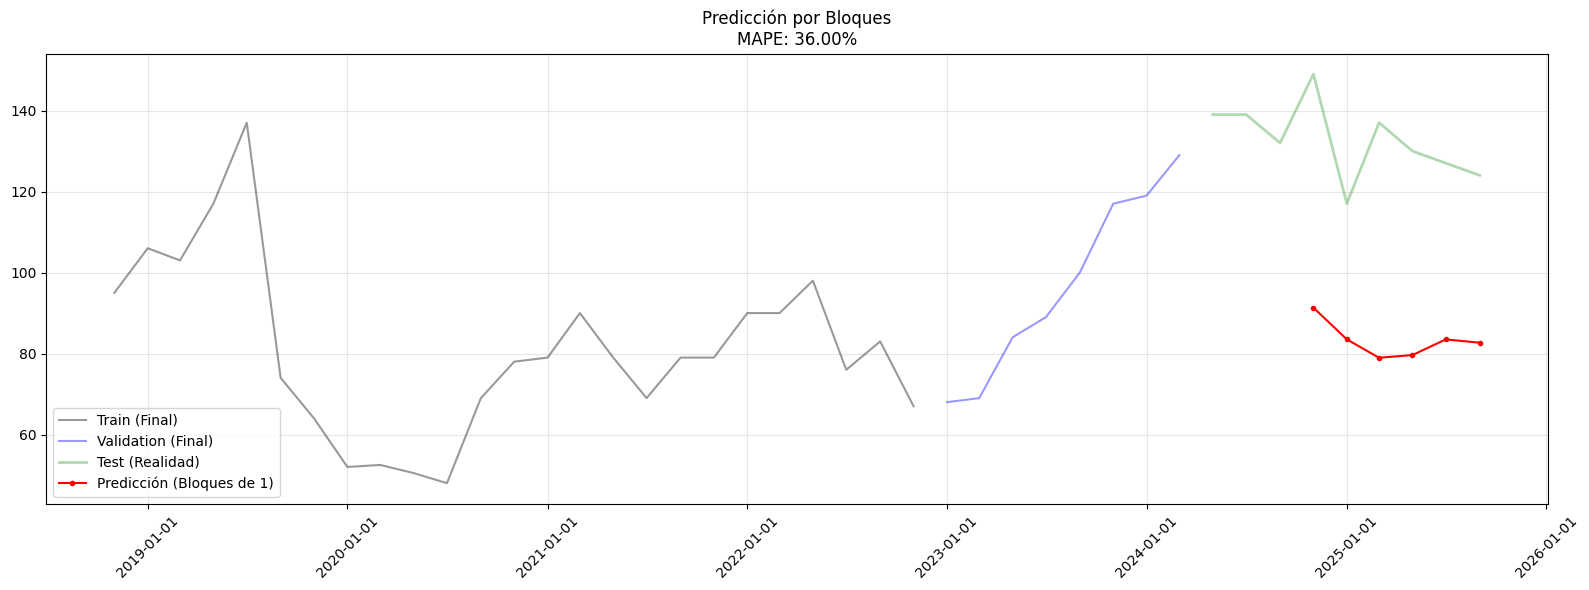

In [58]:
# --- 1. Crear el índice correcto para las predicciones ---
# Las predicciones comienzan después de la primera ventana de input.
# Si x_ts_s se creó desde 'ts', la primera predicción corresponde al índice en:
# ts.index[INPUT_LENGTH] (aprox, depende de cómo creaste las secuencias)

# La forma más segura es tomar el final del índice de ts:
# Como predecimos recursivamente "hacia adelante" llenando el test:
total_preds = len(y_ts_pred_continuous)
idx_pred = ts.index[-total_preds:] # Asignamos las fechas del final de test a nuestras predicciones

df_pred = pd.DataFrame({'y_ts_pred': y_ts_pred_continuous}, index=idx_pred)

# --- 2. Visualización Corregida ---
import matplotlib.dates as mdates

plt.figure(figsize=(16, 6))

# A. Datos de Entrenamiento (Últimos 100 puntos para ver la unión)
# No graficamos todo el train para hacer zoom en la transición
plt.plot(tr.index[-50:], tr['Ag Barometer'][-50:], label='Train (Final)', color='black', alpha=0.4)

plt.plot(vl.index[-50:], vl['Ag Barometer'][-50:], label='Validation (Final)', color='blue', alpha=0.4)

# B. Datos de Test (Realidad Completa)
plt.plot(ts.index, ts['Ag Barometer'], label="Test (Realidad)", color='green', alpha=0.3, linewidth=2)


# C. Predicción Recursiva (Encima del Test)
plt.plot(df_pred.index, df_pred['y_ts_pred'], label=f"Predicción (Bloques de {OUTPUT_LENGTH})", color='red', marker='o', markersize=3)

# D. Estética y Formato
plt.title(f'Predicción por Bloques\nMAPE: {mape:.2f}%')
plt.legend()
plt.grid(True, alpha=0.3)

# Formato de fecha en eje X para que no se amontone
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### Multi step

Debido a la falta de datos, procedemos a hacer un multistep sin datos de validación. No es la situación ideal, pero caso contrario son muchos los datos que se pierden

In [59]:
# Prueba de la función
tr, vl, ts = train_val_test_split(data_completa_1, tr_size= 0.8, vl_size= 0, ts_size=0.2)

print(f'Tamaño set de entrenamiento: {tr.shape}')
print(f'Tamaño set de validación: {vl.shape}')
print(f'Tamaño set de prueba: {ts.shape}')

Tamaño set de entrenamiento: (33, 8)
Tamaño set de validación: (0, 8)
Tamaño set de prueba: (9, 8)


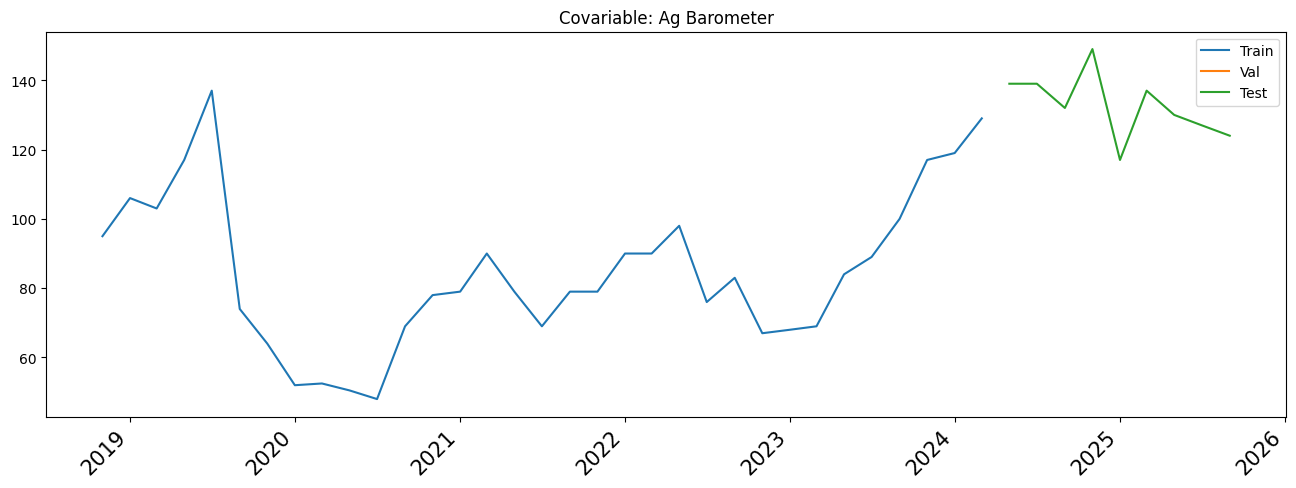

In [60]:
covar = 0 # Índice de la covariable (columna del dataset) a graficar
col = data_completa_1.columns[covar]

# Dibujar los sets de entrenamiento/validación/prueba para la covariable
fig, ax = plt.subplots(figsize = (16,5))
ax.plot(tr[col], label='Train')
ax.plot(vl[col], label='Val')
ax.plot(ts[col], label='Test')
ax.set_title(f'Covariable: {col}')
plt.xticks(rotation=45, ha='right')
plt.xticks(fontsize = 15)
plt.legend();

In [61]:
# Crear los datasets de entrenamiento, prueba y validación y verificar sus tamaños
INPUT_LENGTH = 3    # Hiperparámetro
OUTPUT_LENGTH = 3    # Modelo multi-step

x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH, col_index=0)
#x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH, col_index=2)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH, col_index=0)

# Imprimir información en pantalla
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
#print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

# Escalamiento del dataset con la función anterior

# Crear diccionario de entrada
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
#    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

# Y escalar (especificando la columna con la variable a predecir)
data_s, scaler = escalar_dataset_no_val(data_in, col_ref = 'Ag Barometer', df = data_completa_1 )

# Extraer subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
#x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (28, 3, 8), y_tr: (28, 3, 1)
Set de prueba - x_ts: (4, 3, 8), y_ts: (4, 3, 1)


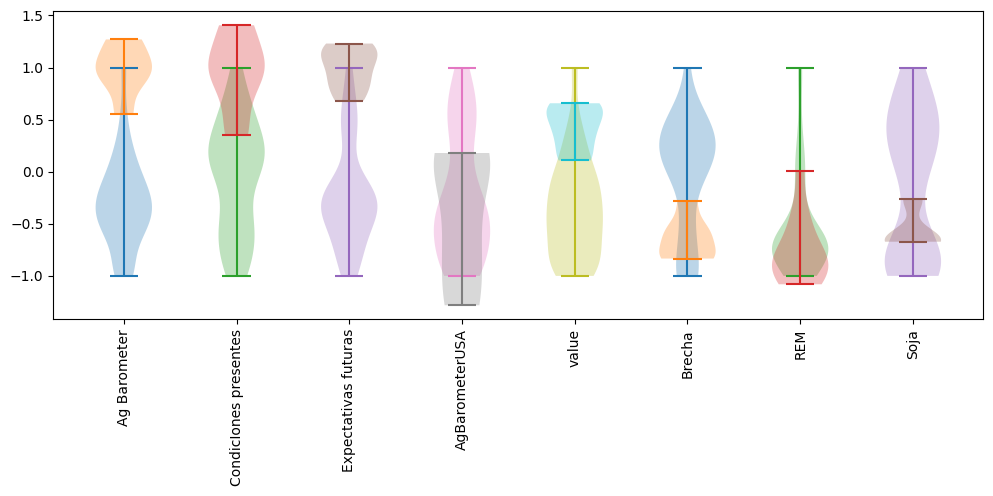

In [62]:
# Y generemos una gráfica tipo violín para ver la distribución
# de los valores en cada covariable (entrada) y en la variable a
# predecir (salida)

n = len(data_completa_1.columns)

fig, ax = plt.subplots(figsize=(12,4))
for i in range(n):
    ax.violinplot(dataset=x_tr_s[:,:,i].flatten(), positions=[i])
    ax.violinplot(dataset=x_ts_s[:,:,i].flatten(), positions=[i])

# Etiquetas eje horizontal
ax.set_xticks(list(range(n)))
ax.set_xticklabels(data_completa_1.keys(), rotation=90)
ax.autoscale();

In [63]:
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])

In [64]:
# crear estudio y optimizar
study = optuna.create_study(direction='minimize')
study.optimize(objective_no_val, n_trials=100)

# resultados
print('Número de trials finalizados:', len(study.trials))
print('Mejor valor (val_loss):', study.best_value)
print('Mejores parámetros:')
for k, v in study.best_trial.params.items():
    print(f'  {k}: {v}')

# reentrenar con los datos de train+val usando los mejores hiperparámetros
best_params = study.best_trial.params

final_model = Sequential()
final_model.add(Input(shape=INPUT_SHAPE))
[final_model.add(LSTM(best_params['n_units'], activation=best_params['activation'], return_sequences=True)) for _ in range(best_params['num']-1)]
final_model.add(LSTM(best_params['n_units'], activation=best_params['activation']))
final_model.add(Dense(OUTPUT_LENGTH, activation='linear'))
final_model.compile(optimizer=RMSprop(learning_rate=best_params['lr']),
                    loss=root_mean_squared_error,
                    metrics=['mape'])

final_model.fit(x_tr_s, y_tr_s,
                epochs=50,
                batch_size=best_params['batch_size'],
                verbose=0)

rmse_test_opt = final_model.evaluate(x_ts_s, y_ts_s, verbose=0)
print(f'RMSE en test con modelo optimizado: {rmse_test_opt[0]:.3f}, MAPE en test con modelo optimizado: {rmse_test_opt[1]:.3f}')

[I 2026-02-21 10:54:08,403] A new study created in memory with name: no-name-a33adaae-075f-4ab9-bf2b-262d28565c44
[I 2026-02-21 10:54:16,444] Trial 0 finished with value: 0.16363386809825897 and parameters: {'n_units': 160, 'lr': 0.002008036310818191, 'batch_size': 256, 'activation': 'tanh', 'num': 3, 'epochs': 250}. Best is trial 0 with value: 0.16363386809825897.
[I 2026-02-21 10:54:21,132] Trial 1 finished with value: 0.15735502541065216 and parameters: {'n_units': 96, 'lr': 0.0064738996949306625, 'batch_size': 256, 'activation': 'tanh', 'num': 3, 'epochs': 130}. Best is trial 1 with value: 0.15735502541065216.
[I 2026-02-21 10:54:37,308] Trial 2 finished with value: 0.07711533457040787 and parameters: {'n_units': 32, 'lr': 0.0006939095246504914, 'batch_size': 256, 'activation': 'relu', 'num': 1, 'epochs': 360}. Best is trial 2 with value: 0.07711533457040787.
[I 2026-02-21 10:55:04,145] Trial 3 finished with value: 0.14686055481433868 and parameters: {'n_units': 176, 'lr': 0.000667

Número de trials finalizados: 100
Mejor valor (val_loss): 0.03991808369755745
Mejores parámetros:
  n_units: 80
  lr: 0.009556988409816626
  batch_size: 256
  activation: relu
  num: 1
  epochs: 300
RMSE en test con modelo optimizado: 1.987, MAPE en test con modelo optimizado: 229.222


Iniciando predicción por bloques con IN=3, OUT=3...

Dimensiones finales:
Predicción continua: (6,)
Datos reales alineados: (6,)

Resultados de Predicción Recursiva (Bloques):
MAE:  68.6383
RMSE: 69.7860
MAPE: 52.60%


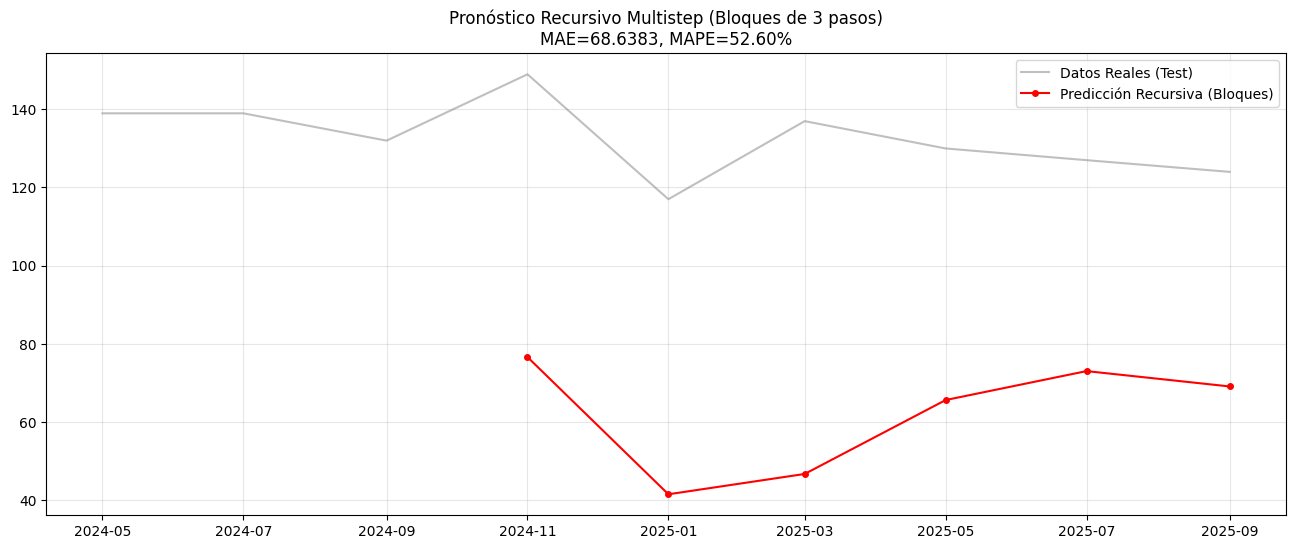

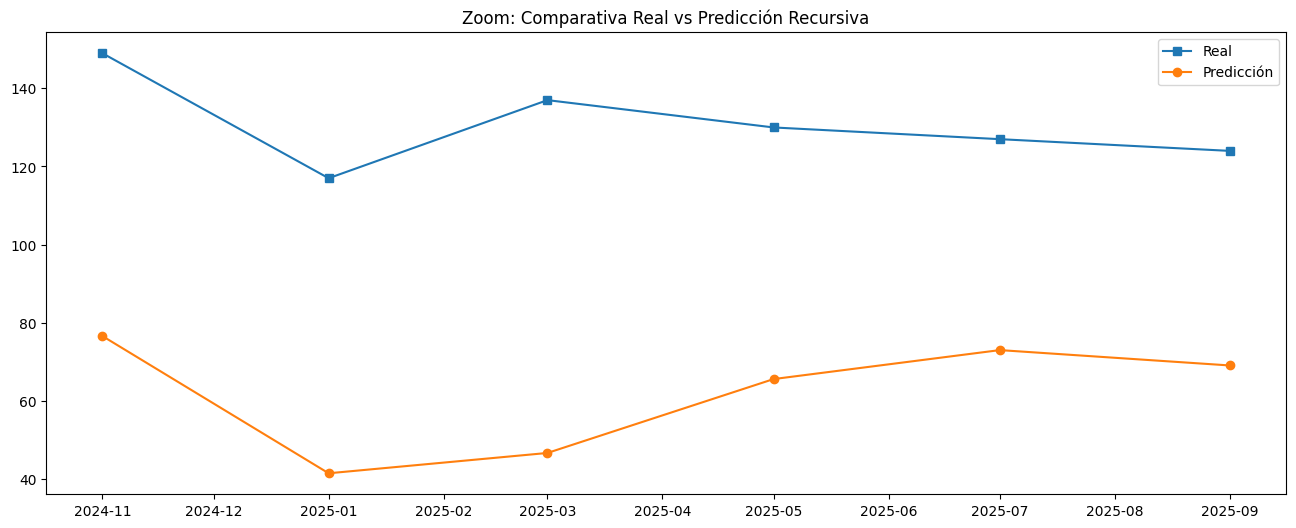

In [ ]:
# -------------------------------------------------------------------------
# EJECUCIÓN Y VISUALIZACIÓN
# -------------------------------------------------------------------------

print(f"Iniciando predicción por bloques con IN={INPUT_LENGTH}, OUT={OUTPUT_LENGTH}...")

# Ejecutar la nueva función
y_ts_pred_continuous = predecir_recursivo_bloques(x_ts_s, final_model, scaler, INPUT_LENGTH, OUTPUT_LENGTH)

# --- AJUSTE DE LONGITUDES ---
# Como predecimos en bloques, podemos pasarnos un poco del largo real de test.
# Recortamos para que coincida exactamente con el largo de y_ts (datos reales)
limit_len = len(y_ts) # Asumiendo que y_ts tiene forma (n_muestras, OUTPUT_LENGTH, 1) o similar
# Ojo: y_ts usualmente tiene overlap. Necesitamos el array plano de valores reales para comparar.
# Vamos a reconstruir el vector de tiempo real para comparar peras con peras.

# Asumiendo que 'ts' es tu dataframe de test original con los valores reales
y_real_vector = ts['Ag Barometer'].values[-len(y_ts_pred_continuous):] 

# Si la predicción es más larga que los datos reales disponibles (por el último bloque), recortamos la predicción
if len(y_ts_pred_continuous) > len(y_real_vector):
    y_ts_pred_continuous = y_ts_pred_continuous[:len(y_real_vector)]
# Si es al revés, recortamos el real
elif len(y_real_vector) > len(y_ts_pred_continuous):
    y_real_vector = y_real_vector[:len(y_ts_pred_continuous)]

# Obtener índices para graficar
idx_plot = ts.index[-len(y_ts_pred_continuous):]

print(f"\nDimensiones finales:")
print(f"Predicción continua: {y_ts_pred_continuous.shape}")
print(f"Datos reales alineados: {y_real_vector.shape}")

# --- MÉTRICAS ---
mae = mean_absolute_error(y_real_vector, y_ts_pred_continuous)
rmse = np.sqrt(mean_squared_error(y_real_vector, y_ts_pred_continuous))
mape = np.mean(np.abs((y_real_vector - y_ts_pred_continuous) / y_real_vector)) * 100

print(f"\nResultados de Predicción Recursiva (Bloques):")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

# --- VISUALIZACIÓN ---
plt.figure(figsize=(16, 6))

# Serie original (Train + Test real)
plt.plot(ts.index, ts['Ag Barometer'], label='Datos Reales (Test)', color='gray', alpha=0.5)

# Predicción recursiva
plt.plot(idx_plot, y_ts_pred_continuous, label='Predicción Recursiva (Bloques)', color='red', marker='o', markersize=4)

plt.title(f'Pronóstico Recursivo Multistep (Bloques de {OUTPUT_LENGTH} pasos)\nMAE={mae:.4f}, MAPE={mape:.2f}%')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Zoom a la zona de predicción
plt.figure(figsize=(16, 6))
plt.plot(idx_plot, y_real_vector, label='Real', marker='s')
plt.plot(idx_plot, y_ts_pred_continuous, label='Predicción', marker='o')
plt.title("Zoom: Comparativa Real vs Predicción Recursiva")
plt.legend()
plt.show()

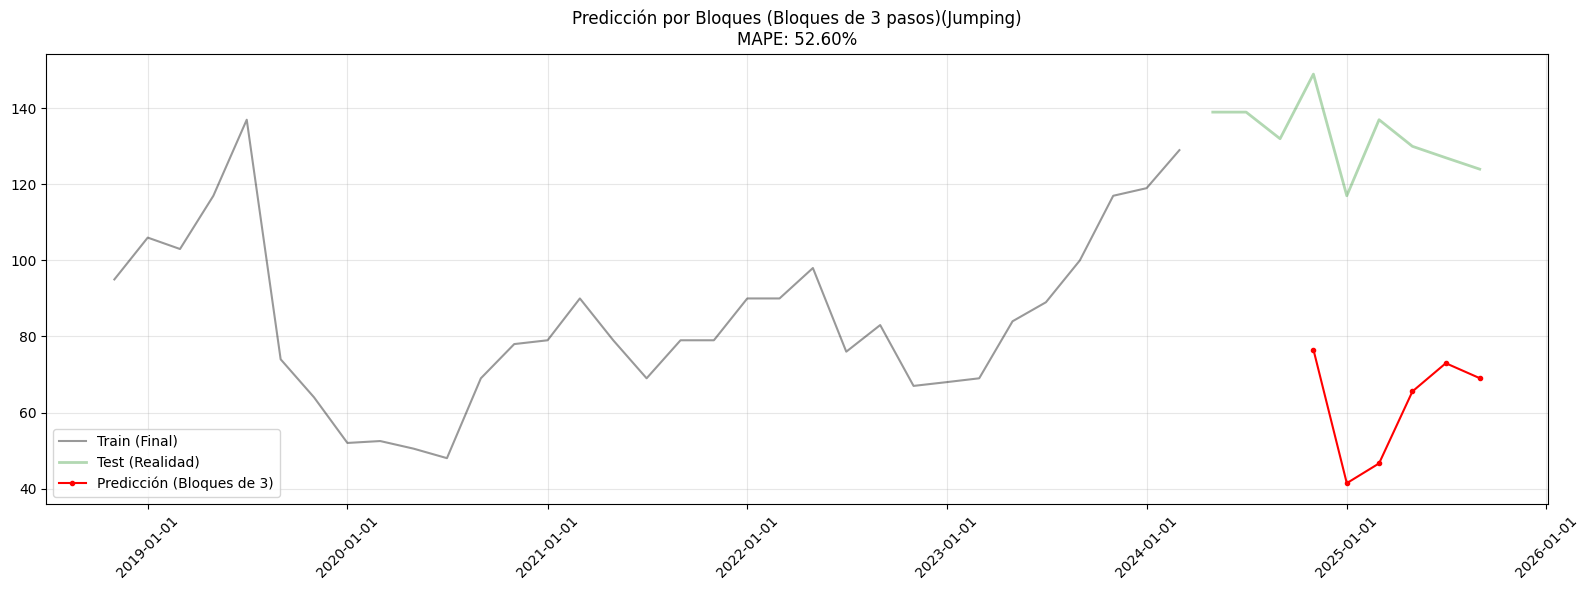

In [67]:
# --- 1. Crear el índice correcto para las predicciones ---
# Las predicciones comienzan después de la primera ventana de input.
# Si x_ts_s se creó desde 'ts', la primera predicción corresponde al índice en:
# ts.index[INPUT_LENGTH] (aprox, depende de cómo creaste las secuencias)

# La forma más segura es tomar el final del índice de ts:
# Como predecimos recursivamente "hacia adelante" llenando el test:
total_preds = len(y_ts_pred_continuous)
idx_pred = ts.index[-total_preds:] # Asignamos las fechas del final de test a nuestras predicciones

df_pred = pd.DataFrame({'y_ts_pred': y_ts_pred_continuous}, index=idx_pred)

# --- 2. Visualización Corregida ---
import matplotlib.dates as mdates

plt.figure(figsize=(16, 6))

# A. Datos de Entrenamiento (Últimos 100 puntos para ver la unión)
# No graficamos todo el train para hacer zoom en la transición
plt.plot(tr.index[-50:], tr['Ag Barometer'][-50:], label='Train (Final)', color='black', alpha=0.4)

# B. Datos de Test (Realidad Completa)
plt.plot(ts.index, ts['Ag Barometer'], label="Test (Realidad)", color='green', alpha=0.3, linewidth=2)

# C. Predicción Recursiva (Encima del Test)
plt.plot(df_pred.index, df_pred['y_ts_pred'], label=f"Predicción (Bloques de {OUTPUT_LENGTH})", color='red', marker='o', markersize=3)

# D. Estética y Formato
plt.title(f'Predicción por Bloques (Bloques de {OUTPUT_LENGTH} pasos)(Jumping)\nMAPE: {mape:.2f}%')
plt.legend()
plt.grid(True, alpha=0.3)

# Formato de fecha en eje X para que no se amontone
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### MultiStep Rolling Forecast

Iniciando Rolling Forecast (Reset con Real) con IN=3, OUT=3...

Dimensiones finales:
Predicción Rolling: (6,)
Datos reales:       (6,)

Resultados de Rolling Forecast (Actualización Real):
MAE:  79.6406
RMSE: 80.1420
MAPE: 61.23%


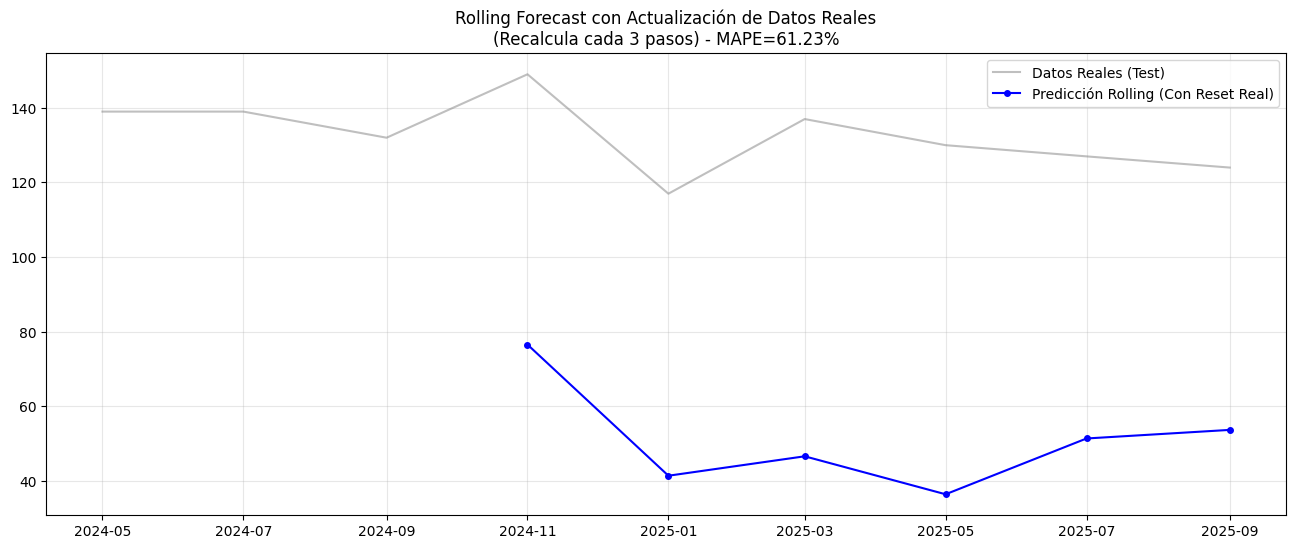

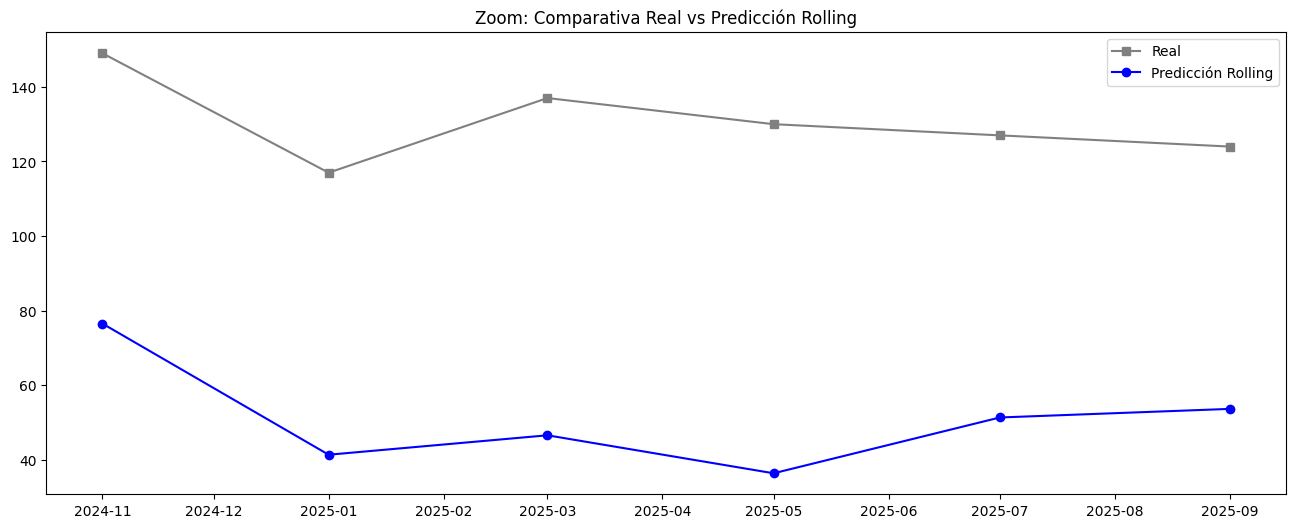

In [ ]:
# -------------------------------------------------------------------------
# EJECUCIÓN Y VISUALIZACIÓN
# -------------------------------------------------------------------------

print(f"Iniciando Rolling Forecast (Reset con Real) con IN={INPUT_LENGTH}, OUT={OUTPUT_LENGTH}...")

# Ejecutar la función MODIFICADA
y_ts_pred_rolling = predecir_con_actualizacion_real(x_ts_s, final_model, scaler, INPUT_LENGTH, OUTPUT_LENGTH)

# --- AJUSTE DE LONGITUDES ---
# Reconstruir vector real para comparación
y_real_vector = ts['Ag Barometer'].values[-len(y_ts_pred_rolling):] 

# Recortes por si el último bloque se pasa
if len(y_ts_pred_rolling) > len(y_real_vector):
    y_ts_pred_rolling = y_ts_pred_rolling[:len(y_real_vector)]
elif len(y_real_vector) > len(y_ts_pred_rolling):
    y_real_vector = y_real_vector[:len(y_ts_pred_rolling)]

# Obtener índices para graficar
idx_plot = ts.index[-len(y_ts_pred_rolling):]

print(f"\nDimensiones finales:")
print(f"Predicción Rolling: {y_ts_pred_rolling.shape}")
print(f"Datos reales:       {y_real_vector.shape}")

# --- MÉTRICAS ---
mae = mean_absolute_error(y_real_vector, y_ts_pred_rolling)
rmse = np.sqrt(mean_squared_error(y_real_vector, y_ts_pred_rolling))
mape = np.mean(np.abs((y_real_vector - y_ts_pred_rolling) / y_real_vector)) * 100

print(f"\nResultados de Rolling Forecast (Actualización Real):")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

# --- VISUALIZACIÓN ---
plt.figure(figsize=(16, 6))

# Serie original (Train + Test real)
plt.plot(ts.index, ts['Ag Barometer'], label='Datos Reales (Test)', color='gray', alpha=0.5)

# Predicción Rolling (Reset)
# Esta línea se verá "mejor" (más pegada al real) que la recursiva pura,
# porque corrige el rumbo cada OUTPUT_LENGTH pasos.
plt.plot(idx_plot, y_ts_pred_rolling, label='Predicción Rolling (Con Reset Real)', color='blue', marker='o', markersize=4)

plt.title(f'Rolling Forecast con Actualización de Datos Reales\n(Recalcula cada {OUTPUT_LENGTH} pasos) - MAPE={mape:.2f}%')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Zoom
plt.figure(figsize=(16, 6))
plt.plot(idx_plot, y_real_vector, label='Real', marker='s', color='gray')
plt.plot(idx_plot, y_ts_pred_rolling, label='Predicción Rolling', marker='o', color='blue')
plt.title("Zoom: Comparativa Real vs Predicción Rolling")
plt.legend()
plt.show()

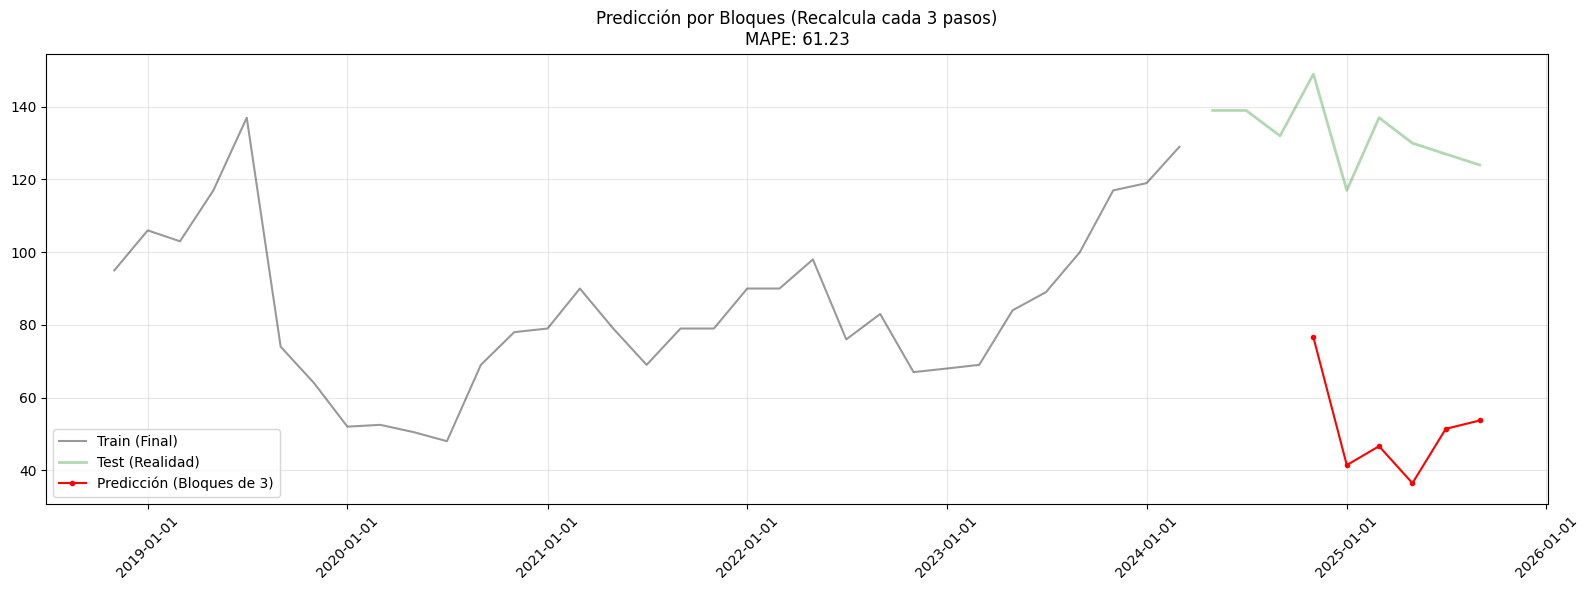

In [ ]:
# --- 1. Crear el índice correcto para las predicciones ---
# Las predicciones comienzan después de la primera ventana de input.
# Si x_ts_s se creó desde 'ts', la primera predicción corresponde al índice en:
# ts.index[INPUT_LENGTH] (aprox, depende de cómo creaste las secuencias)

# La forma más segura es tomar el final del índice de ts:
# Como predecimos recursivamente "hacia adelante" llenando el test:
total_preds = len(y_ts_pred_rolling)
idx_pred = ts.index[-total_preds:] # Asignamos las fechas del final de test a nuestras predicciones

df_pred = pd.DataFrame({'y_ts_pred': y_ts_pred_rolling}, index=idx_pred)

# --- 2. Visualización Corregida ---
import matplotlib.dates as mdates

plt.figure(figsize=(16, 6))

# A. Datos de Entrenamiento (Últimos 100 puntos para ver la unión)
# No graficamos todo el train para hacer zoom en la transición
plt.plot(tr.index[-50:], tr['Ag Barometer'][-50:], label='Train (Final)', color='black', alpha=0.4)

# B. Datos de Test (Realidad Completa)
plt.plot(ts.index, ts['Ag Barometer'], label="Test (Realidad)", color='green', alpha=0.3, linewidth=2)

# C. Predicción Recursiva (Encima del Test)
plt.plot(df_pred.index, df_pred['y_ts_pred'], label=f"Predicción (Bloques de {OUTPUT_LENGTH})", color='red', marker='o', markersize=3)

# D. Estética y Formato
plt.title(f'Predicción por Bloques (Recalcula cada {OUTPUT_LENGTH} pasos)\nMAPE: {mape:.2f}%')
plt.legend()
plt.grid(True, alpha=0.3)

# Formato de fecha en eje X para que no se amontone
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Análisis Ag Economy

In [72]:
# Prueba de la función
tr, vl, ts = train_val_test_split(df_ageconomy, tr_size= 0.6, vl_size= 0.2, ts_size=0.2)

print(f'Tamaño set de entrenamiento: {tr.shape}')
print(f'Tamaño set de validación: {vl.shape}')
print(f'Tamaño set de prueba: {ts.shape}')

Tamaño set de entrenamiento: (72, 4)
Tamaño set de validación: (24, 4)
Tamaño set de prueba: (25, 4)


Graficamos para ver los bloques separados

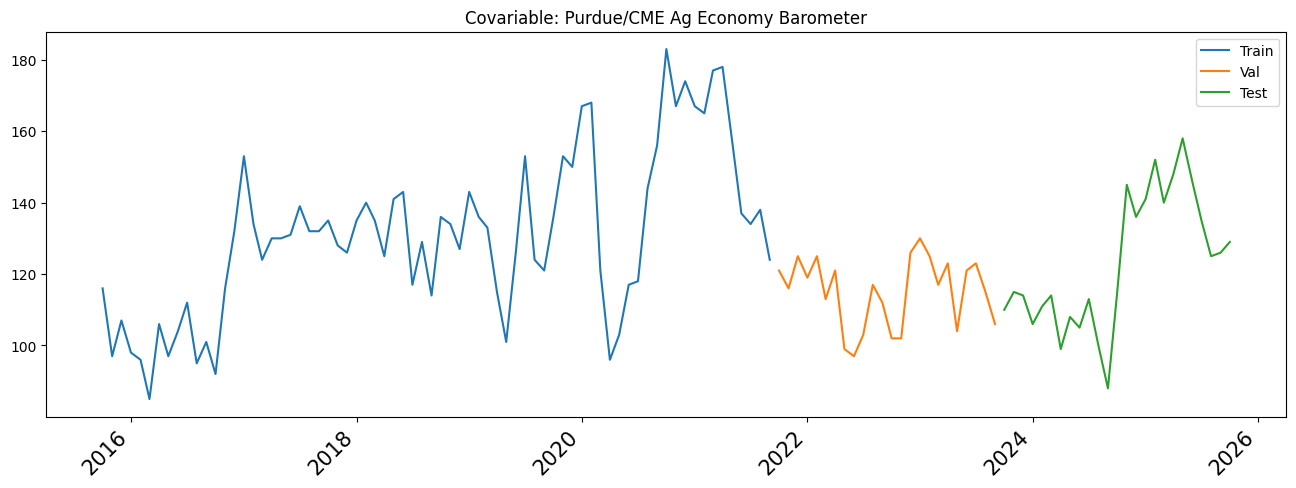

In [73]:
covar = 0 # Índice de la covariable (columna del dataset) a graficar
col = df_ageconomy.columns[covar]

# Dibujar los sets de entrenamiento/validación/prueba para la covariable
fig, ax = plt.subplots(figsize = (16,5))
ax.plot(tr[col], label='Train')
ax.plot(vl[col], label='Val')
ax.plot(ts[col], label='Test')
ax.set_title(f'Covariable: {col}')
plt.xticks(rotation=45, ha='right')
plt.xticks(fontsize = 15)
plt.legend();

In [74]:
tr = tr['Purdue/CME Ag Economy Barometer']
vl = vl['Purdue/CME Ag Economy Barometer']
ts = ts['Purdue/CME Ag Economy Barometer']

In [75]:
# Crear los datasets de entrenamiento, prueba y validación y verificar sus tamaños
INPUT_LENGTH = 5    # Hiperparámetro
OUTPUT_LENGTH = 1    # Modelo multi-step

x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH, col_index=0)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH, col_index=0)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH, col_index=0)

# Imprimir información en pantalla
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

# Escalamiento del dataset con la función anterior

# Crear diccionario de entrada
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

# Y escalar (especificando la columna con la variable a predecir)
data_s, scaler = escalar_dataset(data_in, col_ref = 'Purdue/CME Ag Economy Barometer', df = df_ageconomy )

# Extraer subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (67, 5, 1), y_tr: (67, 1, 1)
Set de validación - x_vl: (19, 5, 1), y_vl: (19, 1, 1)
Set de prueba - x_ts: (20, 5, 1), y_ts: (20, 1, 1)


In [76]:
n = len(df_ageconomy.columns)

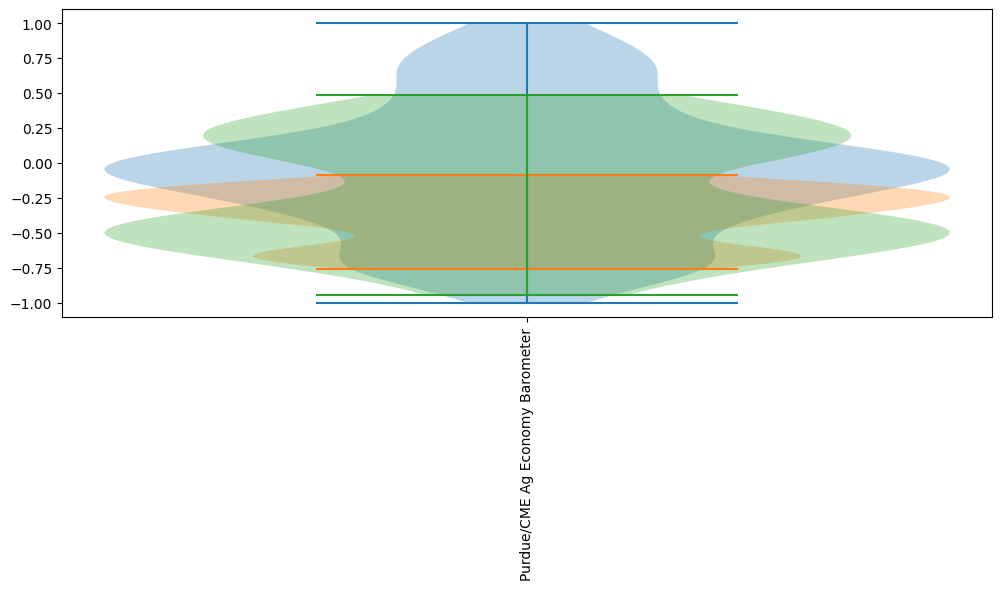

In [77]:
# Y generemos una gráfica tipo violín para ver la distribución
# de los valores en cada covariable (entrada) y en la variable a
# predecir (salida)

n = len(df_ageconomy.columns)

fig, ax = plt.subplots(figsize=(12,4))
# for i in range(n):
ax.violinplot(dataset=x_tr_s[:,:,0].flatten(), positions=[0])
ax.violinplot(dataset=x_vl_s[:,:,0].flatten(), positions=[0])
ax.violinplot(dataset=x_ts_s[:,:,0].flatten(), positions=[0])

# Etiquetas eje horizontal
ax.set_xticks(list(range(n)))
ax.set_xticklabels(df_ageconomy.keys(), rotation=90)
ax.autoscale();

In [78]:
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])

In [79]:
# crear estudio y optimizar
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# resultados
print('Número de trials finalizados:', len(study.trials))
print('Mejor valor (val_loss):', study.best_value)
print('Mejores parámetros:')
for k, v in study.best_trial.params.items():
    print(f'  {k}: {v}')

# reentrenar con los datos de train+val usando los mejores hiperparámetros
best_params = study.best_trial.params
X_combined = np.vstack([x_tr_s, x_vl_s])
Y_combined = np.vstack([y_tr_s, y_vl_s])

final_model = Sequential()
final_model.add(Input(shape=INPUT_SHAPE))
[final_model.add(LSTM(best_params['n_units'], activation=best_params['activation'], return_sequences=True)) for _ in range(best_params['num']-1)]
final_model.add(LSTM(best_params['n_units'], activation=best_params['activation']))
final_model.add(Dense(OUTPUT_LENGTH, activation='linear'))
final_model.compile(optimizer=RMSprop(learning_rate=best_params['lr']),
                    loss=root_mean_squared_error,
                    metrics=['mape'])

final_model.fit(X_combined, Y_combined,
                epochs=50,
                batch_size=best_params['batch_size'],
                verbose=0)

rmse_test_opt = final_model.evaluate(x_ts_s, y_ts_s, verbose=0)
print(f'RMSE en test con modelo optimizado: {rmse_test_opt[0]:.3f}, MAPE en test con modelo optimizado: {rmse_test_opt[1]:.3f}')

[I 2026-02-21 11:17:14,811] A new study created in memory with name: no-name-97a5bce3-7af0-4e69-b8c4-0a685043a9a9
[I 2026-02-21 11:17:28,238] Trial 0 finished with value: 0.36324888467788696 and parameters: {'n_units': 16, 'lr': 0.00014921886765491637, 'batch_size': 256, 'activation': 'tanh', 'num': 2, 'epochs': 170}. Best is trial 0 with value: 0.36324888467788696.
[I 2026-02-21 11:17:38,955] Trial 1 finished with value: 0.24001213908195496 and parameters: {'n_units': 16, 'lr': 0.002153356242150445, 'batch_size': 256, 'activation': 'relu', 'num': 2, 'epochs': 380}. Best is trial 1 with value: 0.24001213908195496.
[I 2026-02-21 11:17:49,135] Trial 2 finished with value: 0.44735562801361084 and parameters: {'n_units': 160, 'lr': 2.11439995417622e-05, 'batch_size': 256, 'activation': 'relu', 'num': 2, 'epochs': 110}. Best is trial 1 with value: 0.24001213908195496.
[I 2026-02-21 11:18:06,979] Trial 3 finished with value: 0.43785908818244934 and parameters: {'n_units': 144, 'lr': 1.707793

Número de trials finalizados: 100
Mejor valor (val_loss): 0.20453378558158875
Mejores parámetros:
  n_units: 96
  lr: 0.009818283065255885
  batch_size: 256
  activation: relu
  num: 1
  epochs: 290
RMSE en test con modelo optimizado: 0.242, MAPE en test con modelo optimizado: 85.488



Resultados:
MAPE: 7.80%


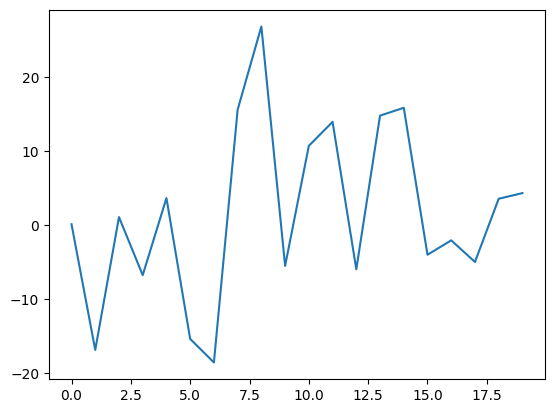

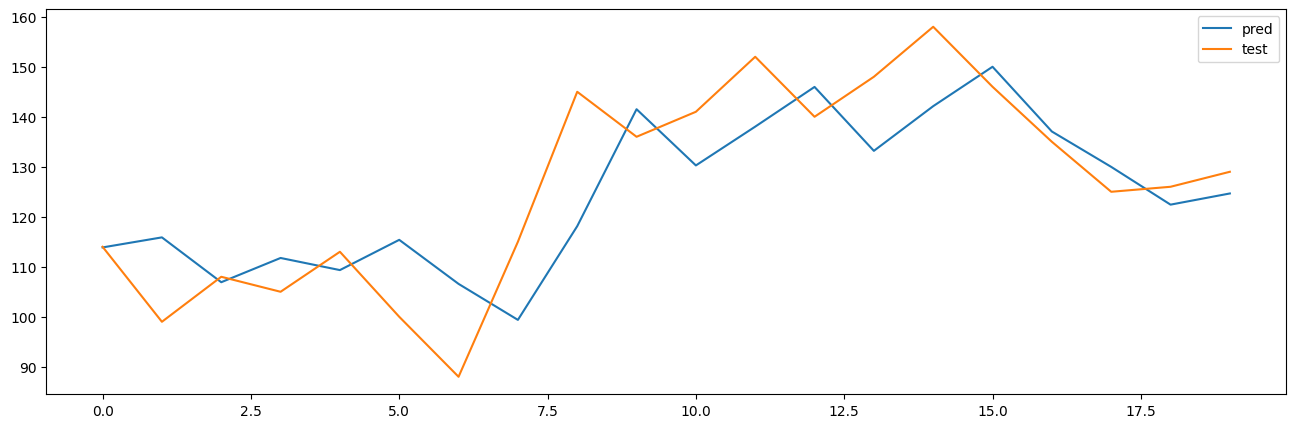

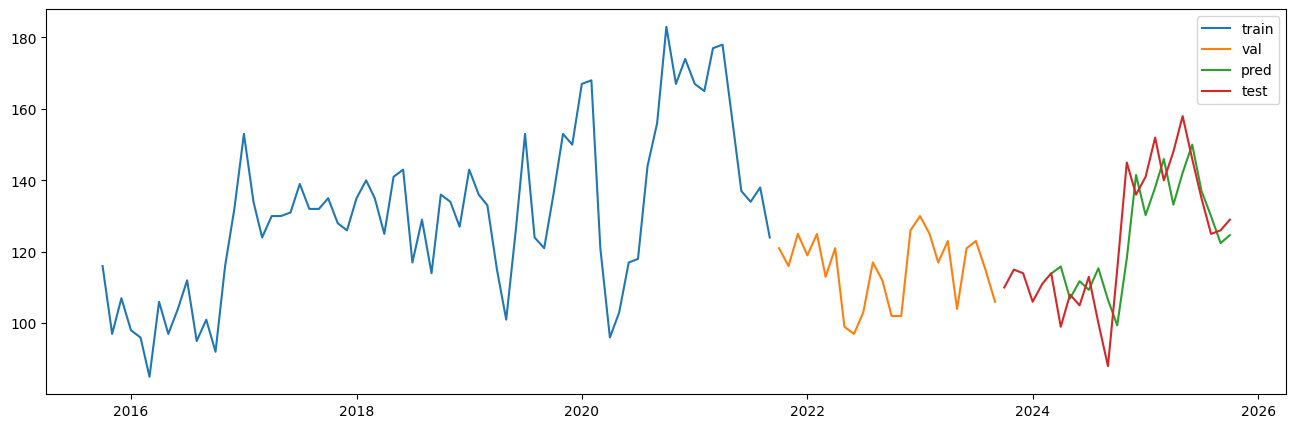

In [80]:
# concatenar las dos subseries
tr_vl = pd.concat([tr, vl])

y_ts_pred = predecir(x_ts_s, final_model, scaler)


# asignar los últimos 5 índices de `ts` a las predicciones
idx = ts.index[-len(y_ts_pred):]               # debería ser 5 índices
df_pred = pd.DataFrame({'y_ts_pred': y_ts_pred},
                       index=idx)


N = len(y_ts_pred)    # Número de predicciones (tamaño del set de prueba)
ndato = np.linspace(1,N,N)


mape = np.mean(np.abs((y_ts.flatten() - y_ts_pred) / y_ts.flatten())) * 100

print(f"\nResultados:")
print(f"MAPE: {mape:.2f}%")

# Cálculo de errores simples
errores = y_ts.flatten()-y_ts_pred
plt.plot(errores);
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(y_ts_pred,label="pred")
ax.plot(y_ts.flatten(),label="test")
plt.legend();
# si se quiere verificar gráficamente
plt.figure(figsize=(16,5))
plt.plot(tr, label='train')
plt.plot(vl, label='val')
plt.plot(df_pred,label="pred")
plt.plot(ts,label="test")
plt.legend()

#### Single step Recursivo

Iniciando predicción por bloques con IN=5, OUT=1...

Dimensiones finales:
Predicción continua: (20,)
Datos reales alineados: (20,)

Resultados de Predicción Recursiva (Bloques):
MAE:  16.5797
RMSE: 19.4753
MAPE: 13.13%


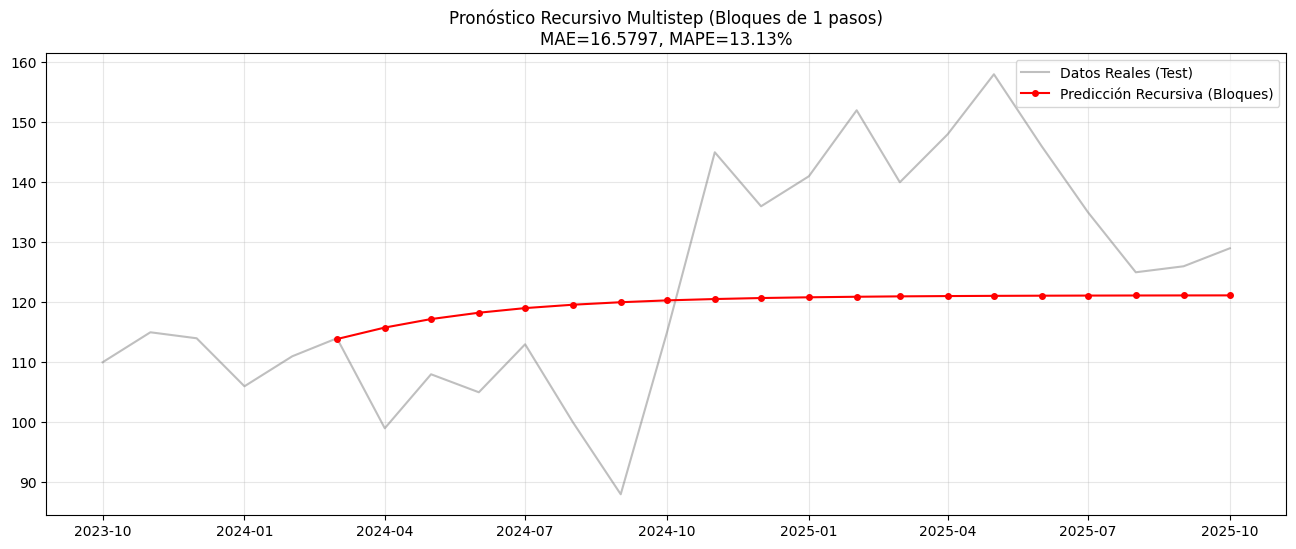

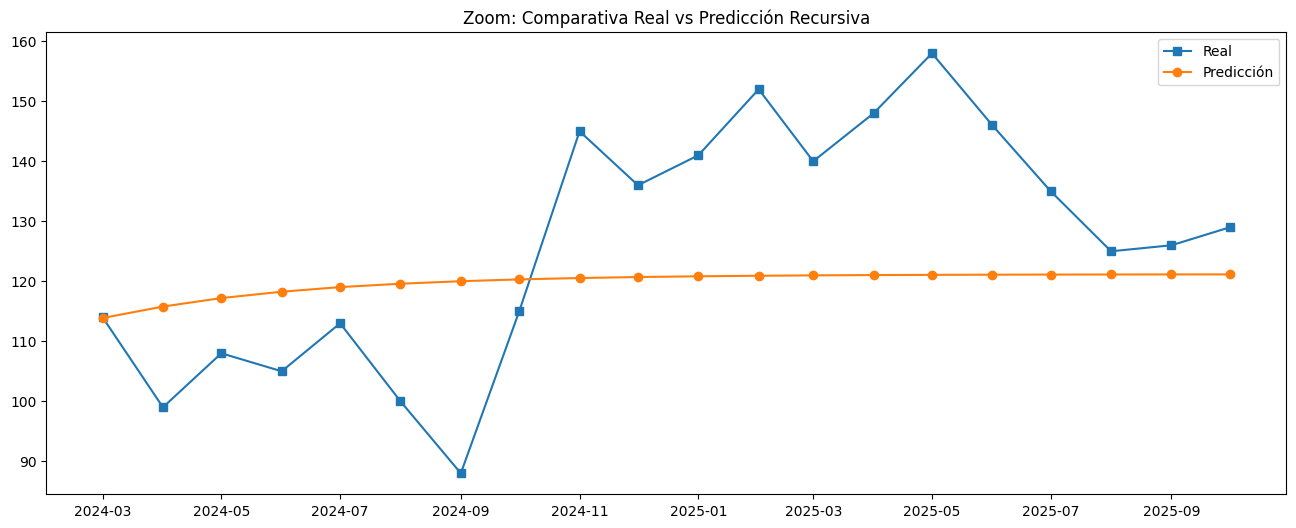

In [ ]:
# -------------------------------------------------------------------------
# EJECUCIÓN Y VISUALIZACIÓN
# -------------------------------------------------------------------------

print(f"Iniciando predicción por bloques con IN={INPUT_LENGTH}, OUT={OUTPUT_LENGTH}...")

# Ejecutar la nueva función
y_ts_pred_continuous = predecir_recursivo_bloques(x_ts_s, final_model, scaler, INPUT_LENGTH, OUTPUT_LENGTH)

# --- AJUSTE DE LONGITUDES ---
# Como predecimos en bloques, podemos pasarnos un poco del largo real de test.
# Recortamos para que coincida exactamente con el largo de y_ts (datos reales)
limit_len = len(y_ts) # Asumiendo que y_ts tiene forma (n_muestras, OUTPUT_LENGTH, 1) o similar
# Ojo: y_ts usualmente tiene overlap. Necesitamos el array plano de valores reales para comparar.
# Vamos a reconstruir el vector de tiempo real para comparar peras con peras.

# Asumiendo que 'ts' es tu dataframe de test original con los valores reales
y_real_vector = ts.values[-len(y_ts_pred_continuous):] 

# Si la predicción es más larga que los datos reales disponibles (por el último bloque), recortamos la predicción
if len(y_ts_pred_continuous) > len(y_real_vector):
    y_ts_pred_continuous = y_ts_pred_continuous[:len(y_real_vector)]
# Si es al revés, recortamos el real
elif len(y_real_vector) > len(y_ts_pred_continuous):
    y_real_vector = y_real_vector[:len(y_ts_pred_continuous)]

# Obtener índices para graficar
idx_plot = ts.index[-len(y_ts_pred_continuous):]

print(f"\nDimensiones finales:")
print(f"Predicción continua: {y_ts_pred_continuous.shape}")
print(f"Datos reales alineados: {y_real_vector.shape}")

# --- MÉTRICAS ---
mae = mean_absolute_error(y_real_vector, y_ts_pred_continuous)
rmse = np.sqrt(mean_squared_error(y_real_vector, y_ts_pred_continuous))
mape = np.mean(np.abs((y_real_vector - y_ts_pred_continuous) / y_real_vector)) * 100

print(f"\nResultados de Predicción Recursiva (Bloques):")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

# --- VISUALIZACIÓN ---
plt.figure(figsize=(16, 6))

# Serie original (Train + Test real)
plt.plot(ts.index, ts, label='Datos Reales (Test)', color='gray', alpha=0.5)

# Predicción recursiva
plt.plot(idx_plot, y_ts_pred_continuous, label='Predicción Recursiva (Bloques)', color='red', marker='o', markersize=4)

plt.title(f'Pronóstico Recursivo Multistep (Bloques de {OUTPUT_LENGTH} pasos)\nMAE={mae:.4f}, MAPE={mape:.2f}%')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Zoom a la zona de predicción
plt.figure(figsize=(16, 6))
plt.plot(idx_plot, y_real_vector, label='Real', marker='s')
plt.plot(idx_plot, y_ts_pred_continuous, label='Predicción', marker='o')
plt.title("Zoom: Comparativa Real vs Predicción Recursiva")
plt.legend()
plt.show()

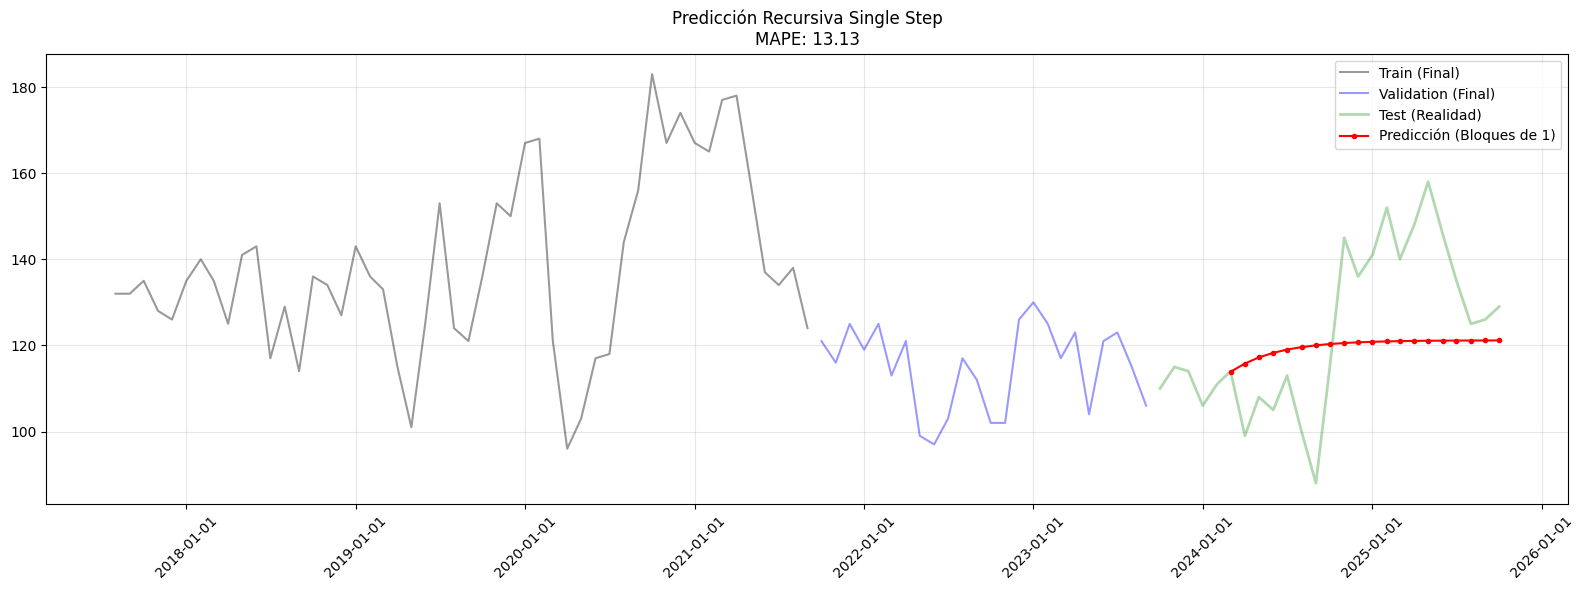

In [ ]:
# --- 1. Crear el índice correcto para las predicciones ---
# Las predicciones comienzan después de la primera ventana de input.
# Si x_ts_s se creó desde 'ts', la primera predicción corresponde al índice en:
# ts.index[INPUT_LENGTH] (aprox, depende de cómo creaste las secuencias)

# La forma más segura es tomar el final del índice de ts:
# Como predecimos recursivamente "hacia adelante" llenando el test:
total_preds = len(y_ts_pred_continuous)
idx_pred = ts.index[-total_preds:] # Asignamos las fechas del final de test a nuestras predicciones

df_pred = pd.DataFrame({'y_ts_pred': y_ts_pred_continuous}, index=idx_pred)

# --- 2. Visualización Corregida ---
import matplotlib.dates as mdates

plt.figure(figsize=(16, 6))

# A. Datos de Entrenamiento (Últimos 100 puntos para ver la unión)
# No graficamos todo el train para hacer zoom en la transición
plt.plot(tr.index[-50:], tr[-50:], label='Train (Final)', color='black', alpha=0.4)

plt.plot(vl.index[-50:], vl[-50:], label='Validation (Final)', color='blue', alpha=0.4)

# B. Datos de Test (Realidad Completa)
plt.plot(ts.index, ts, label="Test (Realidad)", color='green', alpha=0.3, linewidth=2)


# C. Predicción Recursiva (Encima del Test)
plt.plot(df_pred.index, df_pred['y_ts_pred'], label=f"Predicción (Bloques de {OUTPUT_LENGTH})", color='red', marker='o', markersize=3)

# D. Estética y Formato
plt.title(f'Predicción Recursiva Single Step\nMAPE: {mape:.2f}')
plt.legend()
plt.grid(True, alpha=0.3)

# Formato de fecha en eje X para que no se amontone
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### MultiStep


Tamaño set de entrenamiento: (72, 4)
Tamaño set de validación: (24, 4)
Tamaño set de prueba: (25, 4)


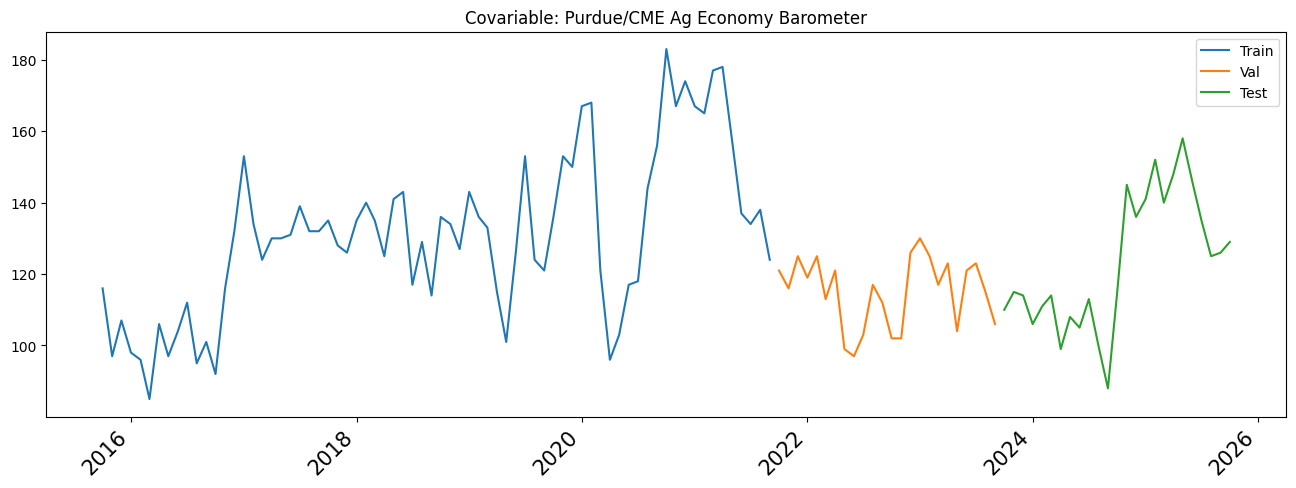

In [83]:
# Prueba de la función
tr, vl, ts = train_val_test_split(df_ageconomy, tr_size= 0.6, vl_size= 0.2, ts_size=0.2)

print(f'Tamaño set de entrenamiento: {tr.shape}')
print(f'Tamaño set de validación: {vl.shape}')
print(f'Tamaño set de prueba: {ts.shape}')
covar = 0 # Índice de la covariable (columna del dataset) a graficar
col = df_ageconomy.columns[covar]

# Dibujar los sets de entrenamiento/validación/prueba para la covariable
fig, ax = plt.subplots(figsize = (16,5))
ax.plot(tr[col], label='Train')
ax.plot(vl[col], label='Val')
ax.plot(ts[col], label='Test')
ax.set_title(f'Covariable: {col}')
plt.xticks(rotation=45, ha='right')
plt.xticks(fontsize = 15)
plt.legend();


In [84]:
tr = tr['Purdue/CME Ag Economy Barometer']
vl = vl['Purdue/CME Ag Economy Barometer']
ts = ts['Purdue/CME Ag Economy Barometer']

In [85]:
# Crear los datasets de entrenamiento, prueba y validación y verificar sus tamaños
INPUT_LENGTH = 5    # Hiperparámetro
OUTPUT_LENGTH = 4    # Modelo multi-step

x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH, col_index=0)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH, col_index=0)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH, col_index=0)

# Imprimir información en pantalla
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')



Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (64, 5, 1), y_tr: (64, 4, 1)
Set de validación - x_vl: (16, 5, 1), y_vl: (16, 4, 1)
Set de prueba - x_ts: (17, 5, 1), y_ts: (17, 4, 1)


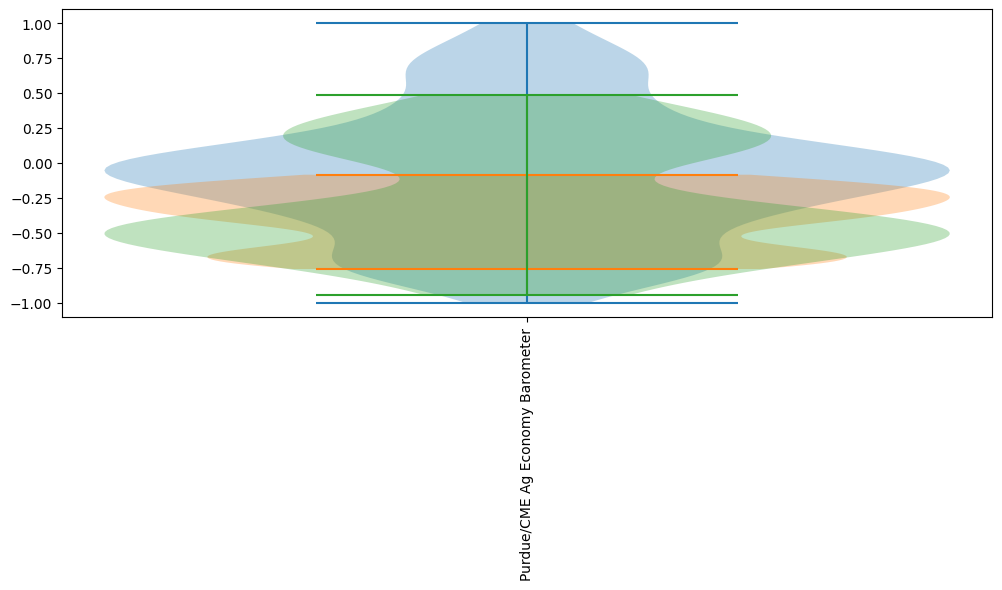

In [86]:
# Escalamiento del dataset con la función anterior

# Crear diccionario de entrada
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
   'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

# Y escalar (especificando la columna con la variable a predecir)
data_s, scaler = escalar_dataset_uni(data_in)

# Extraer subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']
# Y generemos una gráfica tipo violín para ver la distribución
# de los valores en cada covariable (entrada) y en la variable a
# predecir (salida)

n = len(df_ageconomy.columns)

fig, ax = plt.subplots(figsize=(12,4))
i = 0

ax.violinplot(dataset=x_tr_s[:,:,i].flatten(), positions=[i])
ax.violinplot(dataset=x_vl_s[:,:,i].flatten(), positions=[i])
ax.violinplot(dataset=x_ts_s[:,:,i].flatten(), positions=[i])

# Etiquetas eje horizontal
ax.set_xticks(list(range(n)))
ax.set_xticklabels(df_ageconomy.keys(), rotation=90)
ax.autoscale();
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])


In [87]:
# crear estudio y optimizar
study = optuna.create_study(direction='minimize')
study.optimize(objective_no_val, n_trials=100)

# resultados
print('Número de trials finalizados:', len(study.trials))
print('Mejor valor (val_loss):', study.best_value)
print('Mejores parámetros:')
for k, v in study.best_trial.params.items():
    print(f'  {k}: {v}')

# reentrenar con los datos de train+val usando los mejores hiperparámetros
best_params = study.best_trial.params

final_model = Sequential()
final_model.add(Input(shape=INPUT_SHAPE))
[final_model.add(LSTM(best_params['n_units'], activation=best_params['activation'], return_sequences=True)) for _ in range(best_params['num']-1)]
final_model.add(LSTM(best_params['n_units'], activation=best_params['activation']))
final_model.add(Dense(OUTPUT_LENGTH, activation='linear'))
final_model.compile(optimizer=RMSprop(learning_rate=best_params['lr']),
                    loss=root_mean_squared_error,
                    metrics=['mape'])

final_model.fit(x_tr_s, y_tr_s,
                epochs=50,
                batch_size=best_params['batch_size'],
                verbose=0)

rmse_test_opt = final_model.evaluate(x_ts_s, y_ts_s, verbose=0)
print(f'RMSE en test con modelo optimizado: {rmse_test_opt[0]:.3f}, MAPE en test con modelo optimizado: {rmse_test_opt[1]:.3f}')



[I 2026-02-21 10:10:25,620] A new study created in memory with name: no-name-a53b1f94-8e7e-4604-98ca-8bebd298416f
[I 2026-02-21 10:10:51,191] Trial 0 finished with value: 0.4305436313152313 and parameters: {'n_units': 208, 'lr': 0.0009510077169573179, 'batch_size': 256, 'activation': 'relu', 'num': 4, 'epochs': 250}. Best is trial 0 with value: 0.4305436313152313.
[I 2026-02-21 10:11:00,501] Trial 1 finished with value: 0.3853045701980591 and parameters: {'n_units': 96, 'lr': 0.007320857841684792, 'batch_size': 256, 'activation': 'relu', 'num': 3, 'epochs': 250}. Best is trial 1 with value: 0.3853045701980591.
[I 2026-02-21 10:11:20,406] Trial 2 finished with value: 0.41999128460884094 and parameters: {'n_units': 160, 'lr': 0.00010430161842929734, 'batch_size': 256, 'activation': 'tanh', 'num': 1, 'epochs': 350}. Best is trial 1 with value: 0.3853045701980591.
[I 2026-02-21 10:11:29,463] Trial 3 finished with value: 0.33879852294921875 and parameters: {'n_units': 240, 'lr': 0.003908466

Número de trials finalizados: 100
Mejor valor (val_loss): 0.2516343891620636
Mejores parámetros:
  n_units: 16
  lr: 0.007429436491701683
  batch_size: 256
  activation: tanh
  num: 1
  epochs: 390
RMSE en test con modelo optimizado: 0.359, MAPE en test con modelo optimizado: 170.656


array([122.331856, 122.47278 , 121.705765, 121.04279 , 120.994675,
       120.78115 , 120.02541 , 119.901276, 119.54087 , 121.0212  ,
       122.652245, 126.0693  , 131.19107 , 133.8359  , 133.86809 ,
       135.18134 , 136.02557 , 135.32126 , 134.84398 , 133.08403 ],
      dtype=float32)

In [139]:
y_ts_pred = predecir(x_ts_s, final_model, scaler)


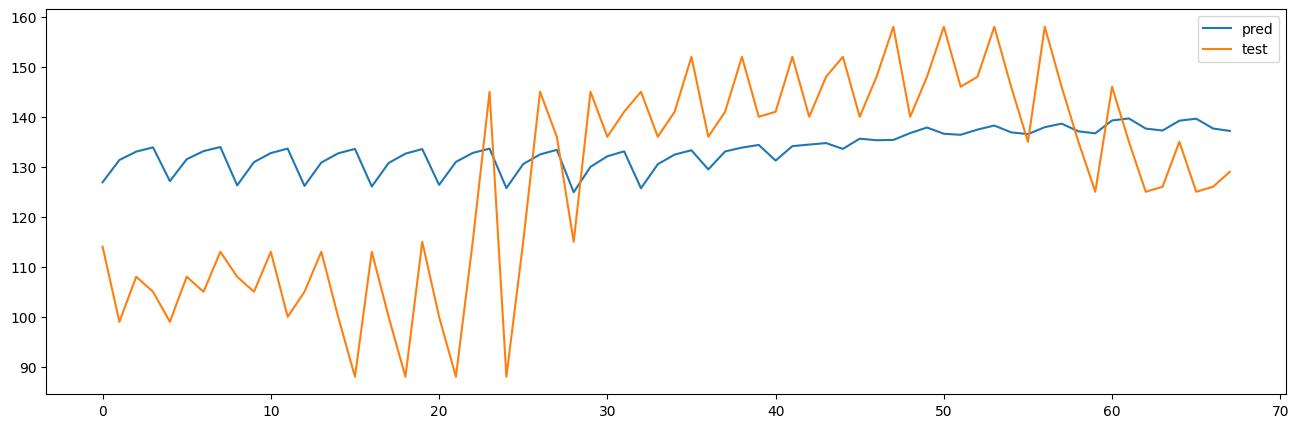

In [140]:
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(y_ts_pred,label="pred")
ax.plot(y_ts.flatten(),label="test")
plt.legend();

### MultiStep

#### Jumping

Iniciando predicción por bloques con IN=5, OUT=4...

Dimensiones finales:
Predicción continua: (20,)
Datos reales alineados: (20,)

Resultados de Predicción Recursiva (Bloques):
MAE:  19.8412
RMSE: 23.0420
MAPE: 15.25%


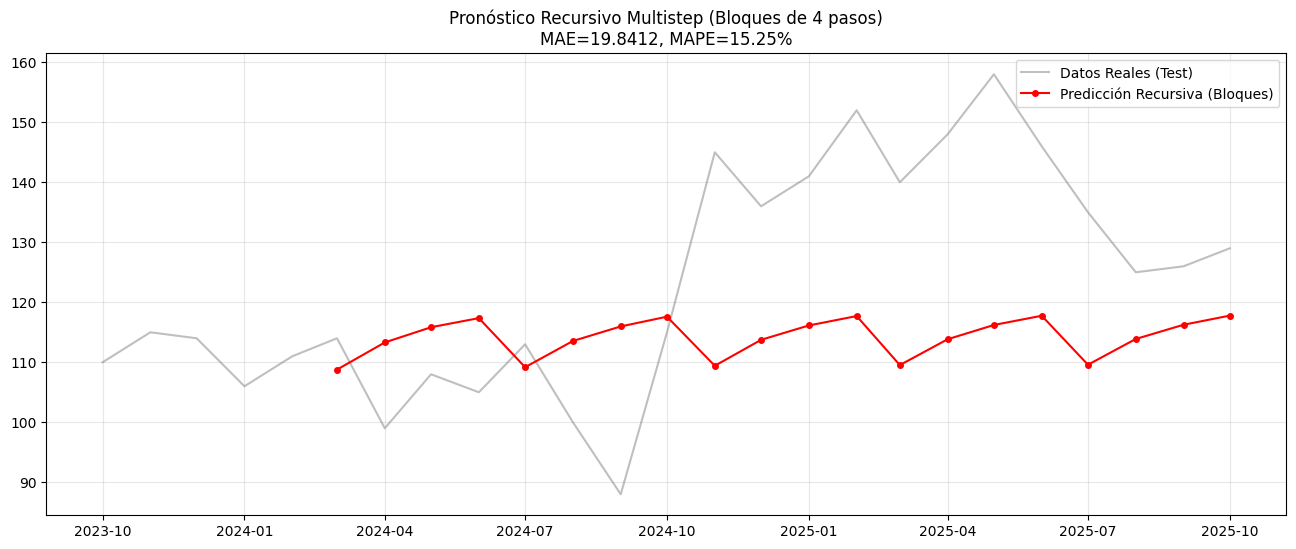

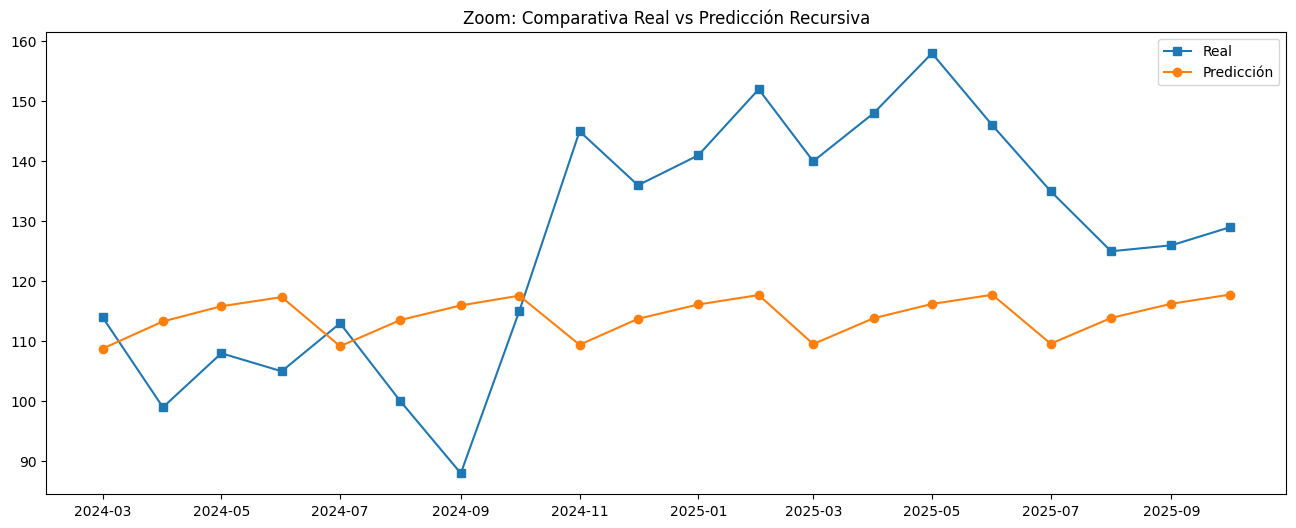

In [ ]:
# -------------------------------------------------------------------------
# EJECUCIÓN Y VISUALIZACIÓN
# -------------------------------------------------------------------------

print(f"Iniciando predicción por bloques con IN={INPUT_LENGTH}, OUT={OUTPUT_LENGTH}...")

# Ejecutar la nueva función
y_ts_pred_continuous = predecir_recursivo_bloques(x_ts_s, final_model, scaler, INPUT_LENGTH, OUTPUT_LENGTH)

# --- AJUSTE DE LONGITUDES ---
# Como predecimos en bloques, podemos pasarnos un poco del largo real de test.
# Recortamos para que coincida exactamente con el largo de y_ts (datos reales)
limit_len = len(y_ts) # Asumiendo que y_ts tiene forma (n_muestras, OUTPUT_LENGTH, 1) o similar
# Ojo: y_ts usualmente tiene overlap. Necesitamos el array plano de valores reales para comparar.
# Vamos a reconstruir el vector de tiempo real para comparar peras con peras.

# Asumiendo que 'ts' es tu dataframe de test original con los valores reales
y_real_vector = ts.values[-len(y_ts_pred_continuous):] 

# Si la predicción es más larga que los datos reales disponibles (por el último bloque), recortamos la predicción
if len(y_ts_pred_continuous) > len(y_real_vector):
    y_ts_pred_continuous = y_ts_pred_continuous[:len(y_real_vector)]
# Si es al revés, recortamos el real
elif len(y_real_vector) > len(y_ts_pred_continuous):
    y_real_vector = y_real_vector[:len(y_ts_pred_continuous)]

# Obtener índices para graficar
idx_plot = ts.index[-len(y_ts_pred_continuous):]

print(f"\nDimensiones finales:")
print(f"Predicción continua: {y_ts_pred_continuous.shape}")
print(f"Datos reales alineados: {y_real_vector.shape}")

# --- MÉTRICAS ---
mae = mean_absolute_error(y_real_vector, y_ts_pred_continuous)
rmse = np.sqrt(mean_squared_error(y_real_vector, y_ts_pred_continuous))
mape = np.mean(np.abs((y_real_vector - y_ts_pred_continuous) / y_real_vector)) * 100

print(f"\nResultados de Predicción Recursiva (Bloques):")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

# --- VISUALIZACIÓN ---
plt.figure(figsize=(16, 6))

# Serie original (Train + Test real)
plt.plot(ts.index, ts, label='Datos Reales (Test)', color='gray', alpha=0.5)

# Predicción recursiva
plt.plot(idx_plot, y_ts_pred_continuous, label='Predicción Recursiva (Bloques)', color='red', marker='o', markersize=4)

plt.title(f'Pronóstico Recursivo Multistep (Bloques de {OUTPUT_LENGTH} pasos)\nMAE={mae:.4f}, MAPE={mape:.2f}%')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Zoom a la zona de predicción
plt.figure(figsize=(16, 6))
plt.plot(idx_plot, y_real_vector, label='Real', marker='s')
plt.plot(idx_plot, y_ts_pred_continuous, label='Predicción', marker='o')
plt.title("Zoom: Comparativa Real vs Predicción Recursiva")
plt.legend()
plt.show()

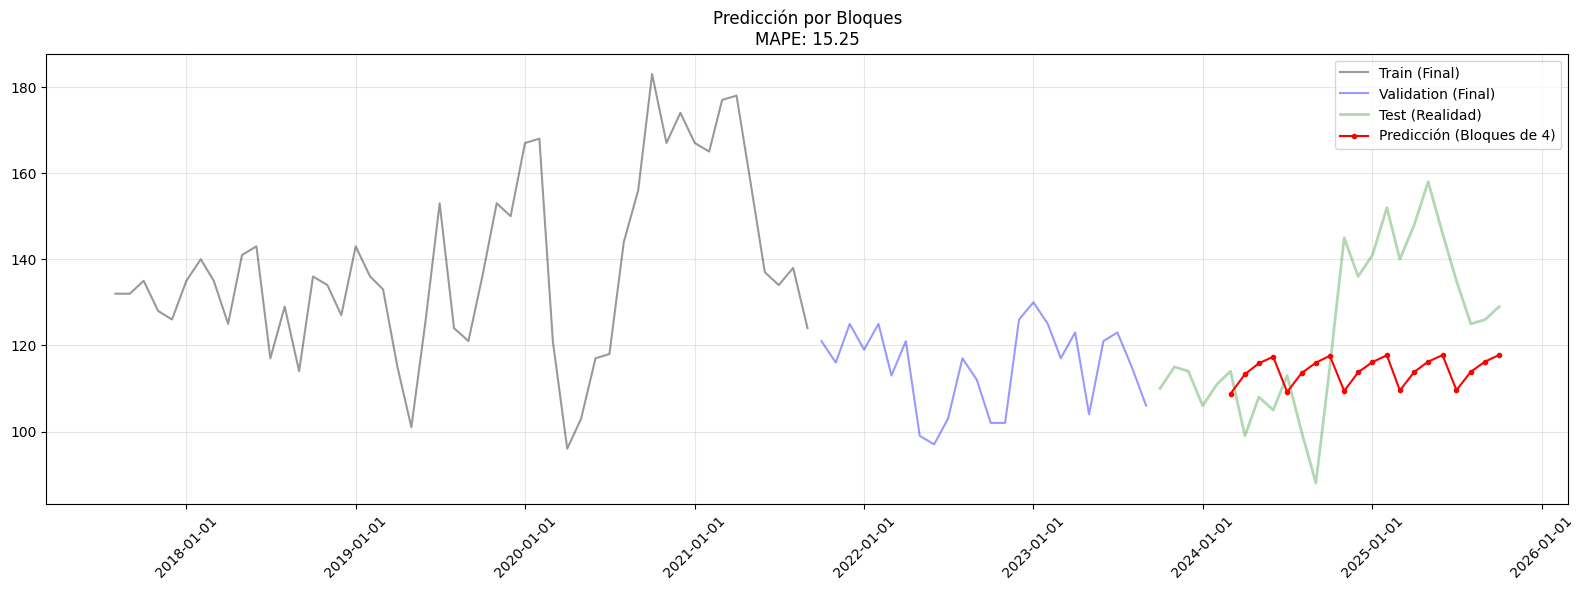

In [94]:
# --- 1. Crear el índice correcto para las predicciones ---
# Las predicciones comienzan después de la primera ventana de input.
# Si x_ts_s se creó desde 'ts', la primera predicción corresponde al índice en:
# ts.index[INPUT_LENGTH] (aprox, depende de cómo creaste las secuencias)

# La forma más segura es tomar el final del índice de ts:
# Como predecimos recursivamente "hacia adelante" llenando el test:
total_preds = len(y_ts_pred_continuous)
idx_pred = ts.index[-total_preds:] # Asignamos las fechas del final de test a nuestras predicciones

df_pred = pd.DataFrame({'y_ts_pred': y_ts_pred_continuous}, index=idx_pred)

# --- 2. Visualización Corregida ---
import matplotlib.dates as mdates

plt.figure(figsize=(16, 6))

# A. Datos de Entrenamiento (Últimos 100 puntos para ver la unión)
# No graficamos todo el train para hacer zoom en la transición
plt.plot(tr.index[-50:], tr[-50:], label='Train (Final)', color='black', alpha=0.4)

plt.plot(vl.index[-50:], vl[-50:], label='Validation (Final)', color='blue', alpha=0.4)

# B. Datos de Test (Realidad Completa)
plt.plot(ts.index, ts, label="Test (Realidad)", color='green', alpha=0.3, linewidth=2)


# C. Predicción Recursiva (Encima del Test)
plt.plot(df_pred.index, df_pred['y_ts_pred'], label=f"Predicción (Bloques de {OUTPUT_LENGTH})", color='red', marker='o', markersize=3)

# D. Estética y Formato
plt.title(f'Predicción por Bloques\nMAPE: {mape:.2f}')
plt.legend()
plt.grid(True, alpha=0.3)

# Formato de fecha en eje X para que no se amontone
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### MultiStep Rolling Forecast

Iniciando Rolling Forecast (Reset con Real) con IN=5, OUT=4...

Dimensiones finales:
Predicción Rolling: (20,)
Datos reales:       (20,)

Resultados de Rolling Forecast (Actualización Real):
MAE:  14.0745
RMSE: 17.2862
MAPE: 11.16%


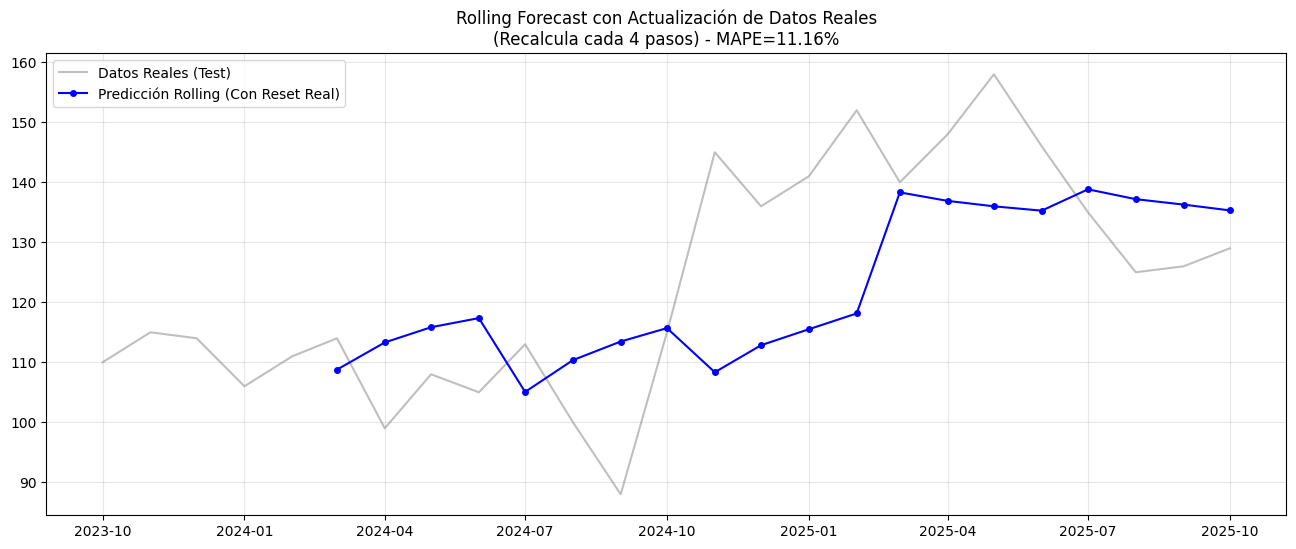

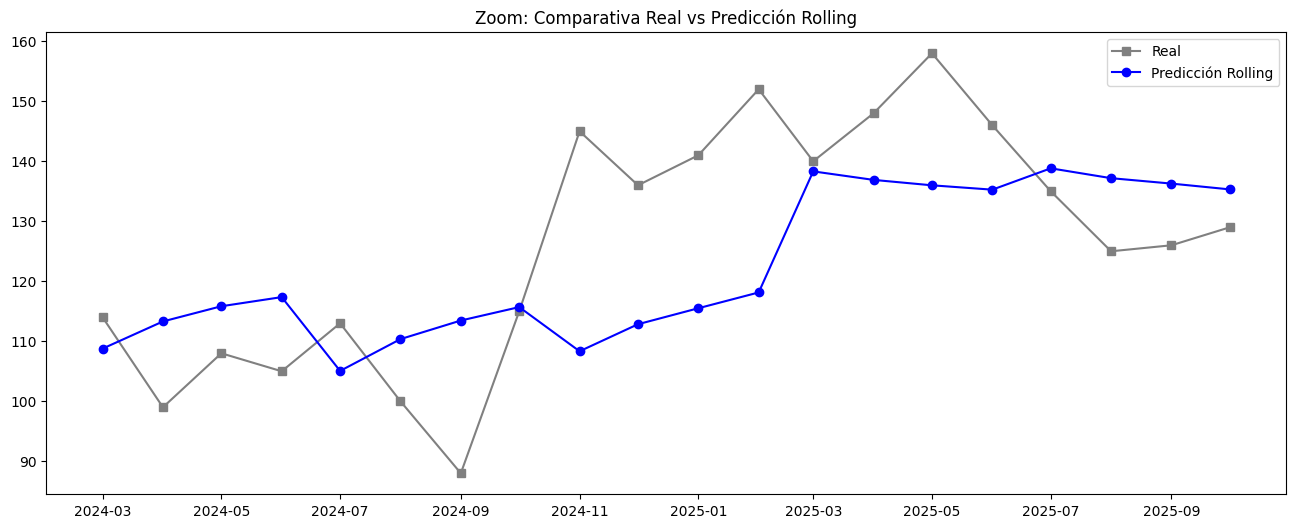

In [ ]:
# -------------------------------------------------------------------------
# EJECUCIÓN Y VISUALIZACIÓN
# -------------------------------------------------------------------------

print(f"Iniciando Rolling Forecast (Reset con Real) con IN={INPUT_LENGTH}, OUT={OUTPUT_LENGTH}...")

# Ejecutar la función MODIFICADA
y_ts_pred_rolling = predecir_con_actualizacion_real(x_ts_s, final_model, scaler, INPUT_LENGTH, OUTPUT_LENGTH)

# --- AJUSTE DE LONGITUDES ---
# Reconstruir vector real para comparación
y_real_vector = ts.values[-len(y_ts_pred_rolling):] 

# Recortes por si el último bloque se pasa
if len(y_ts_pred_rolling) > len(y_real_vector):
    y_ts_pred_rolling = y_ts_pred_rolling[:len(y_real_vector)]
elif len(y_real_vector) > len(y_ts_pred_rolling):
    y_real_vector = y_real_vector[:len(y_ts_pred_rolling)]

# Obtener índices para graficar
idx_plot = ts.index[-len(y_ts_pred_rolling):]

print(f"\nDimensiones finales:")
print(f"Predicción Rolling: {y_ts_pred_rolling.shape}")
print(f"Datos reales:       {y_real_vector.shape}")

# --- MÉTRICAS ---
mae = mean_absolute_error(y_real_vector, y_ts_pred_rolling)
rmse = np.sqrt(mean_squared_error(y_real_vector, y_ts_pred_rolling))
mape = np.mean(np.abs((y_real_vector - y_ts_pred_rolling) / y_real_vector)) * 100

print(f"\nResultados de Rolling Forecast (Actualización Real):")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

# --- VISUALIZACIÓN ---
plt.figure(figsize=(16, 6))

# Serie original (Train + Test real)
plt.plot(ts.index, ts, label='Datos Reales (Test)', color='gray', alpha=0.5)

# Predicción Rolling (Reset)
# Esta línea se verá "mejor" (más pegada al real) que la recursiva pura,
# porque corrige el rumbo cada OUTPUT_LENGTH pasos.
plt.plot(idx_plot, y_ts_pred_rolling, label='Predicción Rolling (Con Reset Real)', color='blue', marker='o', markersize=4)

plt.title(f'Rolling Forecast con Actualización de Datos Reales\n(Recalcula cada {OUTPUT_LENGTH} pasos) - MAPE={mape:.2f}%')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Zoom
plt.figure(figsize=(16, 6))
plt.plot(idx_plot, y_real_vector, label='Real', marker='s', color='gray')
plt.plot(idx_plot, y_ts_pred_rolling, label='Predicción Rolling', marker='o', color='blue')
plt.title("Zoom: Comparativa Real vs Predicción Rolling")
plt.legend()
plt.show()

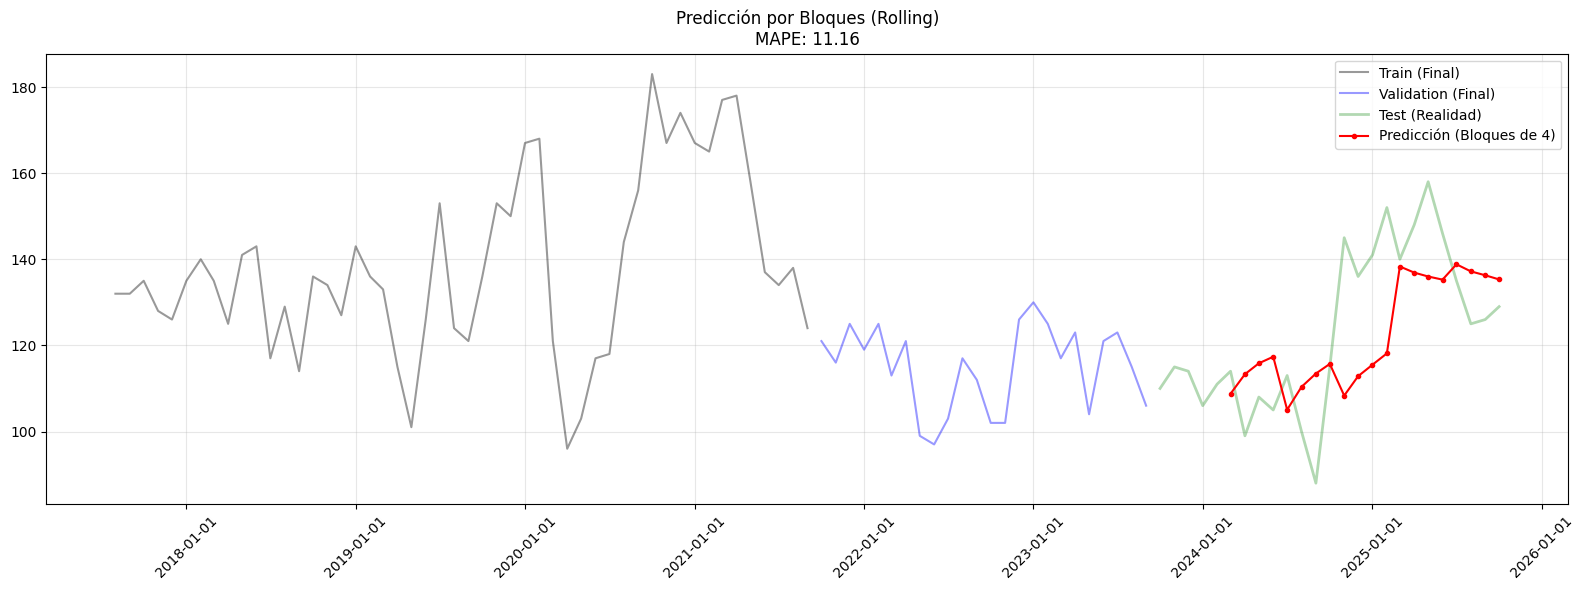

In [97]:
# --- 1. Crear el índice correcto para las predicciones ---
# Las predicciones comienzan después de la primera ventana de input.
# Si x_ts_s se creó desde 'ts', la primera predicción corresponde al índice en:
# ts.index[INPUT_LENGTH] (aprox, depende de cómo creaste las secuencias)

# La forma más segura es tomar el final del índice de ts:
# Como predecimos recursivamente "hacia adelante" llenando el test:
total_preds = len(y_ts_pred_rolling)
idx_pred = ts.index[-total_preds:] # Asignamos las fechas del final de test a nuestras predicciones

df_pred = pd.DataFrame({'y_ts_pred': y_ts_pred_rolling}, index=idx_pred)

# --- 2. Visualización Corregida ---
import matplotlib.dates as mdates

plt.figure(figsize=(16, 6))

# A. Datos de Entrenamiento (Últimos 100 puntos para ver la unión)
# No graficamos todo el train para hacer zoom en la transición
plt.plot(tr.index[-50:], tr[-50:], label='Train (Final)', color='black', alpha=0.4)
plt.plot(vl.index[-50:], vl[-50:], label='Validation (Final)', color='blue', alpha=0.4)

# B. Datos de Test (Realidad Completa)
plt.plot(ts.index, ts, label="Test (Realidad)", color='green', alpha=0.3, linewidth=2)

# C. Predicción Recursiva (Encima del Test)
plt.plot(df_pred.index, df_pred['y_ts_pred'], label=f"Predicción (Bloques de {OUTPUT_LENGTH})", color='red', marker='o', markersize=3)

# D. Estética y Formato
plt.title(f'Predicción por Bloques (Rolling)\nMAPE: {mape:.2f}')
plt.legend()
plt.grid(True, alpha=0.3)

# Formato de fecha en eje X para que no se amontone
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## ICG

In [116]:
# Prueba de la función
tr, vl, ts = train_val_test_split(df_ICG, tr_size= 0.6, vl_size= 0.2, ts_size=0.2)

print(f'Tamaño set de entrenamiento: {tr.shape}')
print(f'Tamaño set de validación: {vl.shape}')
print(f'Tamaño set de prueba: {ts.shape}')

Tamaño set de entrenamiento: (172, 1)
Tamaño set de validación: (57, 1)
Tamaño set de prueba: (59, 1)


Graficamos para ver los bloques separados

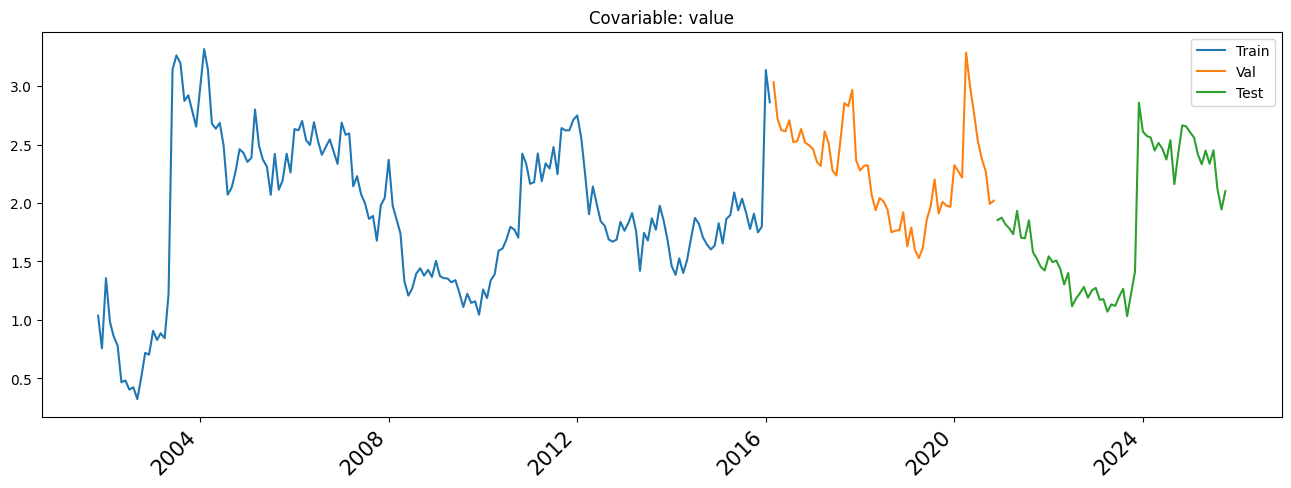

In [117]:
covar = 0 # Índice de la covariable (columna del dataset) a graficar
col = df_ICG.columns[covar]

# Dibujar los sets de entrenamiento/validación/prueba para la covariable
fig, ax = plt.subplots(figsize = (16,5))
ax.plot(tr[col], label='Train')
ax.plot(vl[col], label='Val')
ax.plot(ts[col], label='Test')
ax.set_title(f'Covariable: {col}')
plt.xticks(rotation=45, ha='right')
plt.xticks(fontsize = 15)
plt.legend();

In [132]:
# Crear los datasets de entrenamiento, prueba y validación y verificar sus tamaños
INPUT_LENGTH = 12    # Hiperparámetro
OUTPUT_LENGTH = 1    # Modelo multi-step

x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH, col_index=0)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH, col_index=0)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH, col_index=0)

# Imprimir información en pantalla
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

# Escalamiento del dataset con la función anterior

# Crear diccionario de entrada
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

# Y escalar (especificando la columna con la variable a predecir)
data_s, scaler = escalar_dataset(data_in, col_ref = 'value', df = df_ICG )

# Extraer subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (160, 12, 1), y_tr: (160, 1, 1)
Set de validación - x_vl: (45, 12, 1), y_vl: (45, 1, 1)
Set de prueba - x_ts: (47, 12, 1), y_ts: (47, 1, 1)


In [119]:
n = len(df_ICG.columns)

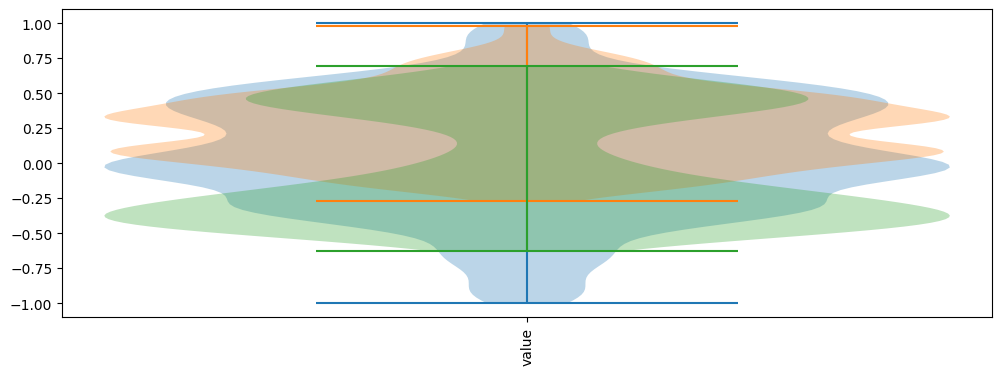

In [133]:
# Y generemos una gráfica tipo violín para ver la distribución
# de los valores en cada covariable (entrada) y en la variable a
# predecir (salida)

n = len(df_ICG.columns)

fig, ax = plt.subplots(figsize=(12,4))
# for i in range(n):
ax.violinplot(dataset=x_tr_s[:,:,0].flatten(), positions=[0])
ax.violinplot(dataset=x_vl_s[:,:,0].flatten(), positions=[0])
ax.violinplot(dataset=x_ts_s[:,:,0].flatten(), positions=[0])

# Etiquetas eje horizontal
ax.set_xticks(list(range(n)))
ax.set_xticklabels(df_ICG.keys(), rotation=90)
ax.autoscale();

In [121]:
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])

In [125]:
# crear estudio y optimizar
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# # resultados
# print('Número de trials finalizados:', len(study.trials))
# print('Mejor valor (val_loss):', study.best_value)
# print('Mejores parámetros:')
# for k, v in study.best_trial.params.items():
#     print(f'  {k}: {v}')

# reentrenar con los datos de train+val usando los mejores hiperparámetros
best_params = study.best_trial.params
X_combined = np.vstack([x_tr_s, x_vl_s])
Y_combined = np.vstack([y_tr_s, y_vl_s])

final_model = Sequential()
final_model.add(Input(shape=INPUT_SHAPE))
[final_model.add(LSTM(best_params['n_units'], activation=best_params['activation'], return_sequences=True)) for _ in range(best_params['num']-1)]
final_model.add(LSTM(best_params['n_units'], activation=best_params['activation']))
final_model.add(Dense(OUTPUT_LENGTH, activation='linear'))
final_model.compile(optimizer=RMSprop(learning_rate=best_params['lr']),
                    loss=root_mean_squared_error,
                    metrics=['mape'])

final_model.fit(X_combined, Y_combined,
                epochs=50,
                batch_size=best_params['batch_size'],
                verbose=0)

rmse_test_opt = final_model.evaluate(x_ts_s, y_ts_s, verbose=0)
print(f'RMSE en test con modelo optimizado: {rmse_test_opt[0]:.3f}, MAPE en test con modelo optimizado: {rmse_test_opt[1]:.3f}')

RMSE en test con modelo optimizado: 0.203, MAPE en test con modelo optimizado: 42.289



Resultados:
MAPE: 11.93%


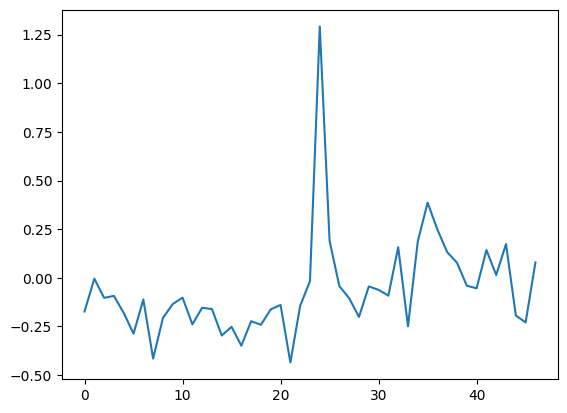

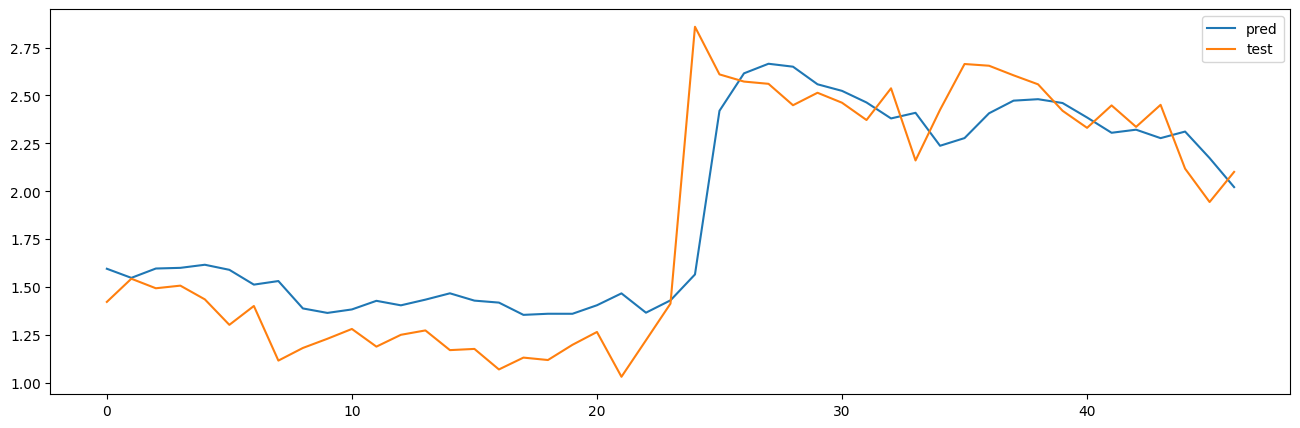

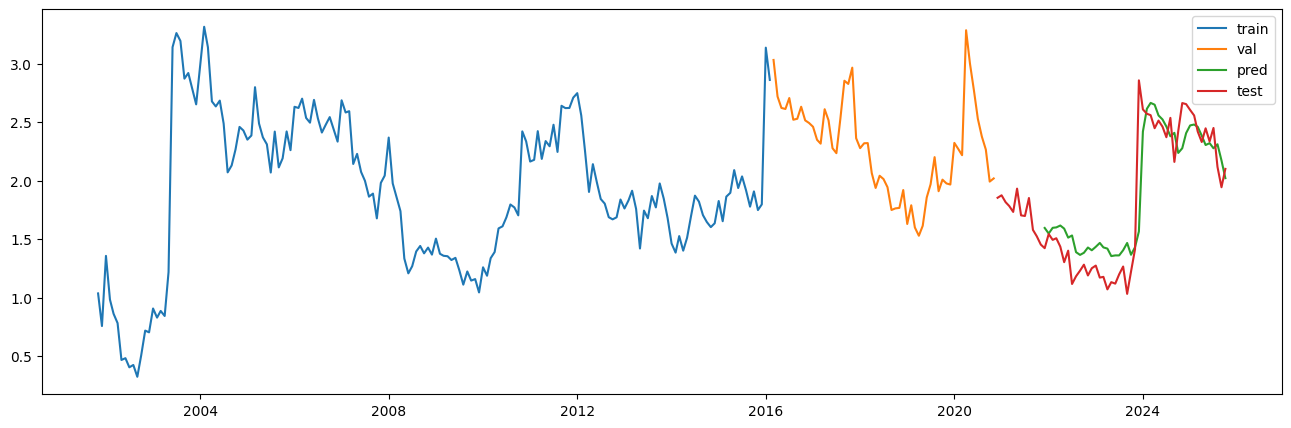

In [126]:
# concatenar las dos subseries
tr_vl = pd.concat([tr, vl])

y_ts_pred = predecir(x_ts_s, final_model, scaler)


# asignar los últimos 5 índices de `ts` a las predicciones
idx = ts.index[-len(y_ts_pred):]               # debería ser 5 índices
df_pred = pd.DataFrame({'y_ts_pred': y_ts_pred},
                       index=idx)


N = len(y_ts_pred)    # Número de predicciones (tamaño del set de prueba)
ndato = np.linspace(1,N,N)


mape = np.mean(np.abs((y_ts.flatten() - y_ts_pred) / y_ts.flatten())) * 100

print(f"\nResultados:")
print(f"MAPE: {mape:.2f}%")

# Cálculo de errores simples
errores = y_ts.flatten()-y_ts_pred
plt.plot(errores);
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(y_ts_pred,label="pred")
ax.plot(y_ts.flatten(),label="test")
plt.legend();
# si se quiere verificar gráficamente
plt.figure(figsize=(16,5))
plt.plot(tr, label='train')
plt.plot(vl, label='val')
plt.plot(df_pred,label="pred")
plt.plot(ts,label="test")
plt.legend()

#### Single step recursivo

Iniciando predicción por bloques con IN=12, OUT=1...

Dimensiones finales:
Predicción continua: (47,)
Datos reales alineados: (47, 1)

Resultados de Predicción Recursiva (Bloques):
MAE:  0.5390
RMSE: 0.6284
MAPE: 31.39%


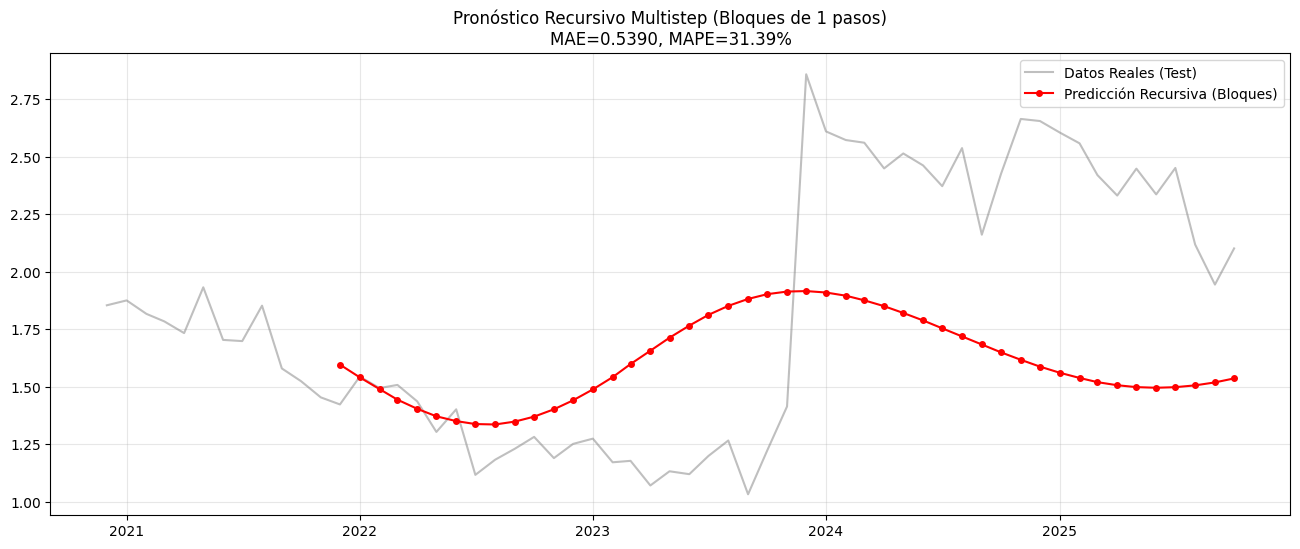

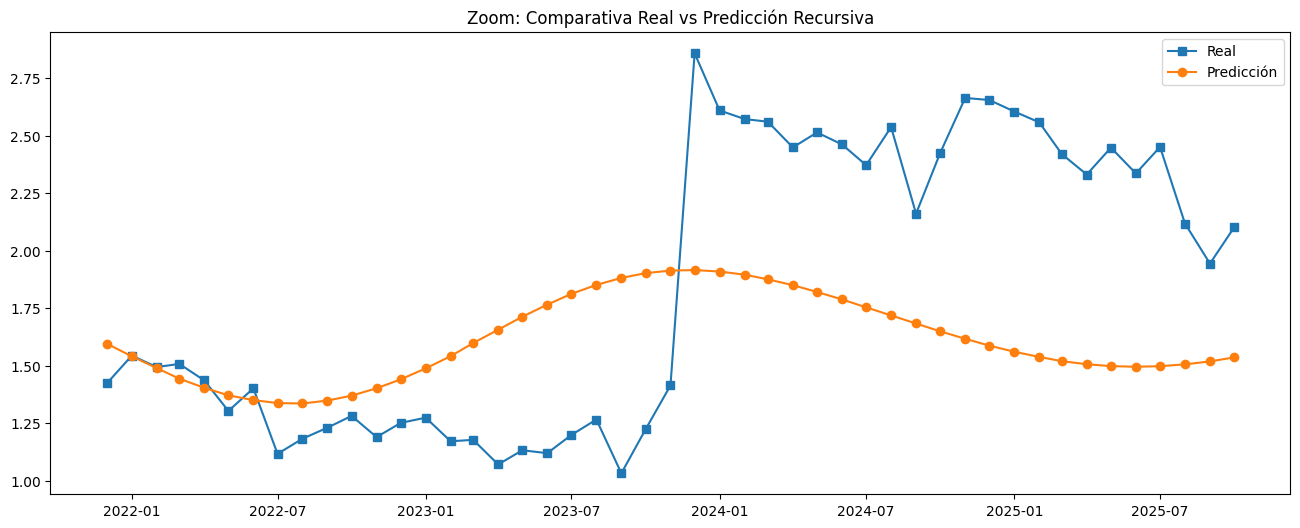

In [ ]:
# -------------------------------------------------------------------------
# EJECUCIÓN Y VISUALIZACIÓN
# -------------------------------------------------------------------------

print(f"Iniciando predicción por bloques con IN={INPUT_LENGTH}, OUT={OUTPUT_LENGTH}...")

# Ejecutar la nueva función
y_ts_pred_continuous = predecir_recursivo_bloques(x_ts_s, final_model, scaler, INPUT_LENGTH, OUTPUT_LENGTH)

# --- AJUSTE DE LONGITUDES ---
# Como predecimos en bloques, podemos pasarnos un poco del largo real de test.
# Recortamos para que coincida exactamente con el largo de y_ts (datos reales)
limit_len = len(y_ts) # Asumiendo que y_ts tiene forma (n_muestras, OUTPUT_LENGTH, 1) o similar
# Ojo: y_ts usualmente tiene overlap. Necesitamos el array plano de valores reales para comparar.
# Vamos a reconstruir el vector de tiempo real para comparar peras con peras.

# Asumiendo que 'ts' es tu dataframe de test original con los valores reales
y_real_vector = ts.values[-len(y_ts_pred_continuous):] 

# Si la predicción es más larga que los datos reales disponibles (por el último bloque), recortamos la predicción
if len(y_ts_pred_continuous) > len(y_real_vector):
    y_ts_pred_continuous = y_ts_pred_continuous[:len(y_real_vector)]
# Si es al revés, recortamos el real
elif len(y_real_vector) > len(y_ts_pred_continuous):
    y_real_vector = y_real_vector[:len(y_ts_pred_continuous)]

# Obtener índices para graficar
idx_plot = ts.index[-len(y_ts_pred_continuous):]

print(f"\nDimensiones finales:")
print(f"Predicción continua: {y_ts_pred_continuous.shape}")
print(f"Datos reales alineados: {y_real_vector.shape}")

# --- MÉTRICAS ---
mae = mean_absolute_error(y_real_vector, y_ts_pred_continuous)
rmse = np.sqrt(mean_squared_error(y_real_vector, y_ts_pred_continuous))
mape = np.mean(np.abs((y_real_vector - y_ts_pred_continuous) / y_real_vector)) * 100

print(f"\nResultados de Predicción Recursiva (Bloques):")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

# --- VISUALIZACIÓN ---
plt.figure(figsize=(16, 6))

# Serie original (Train + Test real)
plt.plot(ts.index, ts, label='Datos Reales (Test)', color='gray', alpha=0.5)

# Predicción recursiva
plt.plot(idx_plot, y_ts_pred_continuous, label='Predicción Recursiva (Bloques)', color='red', marker='o', markersize=4)

plt.title(f'Pronóstico Recursivo Multistep (Bloques de {OUTPUT_LENGTH} pasos)\nMAE={mae:.4f}, MAPE={mape:.2f}%')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Zoom a la zona de predicción
plt.figure(figsize=(16, 6))
plt.plot(idx_plot, y_real_vector, label='Real', marker='s')
plt.plot(idx_plot, y_ts_pred_continuous, label='Predicción', marker='o')
plt.title("Zoom: Comparativa Real vs Predicción Recursiva")
plt.legend()
plt.show()

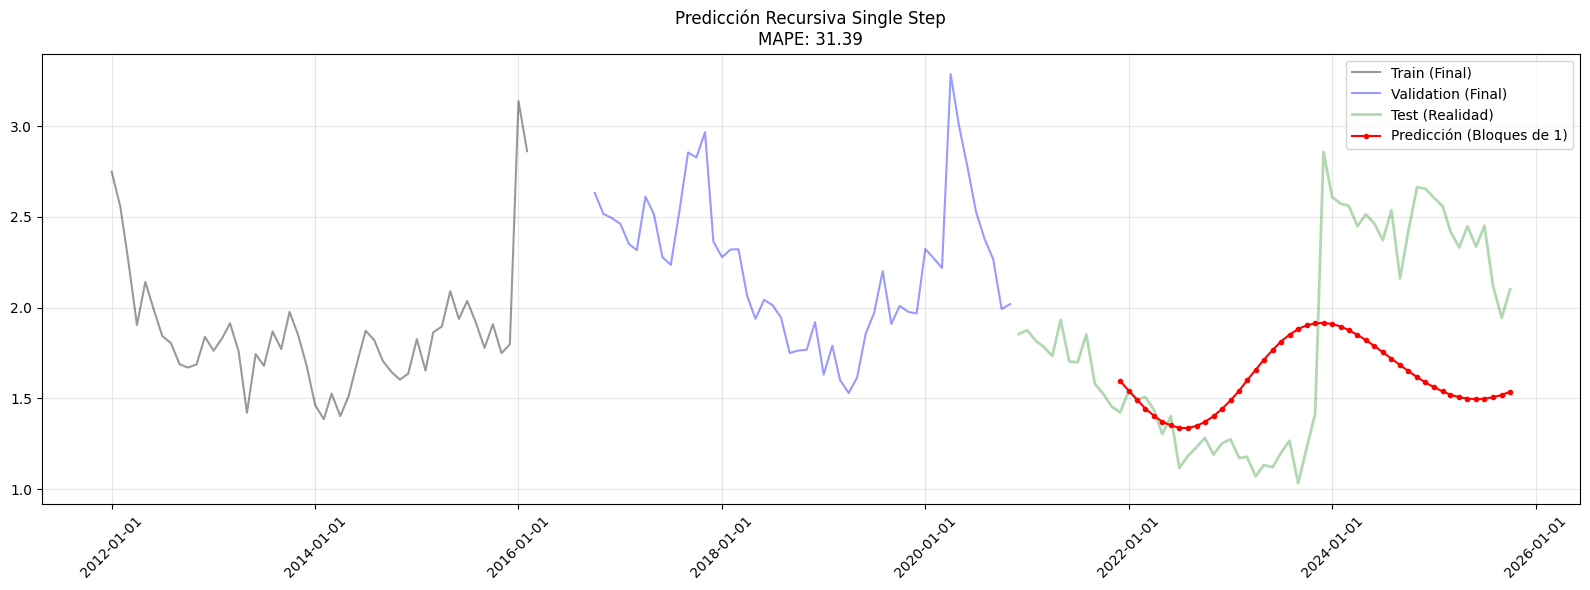

In [ ]:
# --- 1. Crear el índice correcto para las predicciones ---
# Las predicciones comienzan después de la primera ventana de input.
# Si x_ts_s se creó desde 'ts', la primera predicción corresponde al índice en:
# ts.index[INPUT_LENGTH] (aprox, depende de cómo creaste las secuencias)

# La forma más segura es tomar el final del índice de ts:
# Como predecimos recursivamente "hacia adelante" llenando el test:
total_preds = len(y_ts_pred_continuous)
idx_pred = ts.index[-total_preds:] # Asignamos las fechas del final de test a nuestras predicciones

df_pred = pd.DataFrame({'y_ts_pred': y_ts_pred_continuous}, index=idx_pred)

# --- 2. Visualización Corregida ---
import matplotlib.dates as mdates

plt.figure(figsize=(16, 6))

# A. Datos de Entrenamiento (Últimos 100 puntos para ver la unión)
# No graficamos todo el train para hacer zoom en la transición
plt.plot(tr.index[-50:], tr[-50:], label='Train (Final)', color='black', alpha=0.4)

plt.plot(vl.index[-50:], vl[-50:], label='Validation (Final)', color='blue', alpha=0.4)

# B. Datos de Test (Realidad Completa)
plt.plot(ts.index, ts, label="Test (Realidad)", color='green', alpha=0.3, linewidth=2)


# C. Predicción Recursiva (Encima del Test)
plt.plot(df_pred.index, df_pred['y_ts_pred'], label=f"Predicción (Bloques de {OUTPUT_LENGTH})", color='red', marker='o', markersize=3)

# D. Estética y Formato
plt.title(f'Predicción Recursiva Single Step\nMAPE: {mape:.2f}')
plt.legend()
plt.grid(True, alpha=0.3)

# Formato de fecha en eje X para que no se amontone
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### MultiStep


Tamaño set de entrenamiento: (172, 1)
Tamaño set de validación: (57, 1)
Tamaño set de prueba: (59, 1)


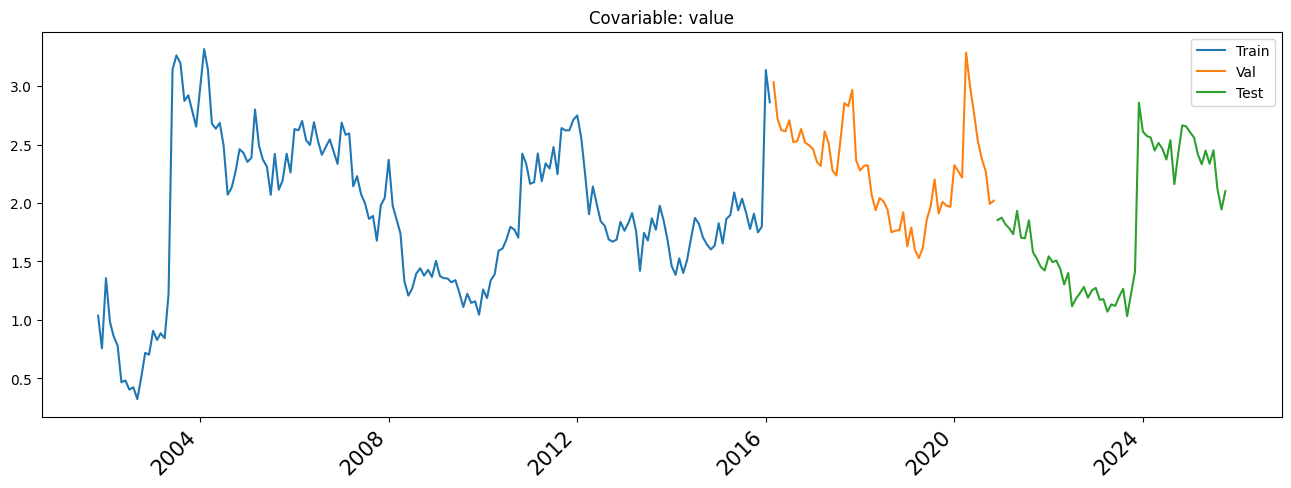

In [109]:
# Prueba de la función
tr, vl, ts = train_val_test_split(df_ICG, tr_size= 0.6, vl_size= 0.2, ts_size=0.2)

print(f'Tamaño set de entrenamiento: {tr.shape}')
print(f'Tamaño set de validación: {vl.shape}')
print(f'Tamaño set de prueba: {ts.shape}')
covar = 0 # Índice de la covariable (columna del dataset) a graficar
col = df_ICG.columns[covar]

# Dibujar los sets de entrenamiento/validación/prueba para la covariable
fig, ax = plt.subplots(figsize = (16,5))
ax.plot(tr[col], label='Train')
ax.plot(vl[col], label='Val')
ax.plot(ts[col], label='Test')
ax.set_title(f'Covariable: {col}')
plt.xticks(rotation=45, ha='right')
plt.xticks(fontsize = 15)
plt.legend();


In [110]:
tr = tr['value']
vl = vl['value']
ts = ts['value']

In [ ]:
# Crear los datasets de entrenamiento, prueba y validación y verificar sus tamaños
INPUT_LENGTH = 12    # Hiperparámetro
OUTPUT_LENGTH = 6    # Modelo multi-step

x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH, col_index=0)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH, col_index=0)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH, col_index=0)

# Imprimir información en pantalla
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')



Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (64, 5, 1), y_tr: (64, 4, 1)
Set de validación - x_vl: (16, 5, 1), y_vl: (16, 4, 1)
Set de prueba - x_ts: (17, 5, 1), y_ts: (17, 4, 1)


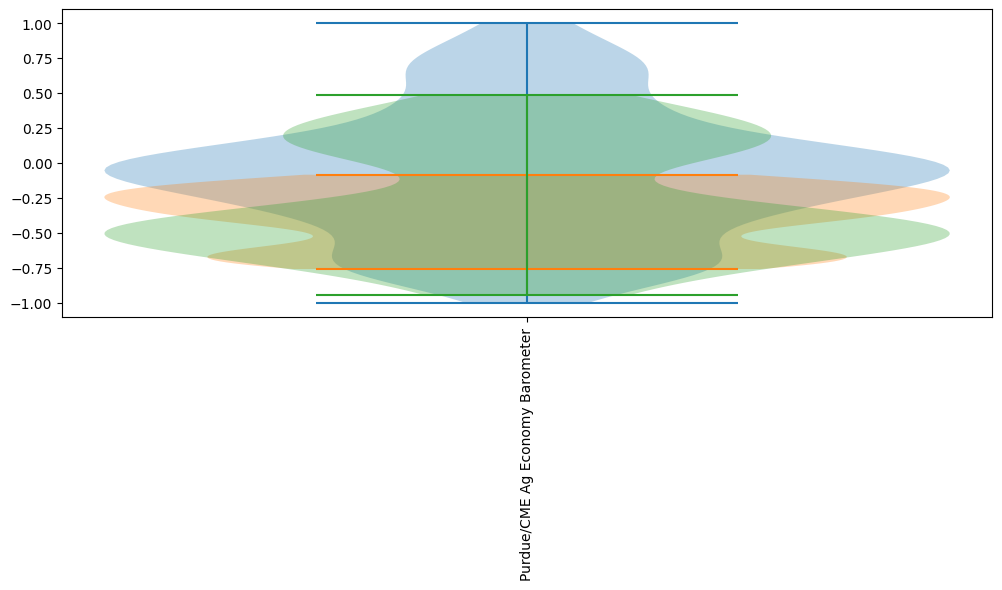

In [ ]:
# Escalamiento del dataset con la función anterior

# Crear diccionario de entrada
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
   'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

# Y escalar (especificando la columna con la variable a predecir)
data_s, scaler = escalar_dataset_uni(data_in)

# Extraer subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']
# Y generemos una gráfica tipo violín para ver la distribución
# de los valores en cada covariable (entrada) y en la variable a
# predecir (salida)

n = len(df_ageconomy.columns)

fig, ax = plt.subplots(figsize=(12,4))
i = 0

ax.violinplot(dataset=x_tr_s[:,:,i].flatten(), positions=[i])
ax.violinplot(dataset=x_vl_s[:,:,i].flatten(), positions=[i])
ax.violinplot(dataset=x_ts_s[:,:,i].flatten(), positions=[i])

# Etiquetas eje horizontal
ax.set_xticks(list(range(n)))
ax.set_xticklabels(df_ageconomy.keys(), rotation=90)
ax.autoscale();
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])


In [ ]:
# crear estudio y optimizar
study = optuna.create_study(direction='minimize')
study.optimize(objective_no_val, n_trials=100)

# resultados
print('Número de trials finalizados:', len(study.trials))
print('Mejor valor (val_loss):', study.best_value)
print('Mejores parámetros:')
for k, v in study.best_trial.params.items():
    print(f'  {k}: {v}')

# reentrenar con los datos de train+val usando los mejores hiperparámetros
best_params = study.best_trial.params

final_model = Sequential()
final_model.add(Input(shape=INPUT_SHAPE))
[final_model.add(LSTM(best_params['n_units'], activation=best_params['activation'], return_sequences=True)) for _ in range(best_params['num']-1)]
final_model.add(LSTM(best_params['n_units'], activation=best_params['activation']))
final_model.add(Dense(OUTPUT_LENGTH, activation='linear'))
final_model.compile(optimizer=RMSprop(learning_rate=best_params['lr']),
                    loss=root_mean_squared_error,
                    metrics=['mape'])

final_model.fit(x_tr_s, y_tr_s,
                epochs=50,
                batch_size=best_params['batch_size'],
                verbose=0)

rmse_test_opt = final_model.evaluate(x_ts_s, y_ts_s, verbose=0)
print(f'RMSE en test con modelo optimizado: {rmse_test_opt[0]:.3f}, MAPE en test con modelo optimizado: {rmse_test_opt[1]:.3f}')



[I 2026-02-21 10:10:25,620] A new study created in memory with name: no-name-a53b1f94-8e7e-4604-98ca-8bebd298416f
[I 2026-02-21 10:10:51,191] Trial 0 finished with value: 0.4305436313152313 and parameters: {'n_units': 208, 'lr': 0.0009510077169573179, 'batch_size': 256, 'activation': 'relu', 'num': 4, 'epochs': 250}. Best is trial 0 with value: 0.4305436313152313.
[I 2026-02-21 10:11:00,501] Trial 1 finished with value: 0.3853045701980591 and parameters: {'n_units': 96, 'lr': 0.007320857841684792, 'batch_size': 256, 'activation': 'relu', 'num': 3, 'epochs': 250}. Best is trial 1 with value: 0.3853045701980591.
[I 2026-02-21 10:11:20,406] Trial 2 finished with value: 0.41999128460884094 and parameters: {'n_units': 160, 'lr': 0.00010430161842929734, 'batch_size': 256, 'activation': 'tanh', 'num': 1, 'epochs': 350}. Best is trial 1 with value: 0.3853045701980591.
[I 2026-02-21 10:11:29,463] Trial 3 finished with value: 0.33879852294921875 and parameters: {'n_units': 240, 'lr': 0.003908466

Número de trials finalizados: 100
Mejor valor (val_loss): 0.2516343891620636
Mejores parámetros:
  n_units: 16
  lr: 0.007429436491701683
  batch_size: 256
  activation: tanh
  num: 1
  epochs: 390
RMSE en test con modelo optimizado: 0.359, MAPE en test con modelo optimizado: 170.656


array([122.331856, 122.47278 , 121.705765, 121.04279 , 120.994675,
       120.78115 , 120.02541 , 119.901276, 119.54087 , 121.0212  ,
       122.652245, 126.0693  , 131.19107 , 133.8359  , 133.86809 ,
       135.18134 , 136.02557 , 135.32126 , 134.84398 , 133.08403 ],
      dtype=float32)

In [ ]:
y_ts_pred = predecir(x_ts_s, final_model, scaler)


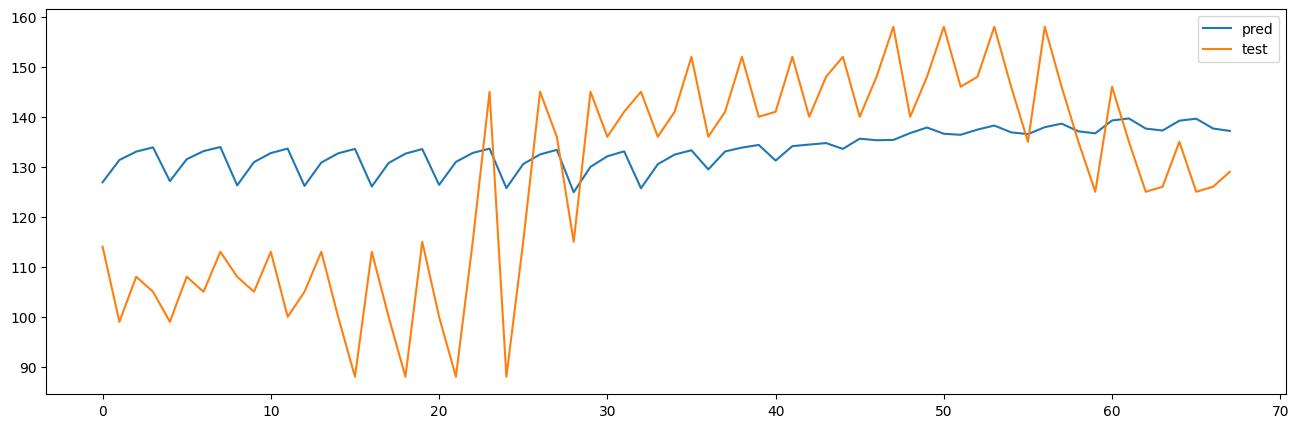

In [ ]:
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(y_ts_pred,label="pred")
ax.plot(y_ts.flatten(),label="test")
plt.legend();

### Recursivo

#### Jumping

Iniciando predicción por bloques con IN=12, OUT=6...

Dimensiones finales:
Predicción continua: (42,)
Datos reales alineados: (42, 1)

Resultados de Predicción Recursiva (Bloques):
MAE:  0.5164
RMSE: 0.5772
MAPE: 34.43%


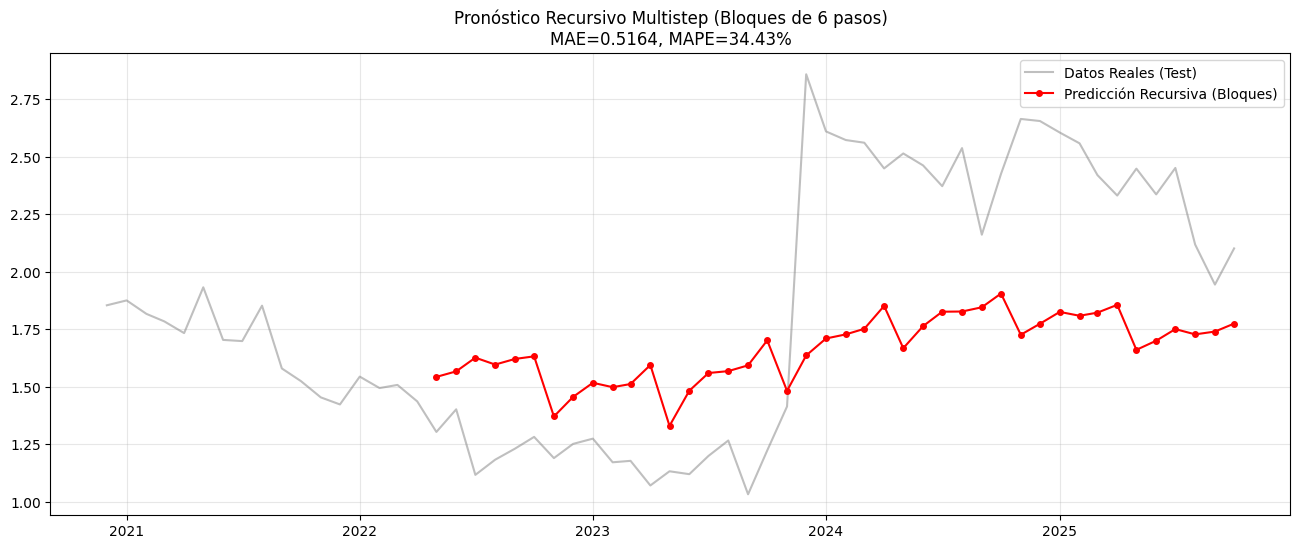

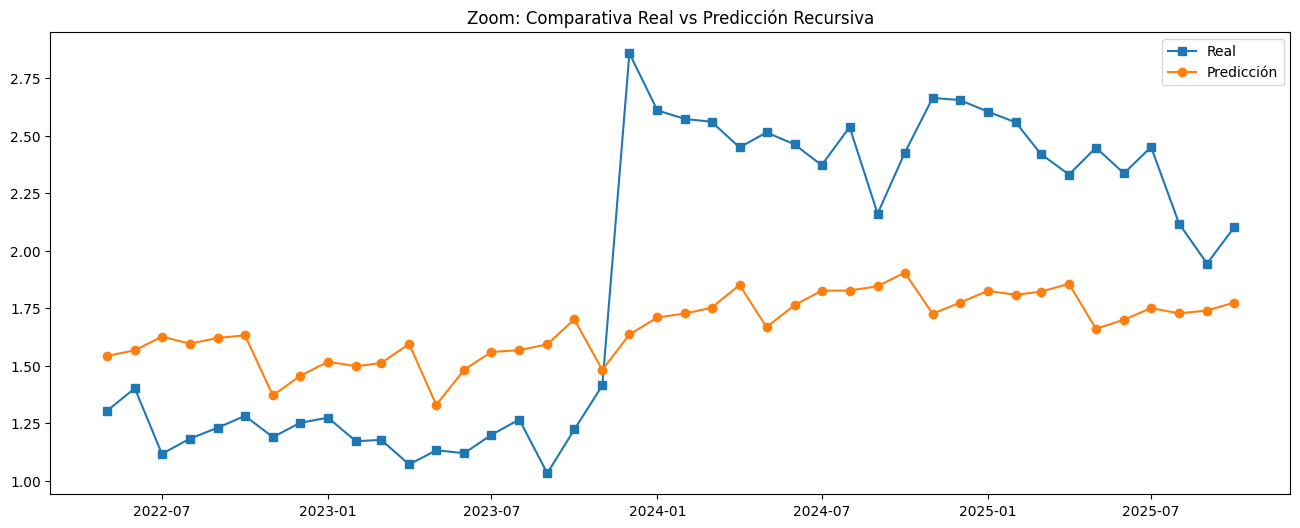

In [ ]:
# -------------------------------------------------------------------------
# EJECUCIÓN Y VISUALIZACIÓN
# -------------------------------------------------------------------------

print(f"Iniciando predicción por bloques con IN={INPUT_LENGTH}, OUT={OUTPUT_LENGTH}...")

# Ejecutar la nueva función
y_ts_pred_continuous = predecir_recursivo_bloques(x_ts_s, final_model, scaler, INPUT_LENGTH, OUTPUT_LENGTH)

# --- AJUSTE DE LONGITUDES ---
# Como predecimos en bloques, podemos pasarnos un poco del largo real de test.
# Recortamos para que coincida exactamente con el largo de y_ts (datos reales)
limit_len = len(y_ts) # Asumiendo que y_ts tiene forma (n_muestras, OUTPUT_LENGTH, 1) o similar
# Ojo: y_ts usualmente tiene overlap. Necesitamos el array plano de valores reales para comparar.
# Vamos a reconstruir el vector de tiempo real para comparar peras con peras.

# Asumiendo que 'ts' es tu dataframe de test original con los valores reales
y_real_vector = ts.values[-len(y_ts_pred_continuous):] 

# Si la predicción es más larga que los datos reales disponibles (por el último bloque), recortamos la predicción
if len(y_ts_pred_continuous) > len(y_real_vector):
    y_ts_pred_continuous = y_ts_pred_continuous[:len(y_real_vector)]
# Si es al revés, recortamos el real
elif len(y_real_vector) > len(y_ts_pred_continuous):
    y_real_vector = y_real_vector[:len(y_ts_pred_continuous)]

# Obtener índices para graficar
idx_plot = ts.index[-len(y_ts_pred_continuous):]

print(f"\nDimensiones finales:")
print(f"Predicción continua: {y_ts_pred_continuous.shape}")
print(f"Datos reales alineados: {y_real_vector.shape}")

# --- MÉTRICAS ---
mae = mean_absolute_error(y_real_vector, y_ts_pred_continuous)
rmse = np.sqrt(mean_squared_error(y_real_vector, y_ts_pred_continuous))
mape = np.mean(np.abs((y_real_vector - y_ts_pred_continuous) / y_real_vector)) * 100

print(f"\nResultados de Predicción Recursiva (Bloques):")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

# --- VISUALIZACIÓN ---
plt.figure(figsize=(16, 6))

# Serie original (Train + Test real)
plt.plot(ts.index, ts, label='Datos Reales (Test)', color='gray', alpha=0.5)

# Predicción recursiva
plt.plot(idx_plot, y_ts_pred_continuous, label='Predicción Recursiva (Bloques)', color='red', marker='o', markersize=4)

plt.title(f'Pronóstico Recursivo Multistep (Bloques de {OUTPUT_LENGTH} pasos)\nMAE={mae:.4f}, MAPE={mape:.2f}%')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Zoom a la zona de predicción
plt.figure(figsize=(16, 6))
plt.plot(idx_plot, y_real_vector, label='Real', marker='s')
plt.plot(idx_plot, y_ts_pred_continuous, label='Predicción', marker='o')
plt.title("Zoom: Comparativa Real vs Predicción Recursiva")
plt.legend()
plt.show()

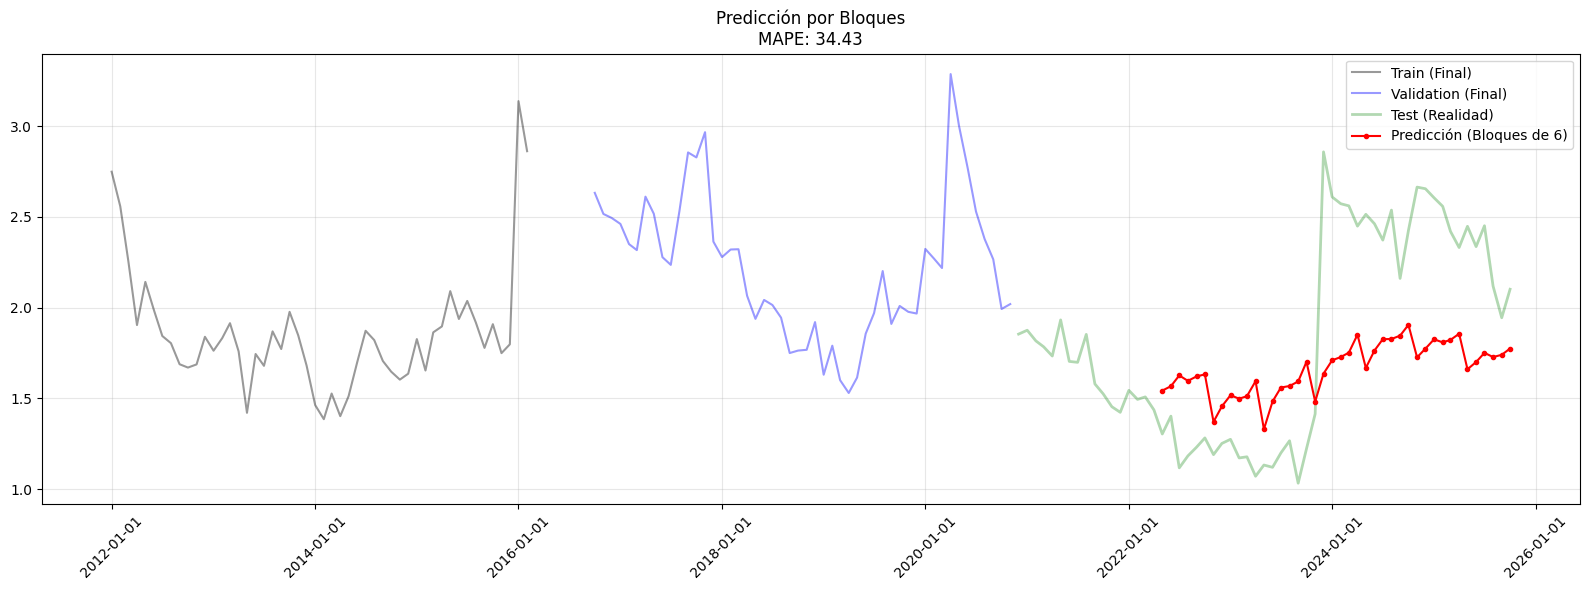

In [139]:
# --- 1. Crear el índice correcto para las predicciones ---
# Las predicciones comienzan después de la primera ventana de input.
# Si x_ts_s se creó desde 'ts', la primera predicción corresponde al índice en:
# ts.index[INPUT_LENGTH] (aprox, depende de cómo creaste las secuencias)

# La forma más segura es tomar el final del índice de ts:
# Como predecimos recursivamente "hacia adelante" llenando el test:
total_preds = len(y_ts_pred_continuous)
idx_pred = ts.index[-total_preds:] # Asignamos las fechas del final de test a nuestras predicciones

df_pred = pd.DataFrame({'y_ts_pred': y_ts_pred_continuous}, index=idx_pred)

# --- 2. Visualización Corregida ---
import matplotlib.dates as mdates

plt.figure(figsize=(16, 6))

# A. Datos de Entrenamiento (Últimos 100 puntos para ver la unión)
# No graficamos todo el train para hacer zoom en la transición
plt.plot(tr.index[-50:], tr[-50:], label='Train (Final)', color='black', alpha=0.4)

plt.plot(vl.index[-50:], vl[-50:], label='Validation (Final)', color='blue', alpha=0.4)

# B. Datos de Test (Realidad Completa)
plt.plot(ts.index, ts, label="Test (Realidad)", color='green', alpha=0.3, linewidth=2)


# C. Predicción Recursiva (Encima del Test)
plt.plot(df_pred.index, df_pred['y_ts_pred'], label=f"Predicción (Bloques de {OUTPUT_LENGTH})", color='red', marker='o', markersize=3)

# D. Estética y Formato
plt.title(f'Predicción por Bloques\nMAPE: {mape:.2f}')
plt.legend()
plt.grid(True, alpha=0.3)

# Formato de fecha en eje X para que no se amontone
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### MultiStep Rolling Forecast

Iniciando Rolling Forecast (Reset con Real) con IN=12, OUT=6...

Dimensiones finales:
Predicción Rolling: (42,)
Datos reales:       (42, 1)

Resultados de Rolling Forecast (Actualización Real):
MAE:  0.4284
RMSE: 0.5568
MAPE: 37.96%


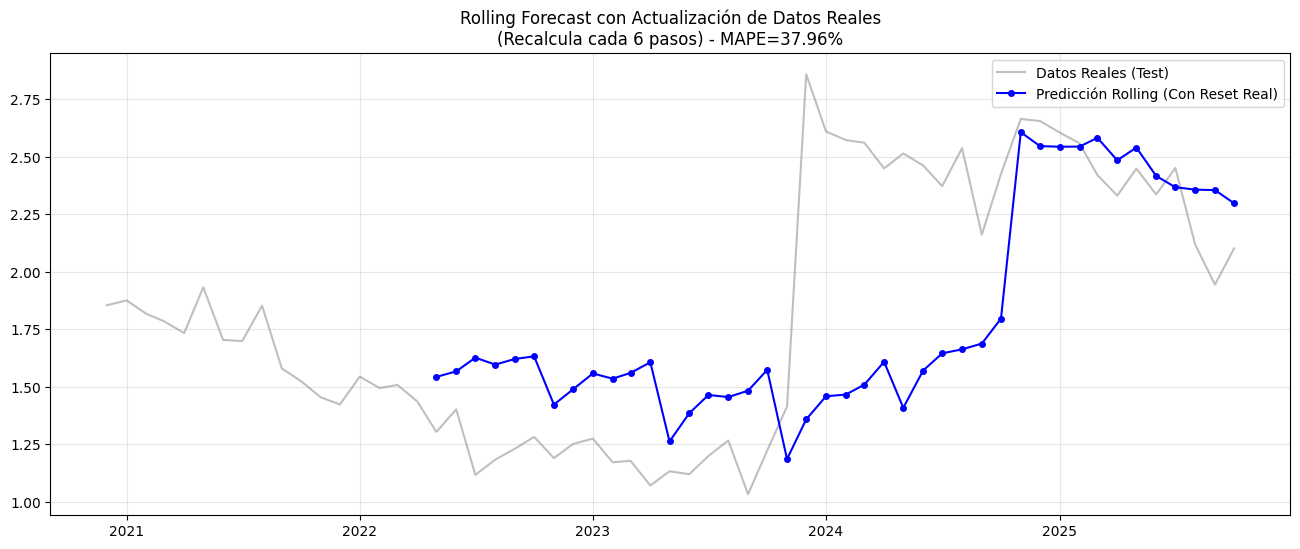

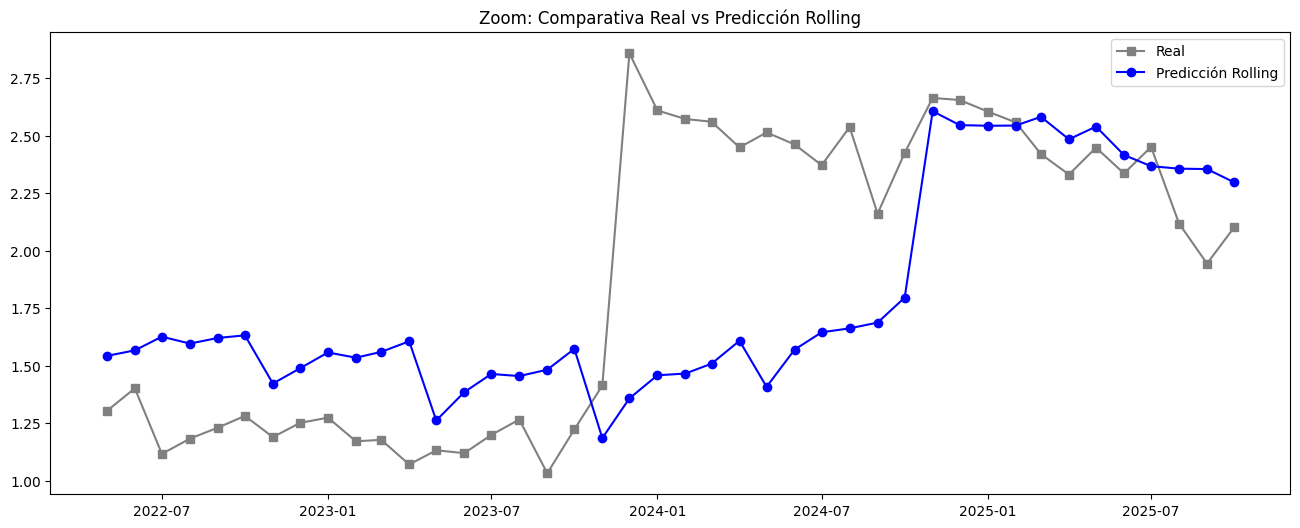

In [ ]:
# -------------------------------------------------------------------------
# EJECUCIÓN Y VISUALIZACIÓN
# -------------------------------------------------------------------------

print(f"Iniciando Rolling Forecast (Reset con Real) con IN={INPUT_LENGTH}, OUT={OUTPUT_LENGTH}...")

# Ejecutar la función MODIFICADA
y_ts_pred_rolling = predecir_con_actualizacion_real(x_ts_s, final_model, scaler, INPUT_LENGTH, OUTPUT_LENGTH)

# --- AJUSTE DE LONGITUDES ---
# Reconstruir vector real para comparación
y_real_vector = ts.values[-len(y_ts_pred_rolling):] 

# Recortes por si el último bloque se pasa
if len(y_ts_pred_rolling) > len(y_real_vector):
    y_ts_pred_rolling = y_ts_pred_rolling[:len(y_real_vector)]
elif len(y_real_vector) > len(y_ts_pred_rolling):
    y_real_vector = y_real_vector[:len(y_ts_pred_rolling)]

# Obtener índices para graficar
idx_plot = ts.index[-len(y_ts_pred_rolling):]

print(f"\nDimensiones finales:")
print(f"Predicción Rolling: {y_ts_pred_rolling.shape}")
print(f"Datos reales:       {y_real_vector.shape}")

# --- MÉTRICAS ---
mae = mean_absolute_error(y_real_vector, y_ts_pred_rolling)
rmse = np.sqrt(mean_squared_error(y_real_vector, y_ts_pred_rolling))
mape = np.mean(np.abs((y_real_vector - y_ts_pred_rolling) / y_real_vector)) * 100

print(f"\nResultados de Rolling Forecast (Actualización Real):")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

# --- VISUALIZACIÓN ---
plt.figure(figsize=(16, 6))

# Serie original (Train + Test real)
plt.plot(ts.index, ts, label='Datos Reales (Test)', color='gray', alpha=0.5)

# Predicción Rolling (Reset)
# Esta línea se verá "mejor" (más pegada al real) que la recursiva pura,
# porque corrige el rumbo cada OUTPUT_LENGTH pasos.
plt.plot(idx_plot, y_ts_pred_rolling, label='Predicción Rolling (Con Reset Real)', color='blue', marker='o', markersize=4)

plt.title(f'Rolling Forecast con Actualización de Datos Reales\n(Recalcula cada {OUTPUT_LENGTH} pasos) - MAPE={mape:.2f}%')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Zoom
plt.figure(figsize=(16, 6))
plt.plot(idx_plot, y_real_vector, label='Real', marker='s', color='gray')
plt.plot(idx_plot, y_ts_pred_rolling, label='Predicción Rolling', marker='o', color='blue')
plt.title("Zoom: Comparativa Real vs Predicción Rolling")
plt.legend()
plt.show()

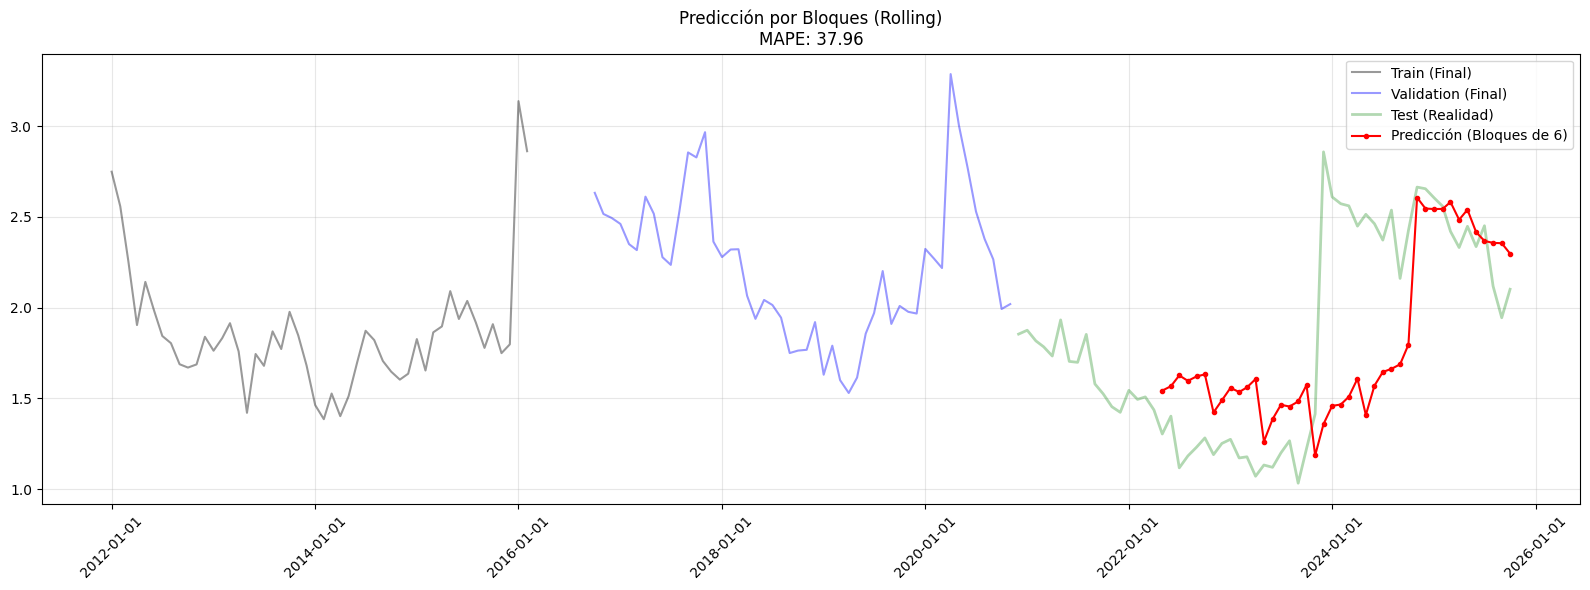

In [141]:
# --- 1. Crear el índice correcto para las predicciones ---
# Las predicciones comienzan después de la primera ventana de input.
# Si x_ts_s se creó desde 'ts', la primera predicción corresponde al índice en:
# ts.index[INPUT_LENGTH] (aprox, depende de cómo creaste las secuencias)

# La forma más segura es tomar el final del índice de ts:
# Como predecimos recursivamente "hacia adelante" llenando el test:
total_preds = len(y_ts_pred_rolling)
idx_pred = ts.index[-total_preds:] # Asignamos las fechas del final de test a nuestras predicciones

df_pred = pd.DataFrame({'y_ts_pred': y_ts_pred_rolling}, index=idx_pred)

# --- 2. Visualización Corregida ---
import matplotlib.dates as mdates

plt.figure(figsize=(16, 6))

# A. Datos de Entrenamiento (Últimos 100 puntos para ver la unión)
# No graficamos todo el train para hacer zoom en la transición
plt.plot(tr.index[-50:], tr[-50:], label='Train (Final)', color='black', alpha=0.4)
plt.plot(vl.index[-50:], vl[-50:], label='Validation (Final)', color='blue', alpha=0.4)

# B. Datos de Test (Realidad Completa)
plt.plot(ts.index, ts, label="Test (Realidad)", color='green', alpha=0.3, linewidth=2)

# C. Predicción Recursiva (Encima del Test)
plt.plot(df_pred.index, df_pred['y_ts_pred'], label=f"Predicción (Bloques de {OUTPUT_LENGTH})", color='red', marker='o', markersize=3)

# D. Estética y Formato
plt.title(f'Predicción por Bloques (Rolling)\nMAPE: {mape:.2f}')
plt.legend()
plt.grid(True, alpha=0.3)

# Formato de fecha en eje X para que no se amontone
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()